In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob
import os

sys.path.append("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/")

from scripts import initial_map, map_refiner, complexity, finder, preprocess, error_correct, plotting, umi_deduplicate


import glob
from tqdm import tqdm  # progress bar

In [4]:
! pwd

/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/GCN4


# Step 1 ** Organize figures **

In [5]:
EC_AD = finder.Barcode(name = "AD",
                        preceder = "GGCTAGC",
                       post = "",
                       length = 120)

EC_AD_BC = finder.Barcode(name = "AD_BC",
                       preceder = "CGCGCC",
                       post = "",
                       length = 11)

EC_RPTR_BC = finder.Barcode(name = "RPTR_BC",
                       preceder = "CTCGAG",
                       post = "",
                       length = 14)
AD_objects = [EC_AD, EC_AD_BC]


In [6]:
db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_final.db"

In [5]:
step1_mapper = initial_map.InitialMapper(db_path =db_path,
                                       step_name = "step1", #Should include time point, replicate (don't need to specify BC type(s))
                                       seq_file = "/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2024/A10_A11/results/A10_S1.fastq.gz.assembled.fastq",
                                       design_file_path =  "/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/A10_sequencing/v2/current/a10_designfile.csv",
                                       bc_objects = [EC_AD, EC_AD_BC, EC_RPTR_BC],
                                       reverse_complement = True)

In [6]:
# step1_mapper.create_map()

In [7]:
step1_mapper.preview_map()

step1_AD_AD_BC_RPTR_BC_initial
Total rows: 138671404


AD  AD_qual        AD_BC  \
0  TCTTCTTCTCCATCTCCACCATCTTCTTTGCCATCTCCATCTTCTA...     True                
1  TCTACTCAATCTACTTGGCCACCATCTTCTTCTTCTTCTCAACCAG...     True  CAATGCCTACT   
2  CCAGTTGCTTTGAAGAGAGCTAGAAATACTTTGGCTGCTAGGAAAT...     True  AGAAGTTACGC   
3  TCTCCATCTGACTTTACTCCACCACCAACTGTTACTATCTTGCCAC...     True                
4  TCTTTGCCAGCTCAATCTCCACAAACTCAATATCAAGATCATTCTG...     True                

   AD_BC_qual         RPTR_BC  RPTR_BC_qual  Designed  
0       False  CAATTAGCTATAGC          True         1  
1        True  GTATCCGTACATGC          True         1  
2        True  ATAACACACAAACG          True         1  
3       False  GTAACAATGAAGGC          True         1  
4       False  CCTTTTCTATAAGT          True         1

Base prefix (stable across descriptors): step1_AD_AD_BC_RPTR_BC_
Full prefix for this instance: step1_AD_AD_BC_RPTR_BC_

Using the following step order:
1. initial
2. barcode_exists
3. quality
4. grouped
5. thresholded
6. unique_target
7. designed

Removing rows with null or empty barcodes (excluding AD)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 37.59 seconds.


Filtering to high-quality reads...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: step1_AD_AD_BC_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 1.10 minutes.

Grouping step1_AD_AD_BC_RPTR_BC_quality...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

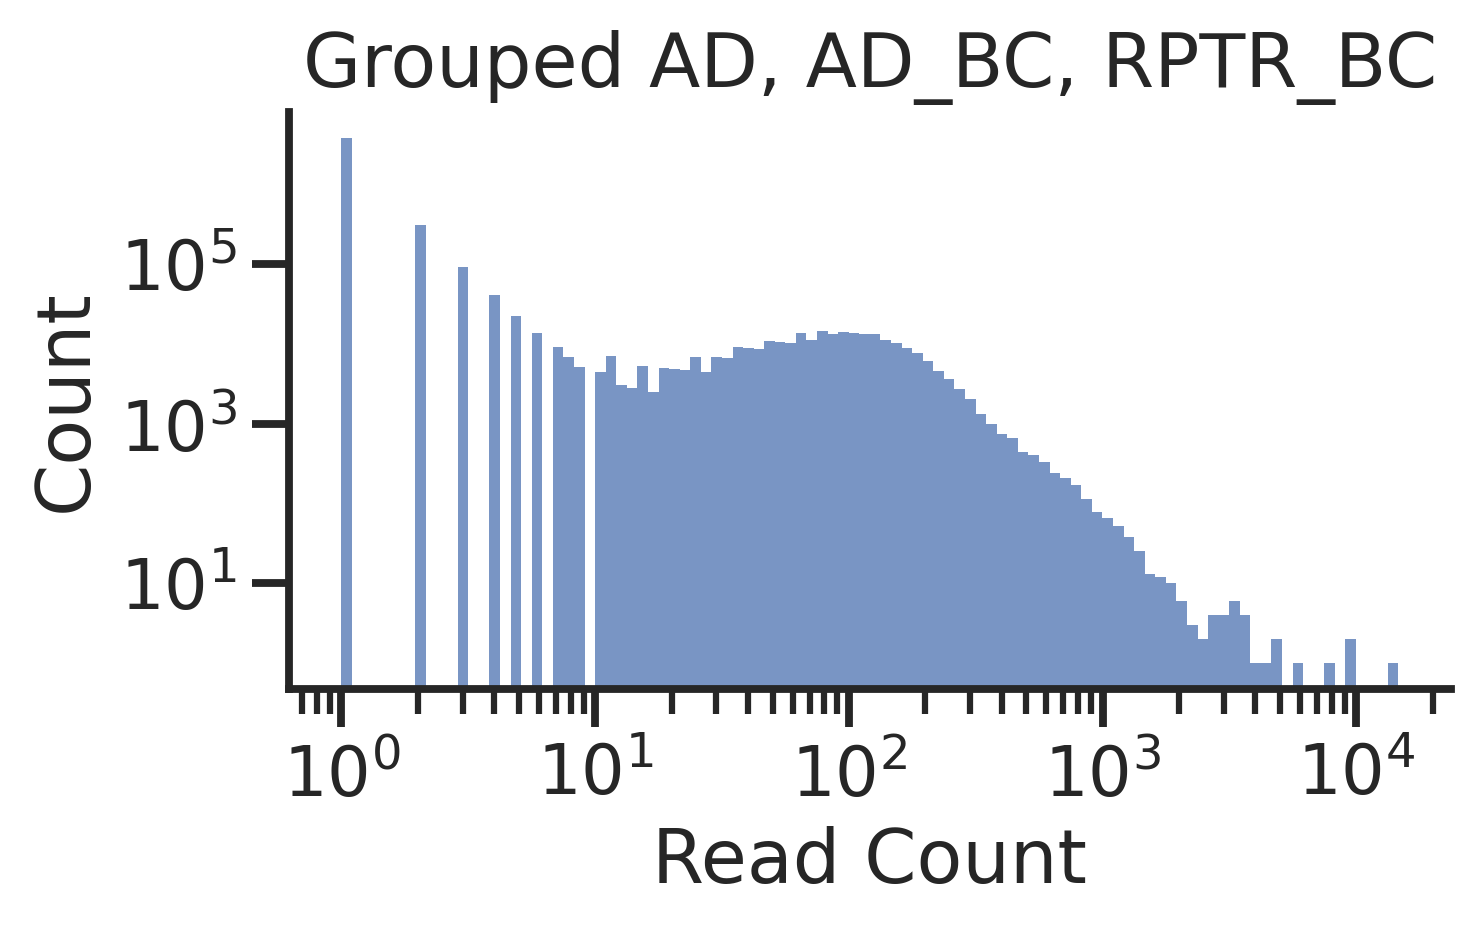

Done in 18.59 seconds.

Thresholding...
Using reads threshold of 50.


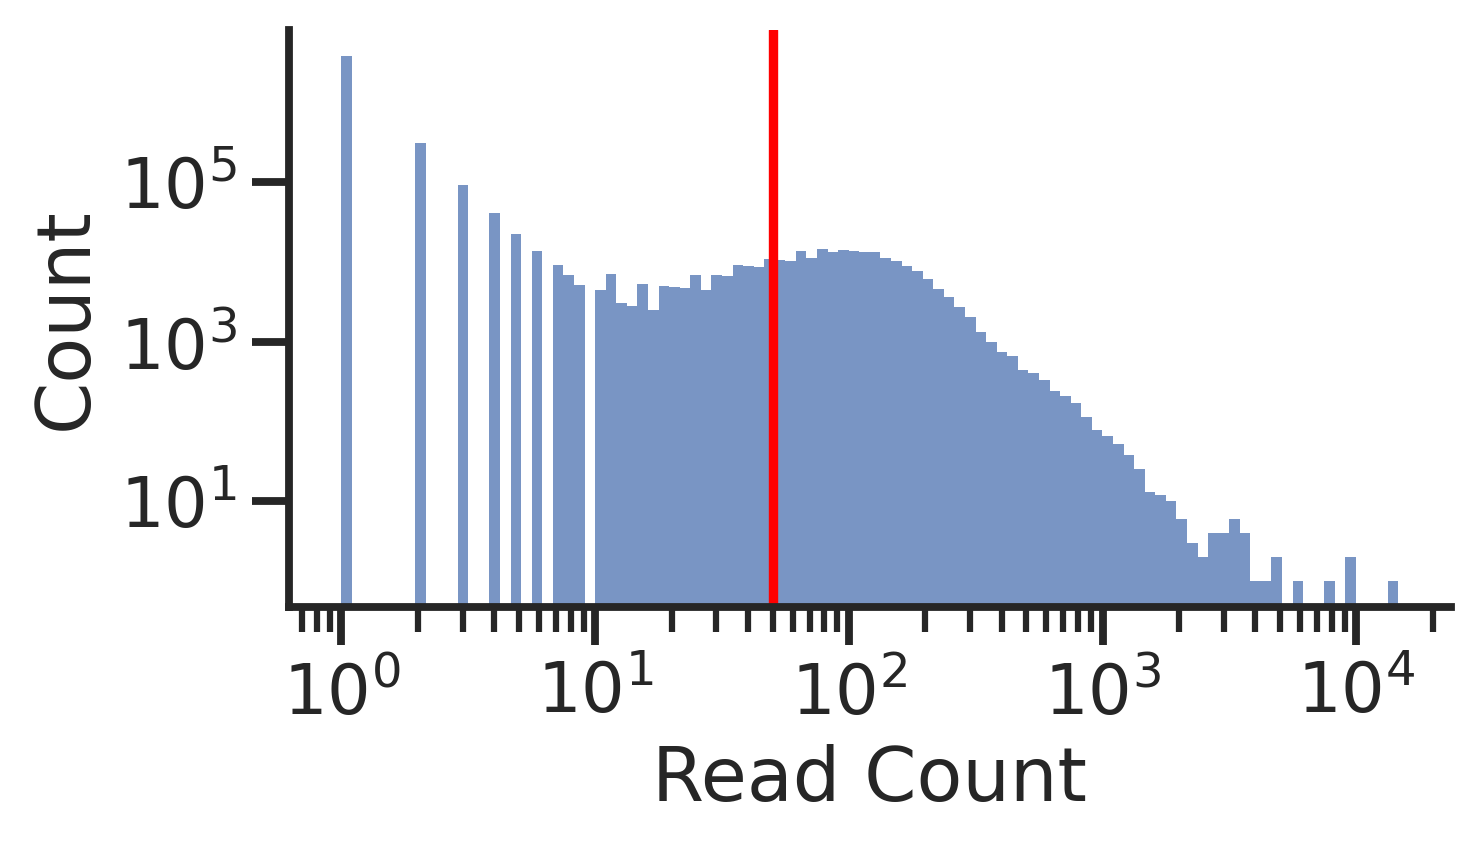

Done in 6.37 seconds.

Filtering so that at least 90% of reads come from the most abundant target...
	Processing mapping 1: RPTR_BC → AD
Created filtered table: step1_AD_AD_BC_RPTR_BC_unique_target
Done in 0.59 seconds.


Filtering to designed sequences...
Created table: step1_AD_AD_BC_RPTR_BC_designed — kept only Designed == 1.
Done in 0.27 seconds.

Done.


In [8]:
refiner = map_refiner.MapRefiner(db_path =db_path,
                                bc_objects = [EC_AD, EC_AD_BC, EC_RPTR_BC],
                                column_pairs = [( "RPTR_BC", "AD")],
                                reads_threshold = 50,
                                map_order = [
                                    "barcode_exists",
                                    "quality",
                                    "grouped",
                                    "thresholded",
                                    "unique_target",
                                    "designed"
                                ],                                
                                step_name = "step1",
                                output_figures_path="../../output/GCN4/figures/")
refiner.refine_map_from_db()

Saved loss summary table as 'step1_AD_AD_BC_RPTR_BC_loss_summary'
Done in 3.19 seconds.



Text(0.5, 1.0, 'GCN4 Step 1, No Error Correction')

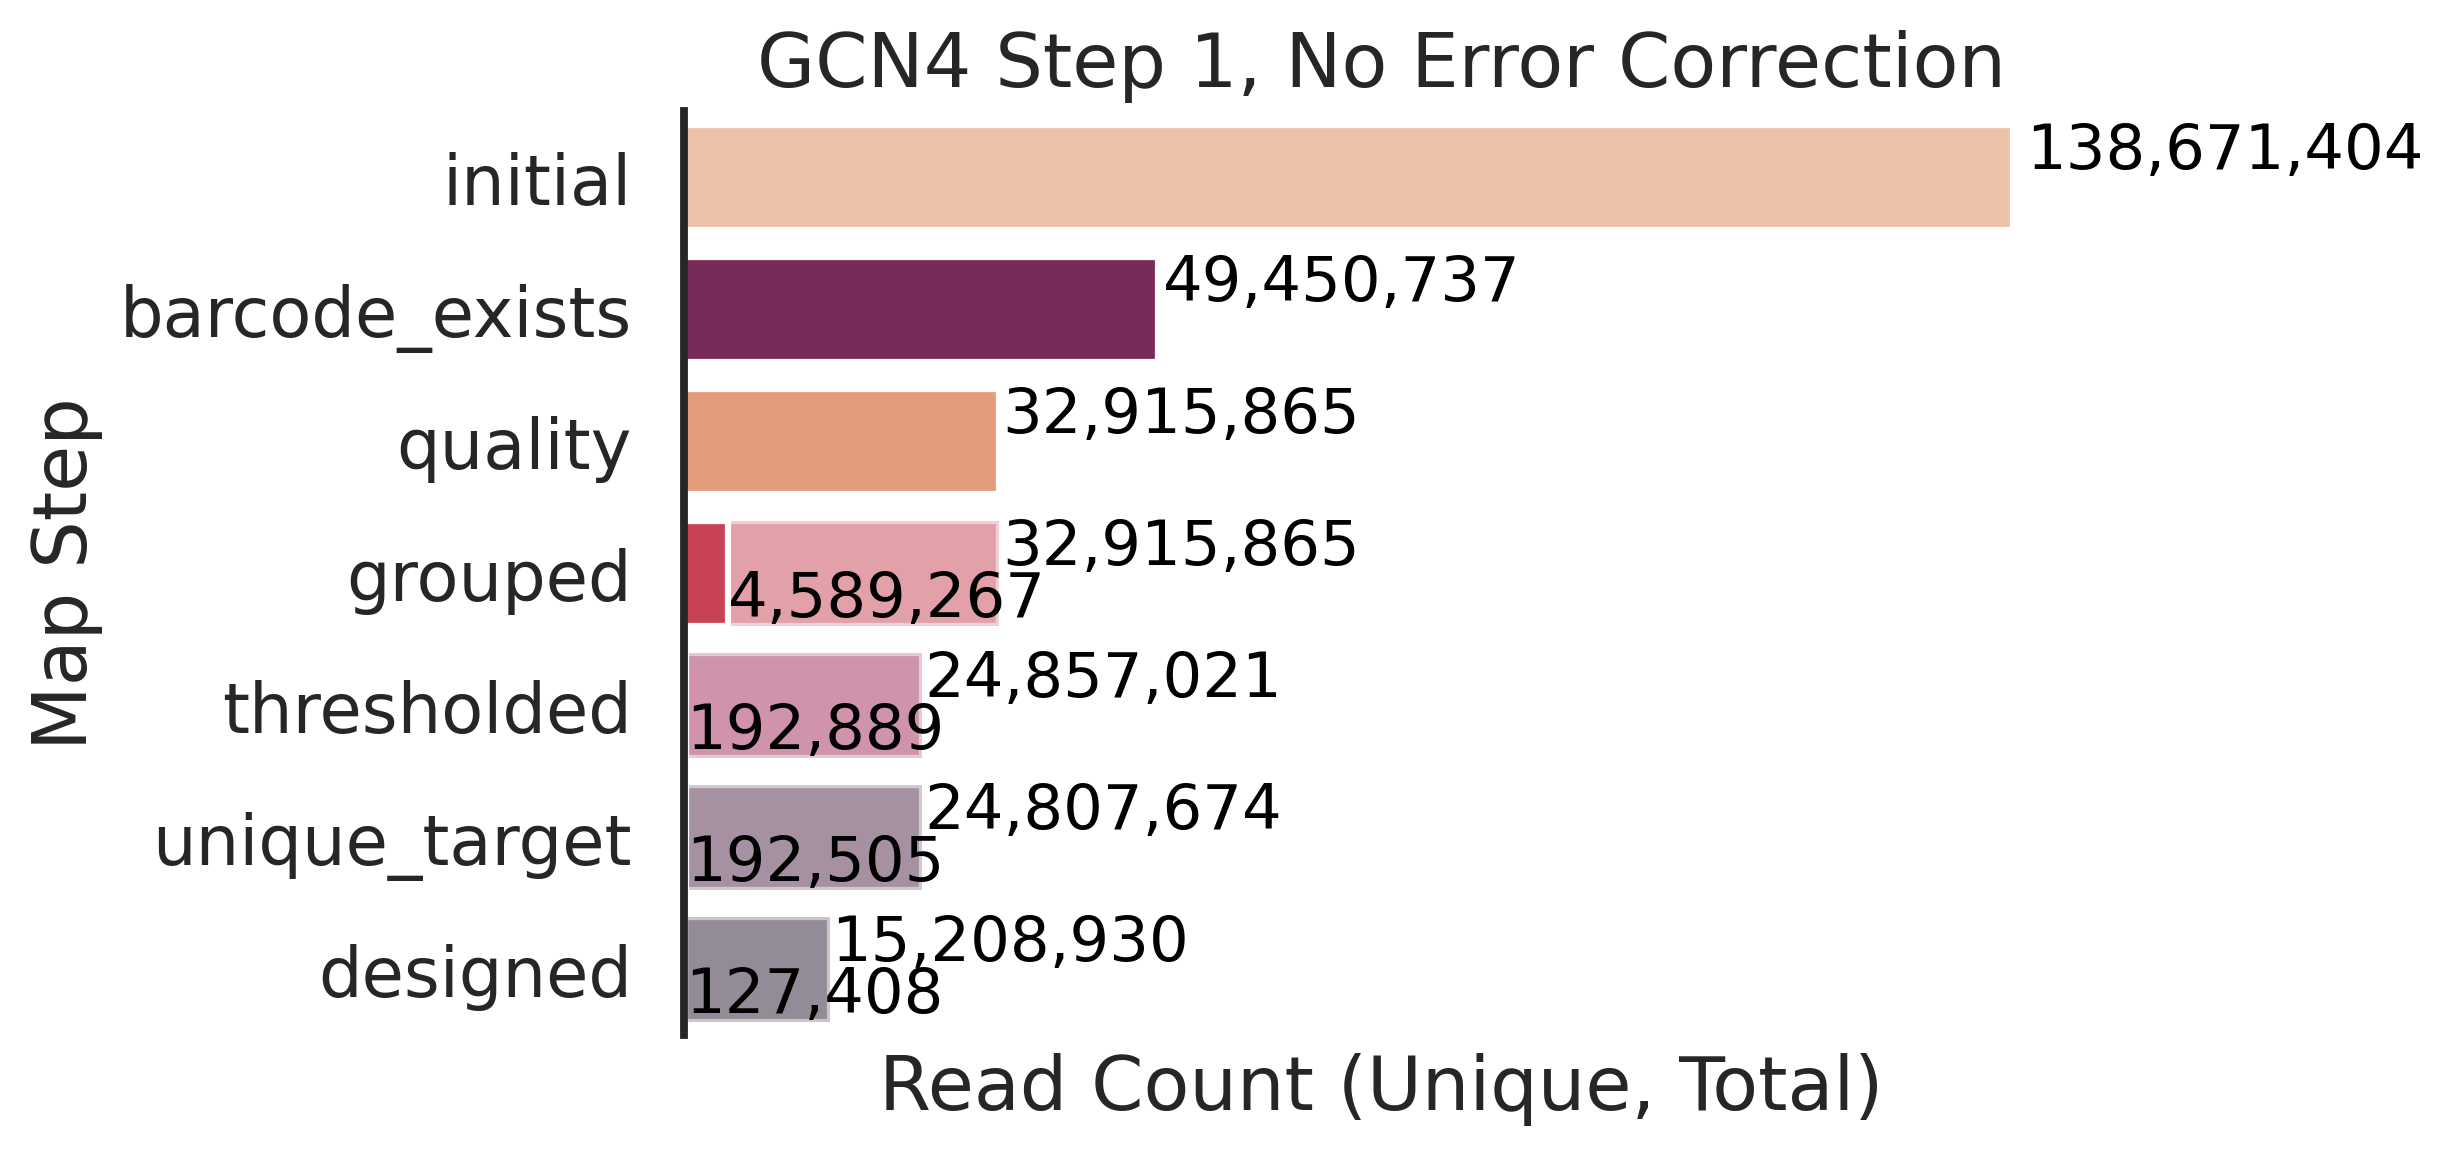

In [11]:
fig, ax = refiner.plot_loss(text_offset = -0.2)
ax.set_title("GCN4 Step 1, No Error Correction")

# Step 2 Spike-in ** Organize figures **

## 1. AD + ADBC

In [6]:
AD_step2_paths = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/*AD*.assembled.fastq")
AD_step2_paths

['/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_AD_E1_MVS_0069_I1_AGCGAGCCAT_ACCGTAGATA_S6.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_AD_E1_MVS_0070_I1_TCCAGAACTC_ACGTGAGCGA_S7.fastq.gz.assembled.fastq']

In [11]:
step2_AD_mapper = initial_map.InitialMapper(
        db_path="/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_final.db",
        seq_file=AD_step2_paths,
        step_name="step2",
        bc_objects=[EC_AD, EC_AD_BC],
        reverse_complement=True,
            design_file_path = "/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/A10_sequencing/v2/current/a10_designfile.csv"
    )
step2_AD_mapper.create_map()

Reading 2 FASTQ/TXT file(s)...
Done in 4.25 seconds.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.20 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})
CGCGCC(.{1,11})
Done in 7.14 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...
Done in 4.26 seconds.

Mapping complete.


In [12]:
step2_AD_mapper.preview_map()

step2_AD_AD_BC_initial
Total rows: 531243


AD  AD_qual        AD_BC  \
0  CCAATTATCCATCTGTTAGAGCTGCTCCATCTTATTCTTCTTCTGG...     True  GGTCCAAAAGA   
1  GAACCTAAGAAGAGAACTACTAGGAAGAAGAAAGATCCAAATGCTC...     True  CTTTACAGTTT   
2  CCAGATTCATTTGTCTTTAAGTTTATATGATTATGGCTATTGGTTG...     True  TGGTTTCTCCT   
3  AGAACTCATTCTATCCAATGAACTCTGGTAATAATTATTTGCCATC...     True  ACGGTGATAGT   
4  GCTGGTAAGAAGAAGAATTATACTGCTTCTGTTGCTGCTTCTAAGA...     True  TGGAGGTACGC   

   AD_BC_qual  Designed  
0        True         0  
1        True         0  
2        True         0  
3        True         0  
4        True         0

In [14]:
# Refine ADBC map
step2_AD_ADBC_refiner = map_refiner.MapRefiner(db_path =db_path,
                                                bc_objects=[EC_AD, EC_AD_BC],
                                                column_pairs = [],
                                                map_order = ['quality', 'grouped', 'thresholded', 'designed'],
                                                step_name="step2",
                                                output_figures_path="../../output/GCN4/figures/",
                                                design_file = "/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/A10_sequencing/v2/current/a10_designfile.csv",
                                              reads_threshold = 10)


Base prefix (stable across descriptors): step2_AD_AD_BC_
Full prefix for this instance: step2_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded
5. designed




Filtering to high-quality reads...
Created table: step2_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 10.75 seconds.

Grouping step2_AD_AD_BC_quality...


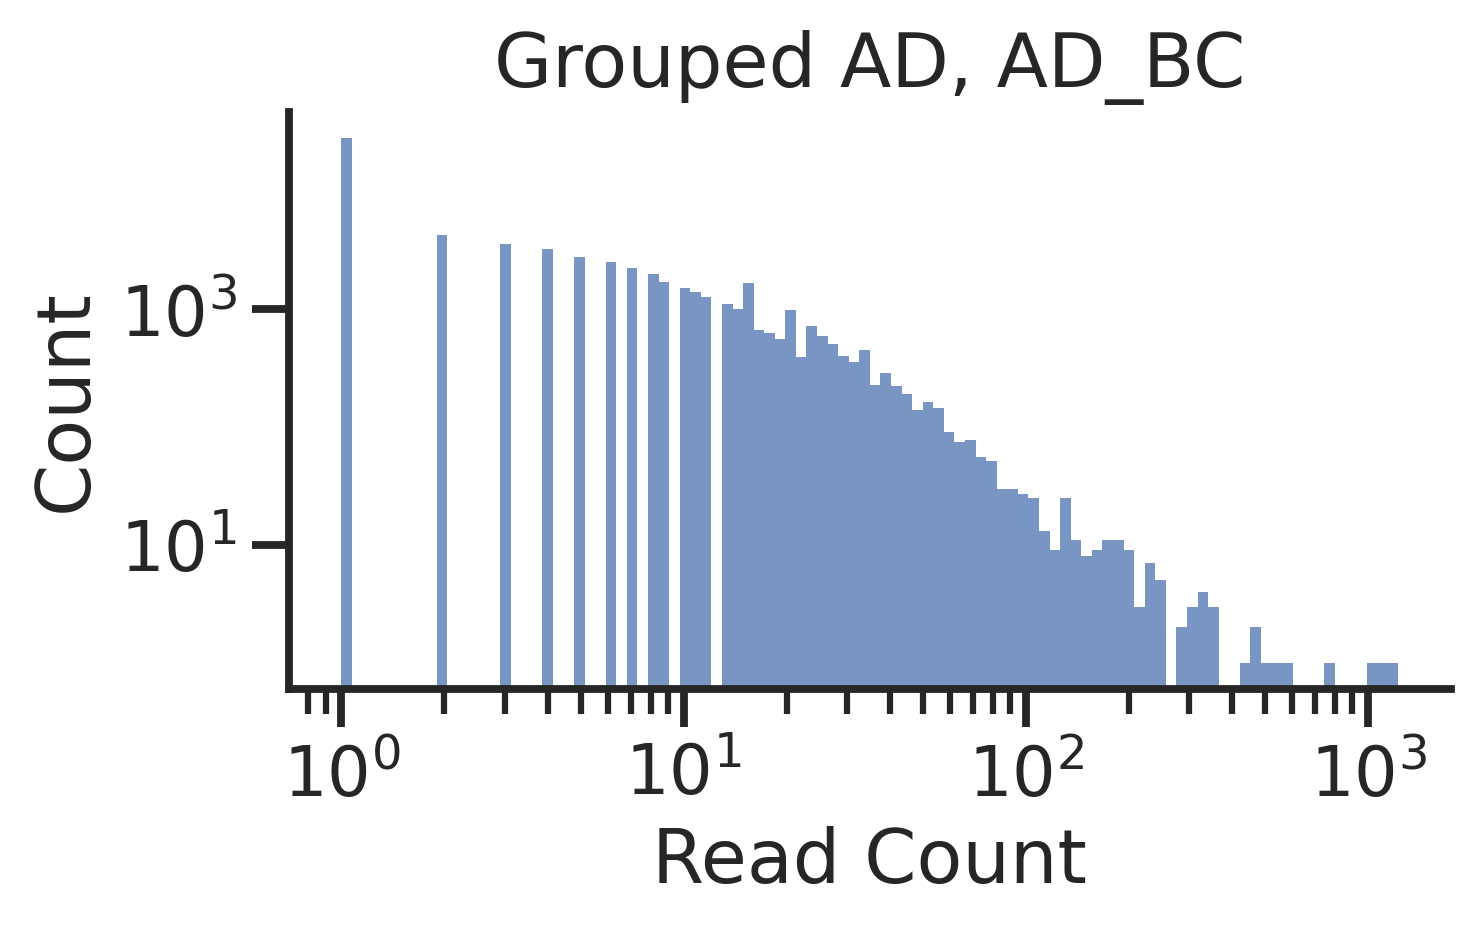

Done in 0.97 seconds.

Thresholding...
Using reads threshold of 10.


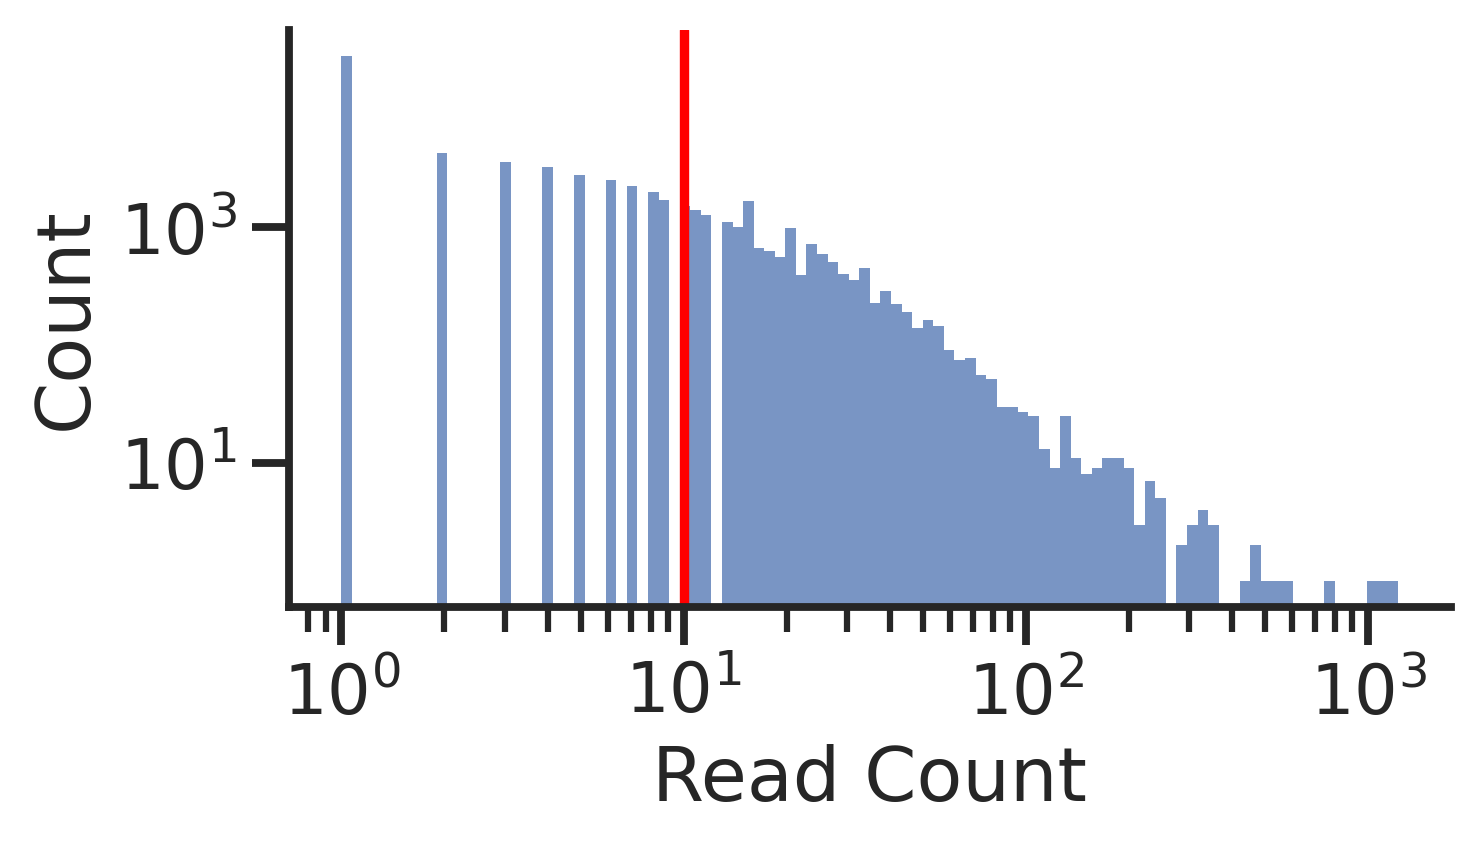

Done in 0.97 seconds.


Filtering to designed sequences...
Created table: step2_AD_AD_BC_designed — kept only Designed == 1.
Done in 0.01 seconds.

Done.


In [15]:
step2_AD_ADBC_refiner.refine_map_from_db()

Saved loss summary table as 'step2_AD_AD_BC_loss_summary'
Done in 0.11 seconds.



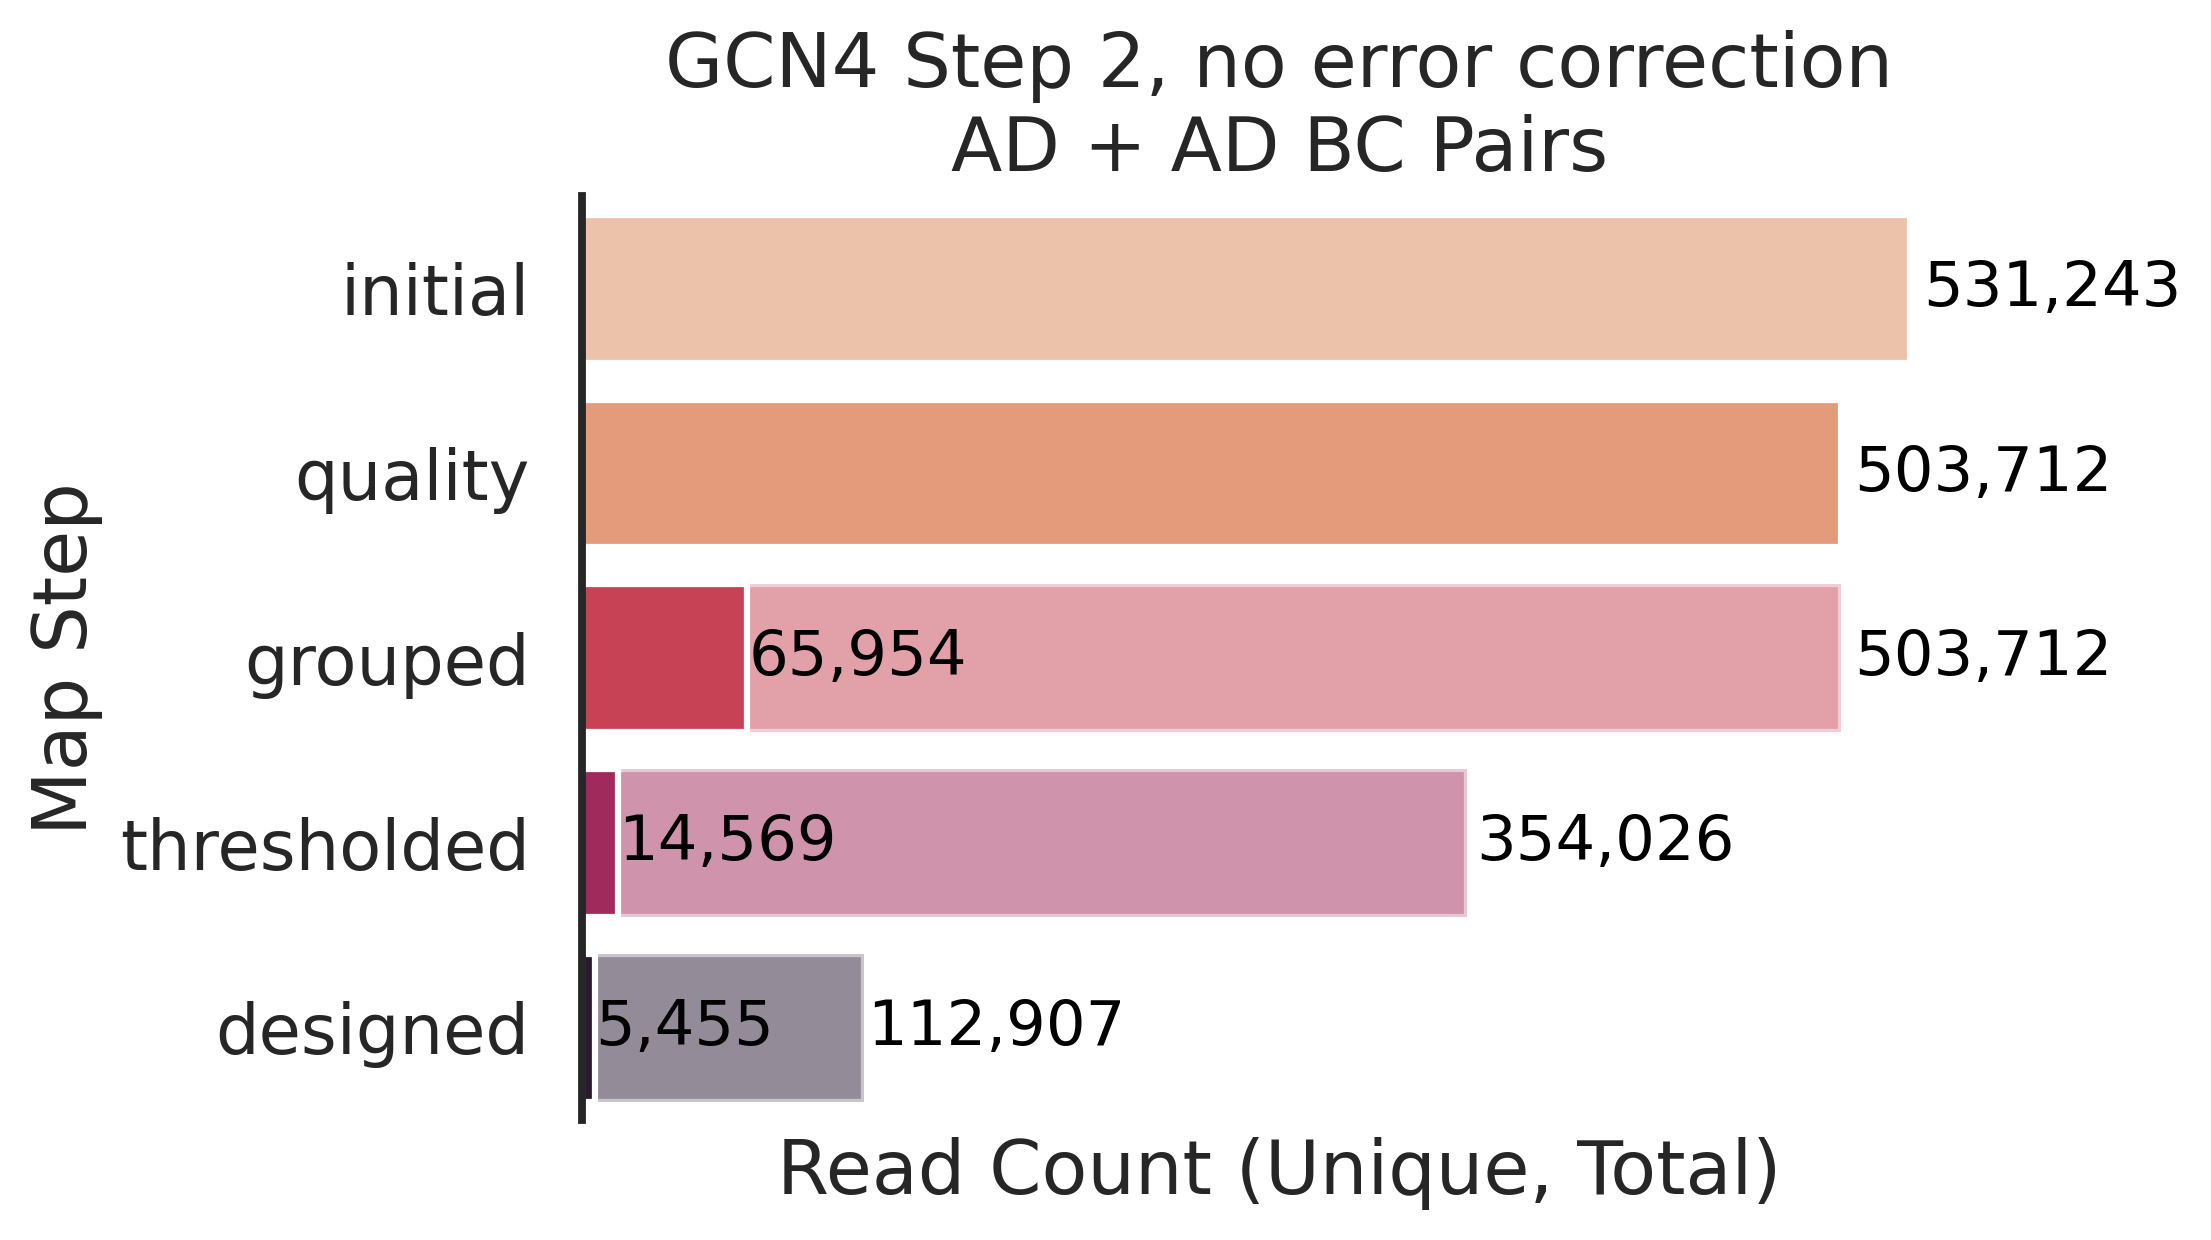

In [17]:
ax = step2_AD_ADBC_refiner.plot_loss()
plt.title("GCN4 Step 2, no error correction\nAD + AD BC Pairs")
plt.show()

## 2. RPTR BC

In [15]:
RPTR_step2_paths = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/*RPTR*.assembled.fastq")
RPTR_step2_paths

['/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_RPTR_E1_v1_MVS_0065_I1_CTATGGCGGA_CGGTAGAATT_S2.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_RPTR_E1_v2_MVS_0067_I1_GTCTTGTGCC_TCATGTAGGA_S4.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_RPTR_E3_v1_MVS_0066_I1_TGGCTGCTGA_GCCAGTCTGT_S3.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/LC_E1_step2/LC_E1_step2_testlibs_spikein/results/Staller_RPTR_E3_v2_MVS_0068_I1_TCGAGGTTAA_CTCGCAGCAA_S5.fastq.gz.assembled.fastq']

In [16]:
step2_RPTR_mapper = initial_map.InitialMapper(
        db_path="/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_final.db",
        seq_file=RPTR_step2_paths,
        step_name="step2",
        bc_objects=[EC_RPTR_BC],
        reverse_complement=True
    )
step2_RPTR_mapper.create_map()

Reading 4 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 4.55 seconds.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 3.26 seconds.

Extracting 1 barcodes...
CTCGAG(.{1,14})
Done in 0.65 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Done in 0.84 seconds.

Mapping complete.


In [17]:
step2_RPTR_mapper.preview_map()

step2_RPTR_BC_initial
Total rows: 1304387


RPTR_BC  RPTR_BC_qual  Designed
0  TGCTTATGCGCATC          True         1
1  TCTCCTCCCCTGCC          True         1
2  TGAGCGATATACGG          True         1
3  TATAATCTATGTAA          True         1
4  TTATCTGATGAAAG          True         1

Base prefix (stable across descriptors): step2_RPTR_BC_
Full prefix for this instance: step2_RPTR_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded


Filtering to high-quality reads...
Created table: step2_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 10.25 seconds.

Grouping step2_RPTR_BC_quality...


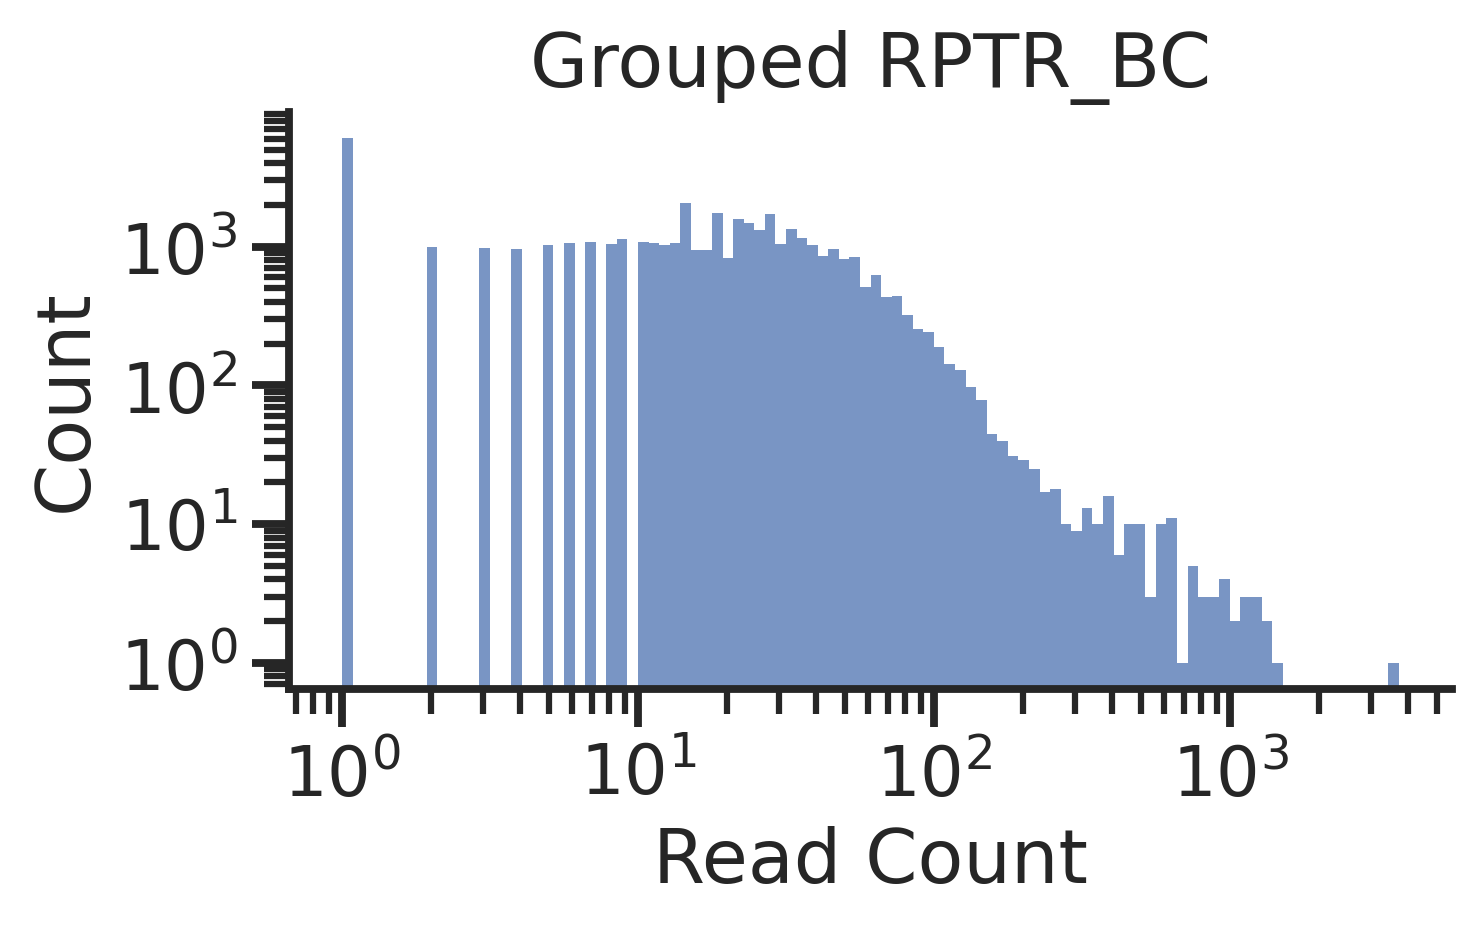

Done in 1.22 seconds.

Thresholding...
Using reads threshold of 10.


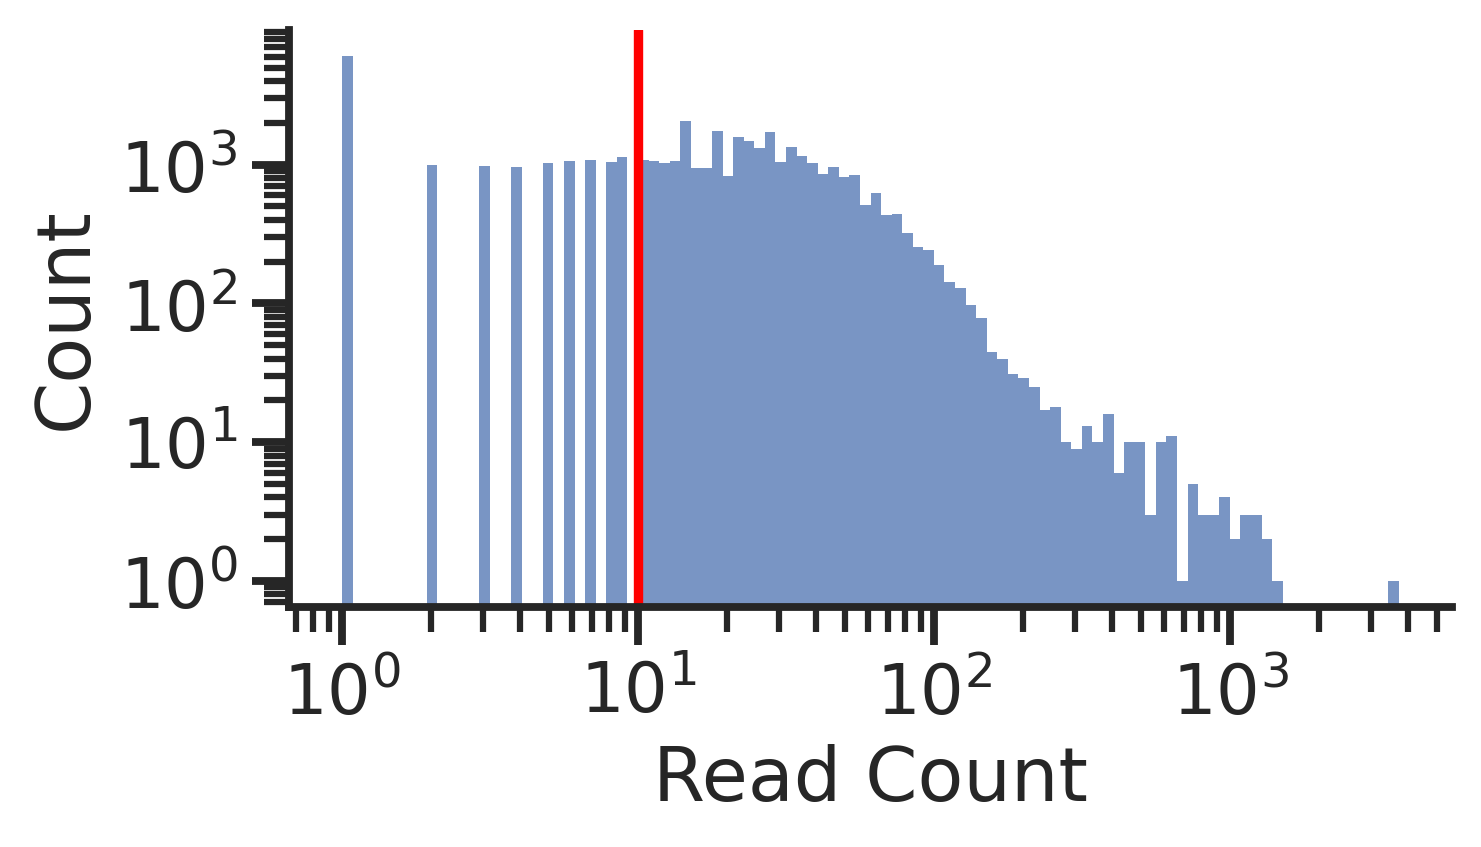

Done in 1.23 seconds.

Done.


In [21]:
# Refine RPTR map
step2_RPTR_refiner = map_refiner.MapRefiner(db_path =db_path,
                                                bc_objects=[EC_RPTR_BC],
                                                column_pairs = [],
                                                map_order = ['quality', 'grouped', 'thresholded'],
                                                step_name="step2",
                                                output_figures_path="../../output/GCN4/figures/",
                                           reads_threshold = 10)
step2_RPTR_refiner.refine_map_from_db()


Saved loss summary table as 'step2_RPTR_BC_loss_summary'
Done in 0.02 seconds.



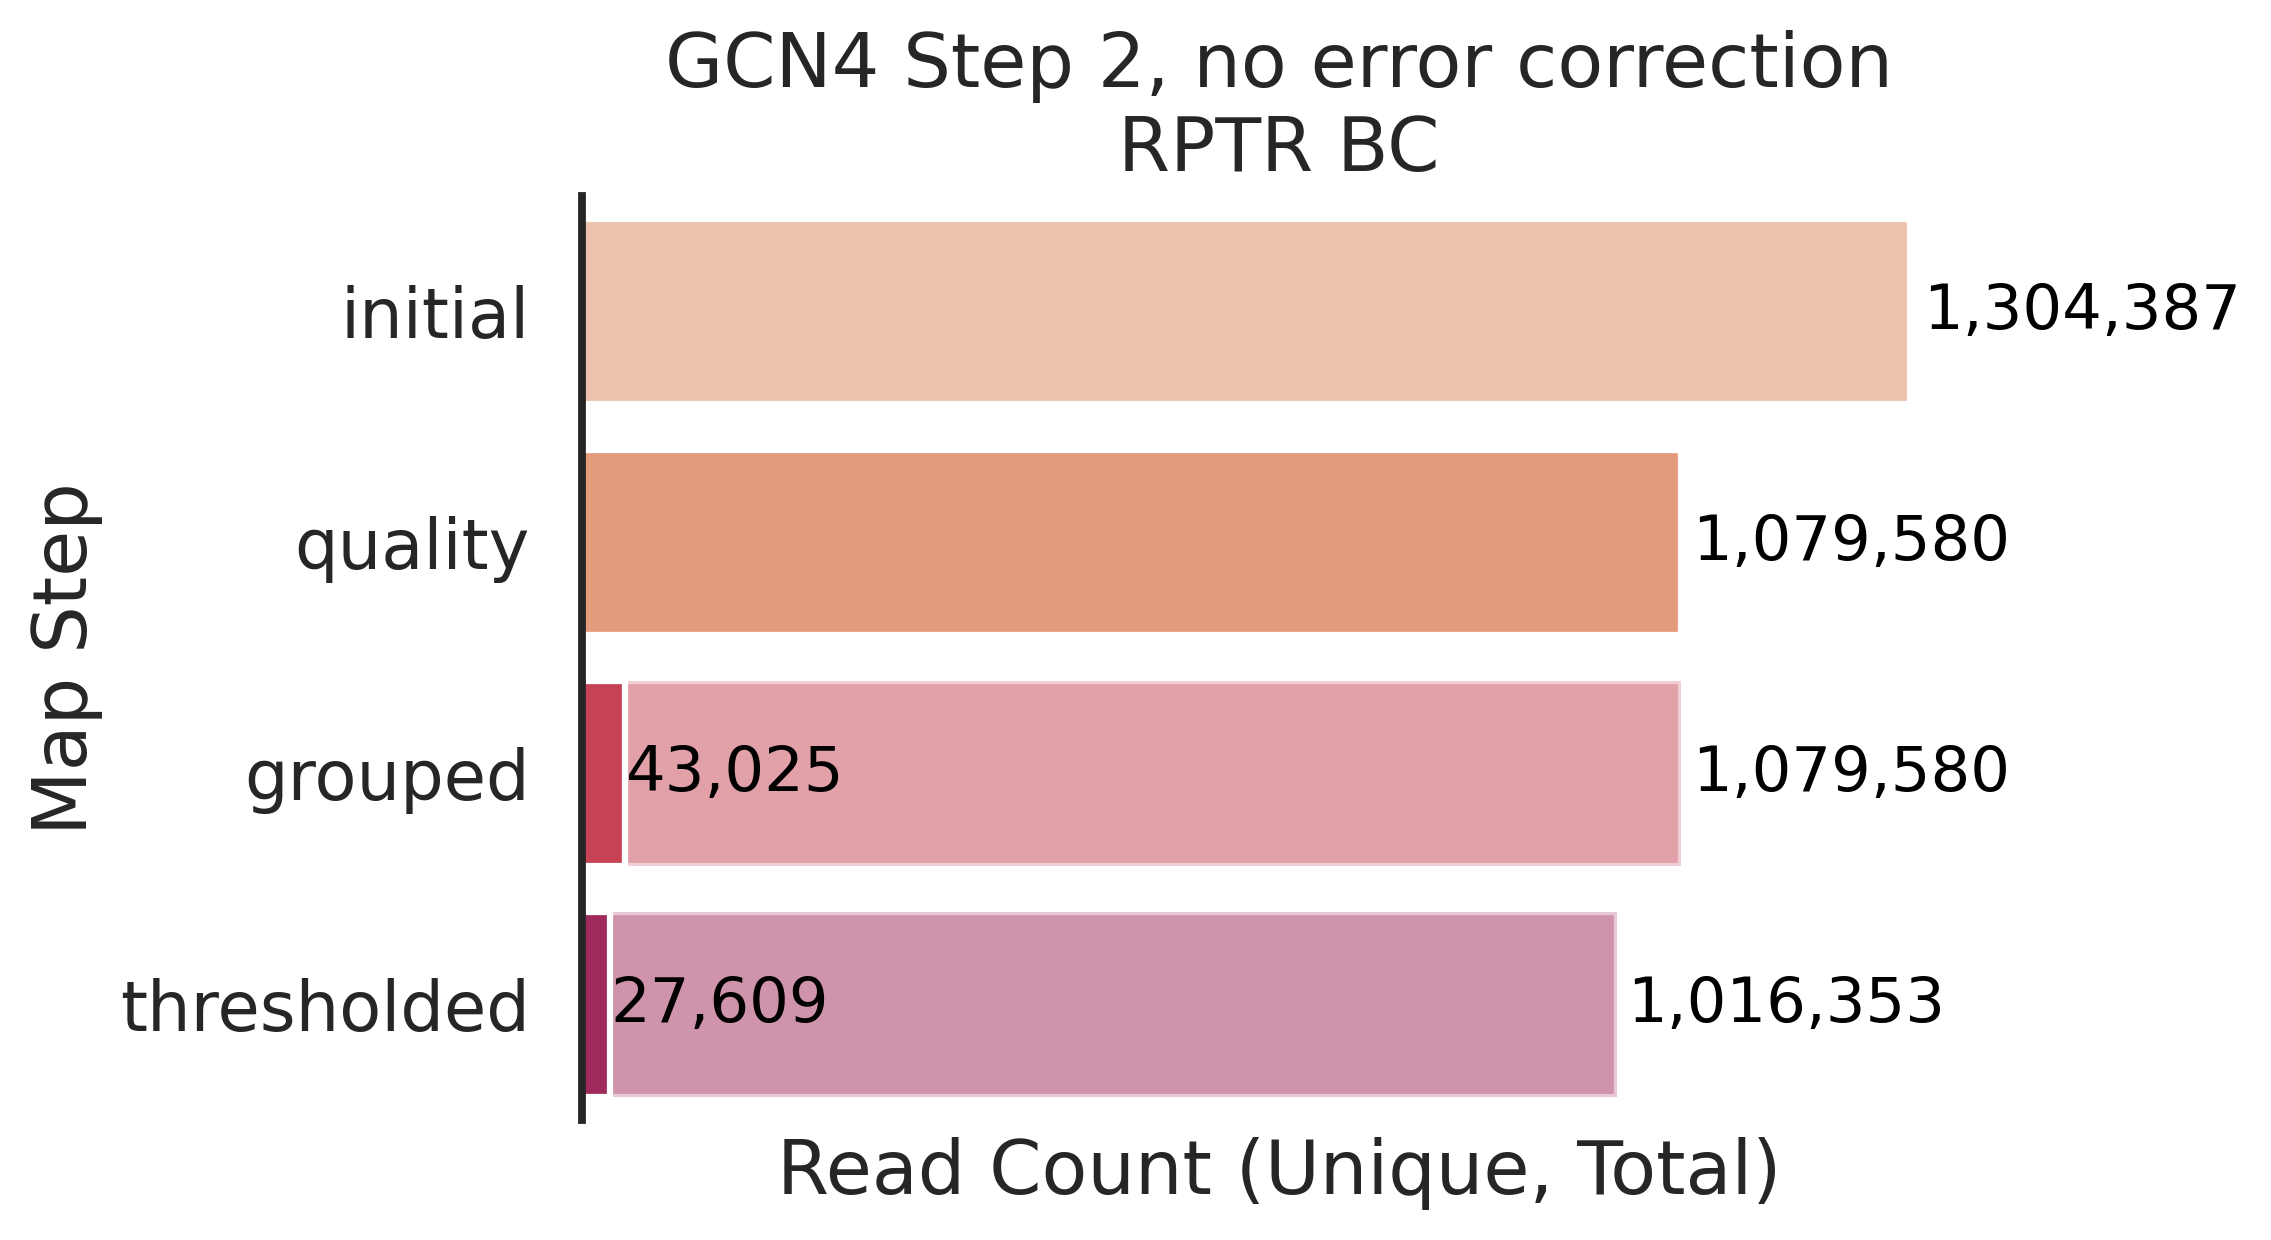

In [22]:
ax = step2_RPTR_refiner.plot_loss()
plt.title("GCN4 Step 2, no error correction\nRPTR BC")
plt.show()

In [39]:
complexity_checker = complexity.ComplexityChecker(db_path =db_path,
                                                  step_name = "step2",
                                                  step1_map_name = "step1_AD_AD_BC_RPTR_BC_designed", 
                                                  step_suffix = "designed",
                                                  barcode_groups = [(EC_AD, EC_AD_BC), (EC_RPTR_BC)])
complexity_checker.count_overlap()

BC_type  map_unique  step2  seen_in_both  percent_of_map_seen
0  AD,AD_BC      127383   5455          4730                3.713
1   RPTR_BC      126943  27609          9735                7.669

# TREBL Experiments

## Yeast Pool A: *** Need to save figures ***

### 1. AD + ADBC

In [23]:
yeast_pool_A_AD_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/*")
yeast_pool_A_RT_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/RPTR/*")
yeast_pool_A_output_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A" # May need to change to your directory due to writing permissions

In [24]:
yeast_pool_A_AD_seq_files

['/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/Staller_AD_3-10-1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/Staller_AD_3-5-2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/Staller_AD_3-240-1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/Staller_AD_3-0-2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20.fastq.gz.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/Ciber2_i/paired/assembled/AD/Staller_AD_3-240-1_67p

Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22
Reading 1 FASTQ/TXT file(s)...
Done in 0.84 seconds.

Reverse complement of sequences...
Done in 1.80 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})
CGCGCC(.{1,11})
Done in 4.02 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...
Done in 7.20 seconds.

Mapping complete.
trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_initial
Total rows: 285659


AD  AD_qual        AD_BC  \
0  TCTTCTGCTCCACCATCTACTTCATTTACTGATATGTCTACTCCAT...     True  TTTCCGGCCCT   
1  TCTAATGTTGAACAATCTCCATTGTTGCCAGAAGAAGAATTGGAAG...     True  AACCAATGGAC   
2  AATCATACTGCTACTGAAGCTAGACAGAATGCTTTGAATCATAGAT...     True  TAGTTAGTTTC   
3  CCAATTGCATTTGATCCAAATGATCCAGTTGCTGCTAAGAGAGCTA...     True  ATGTGAATGAT   
4  TTGGATAATTATACTAGAAGGAAATCTTCTGTTACTAATTCTCCAG...     True  GGATAGATCAC   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded
5. designed


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.40 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_quality...


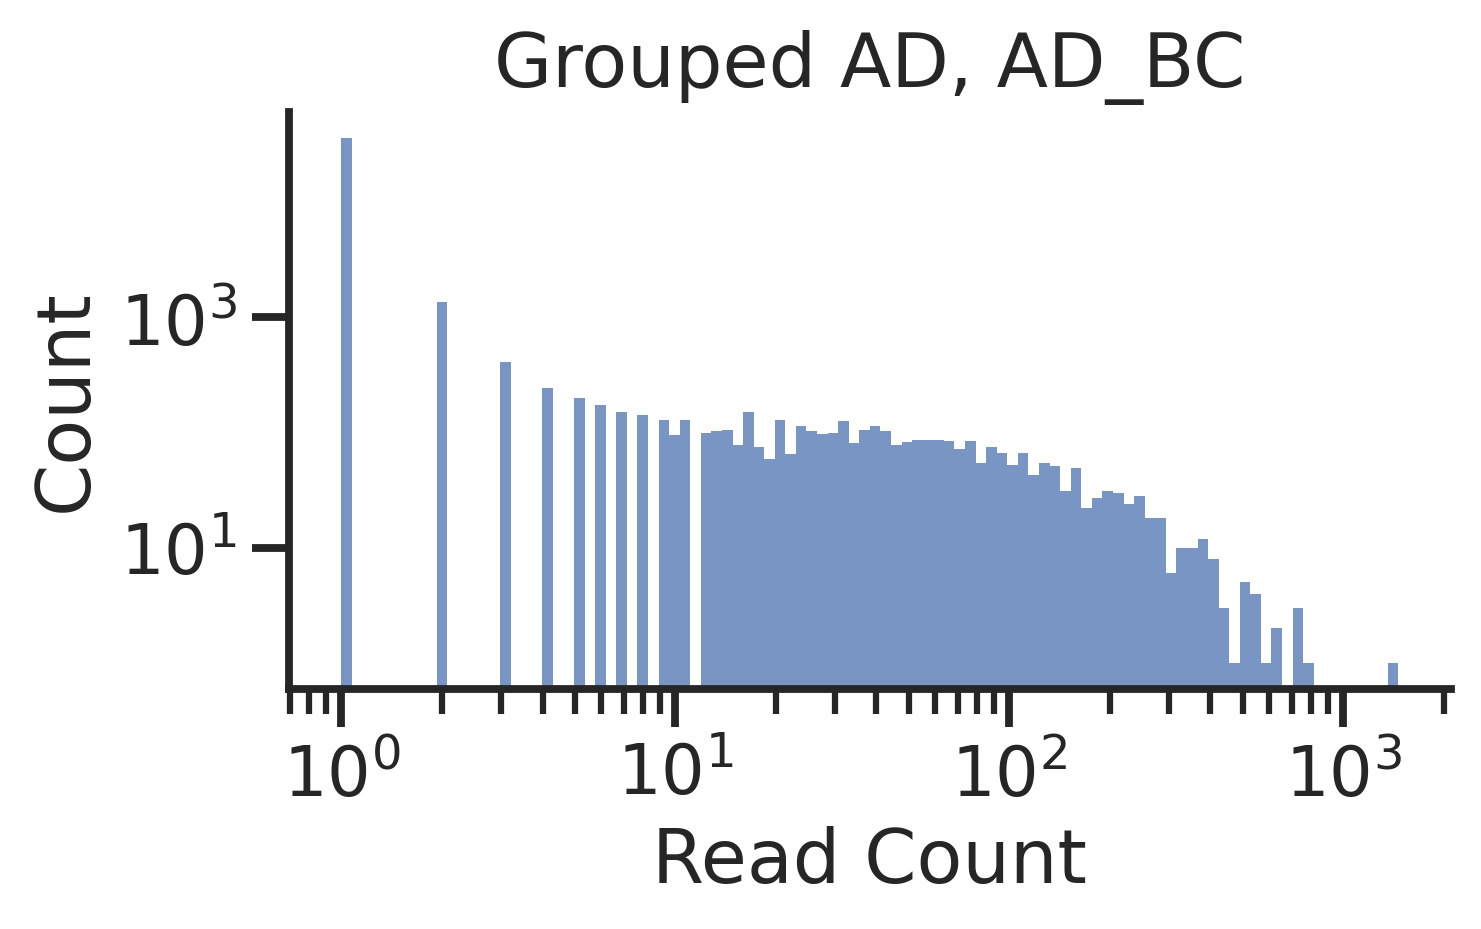

Done in 0.57 seconds.

Thresholding...
Using reads threshold of 20.


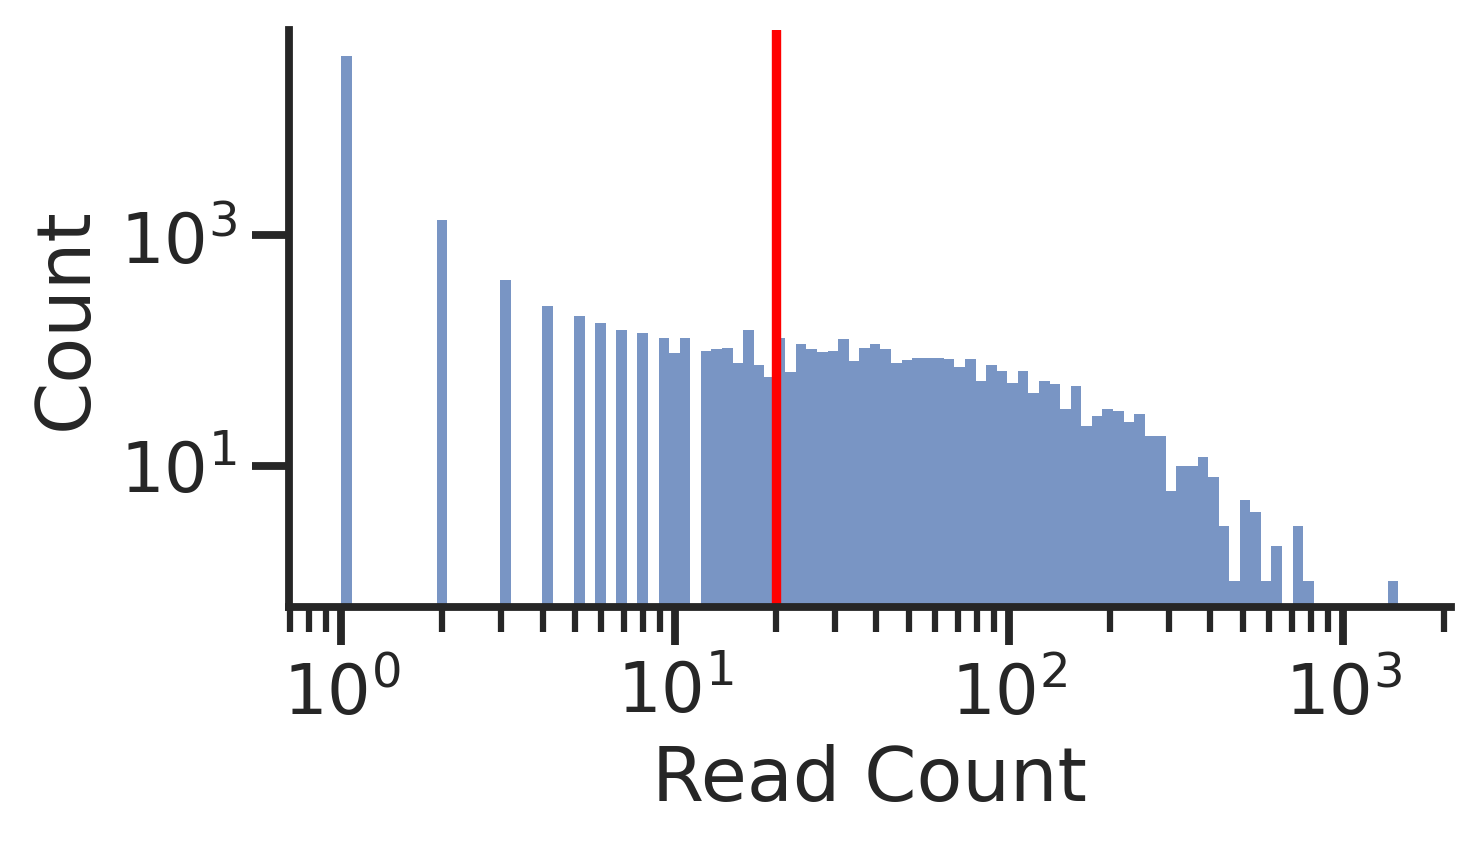

Done in 0.46 seconds.


Filtering to designed sequences...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_designed — kept only Designed == 1.
Done in 0.00 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_loss_summary'
Done in 0.08 seconds.

Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21
Reading 1 FASTQ/TXT file(s)...
Done in 0.65 seconds.

Reverse complement of sequences...
Done in 1.76 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})
CGCGCC(.{1,11})
Done in 4.74 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...
Done in 3.83 seconds.

Mapping complete.
trebl_experimen

AD  AD_qual        AD_BC  \
0  GATTCTTTGTTTGAATCTCAAGATTTGTTTGCTTCTCCAGTTAAAC...     True  CTCCACTGCCC   
1  ATTCATCCATTGTTGTCTACTCAACCATTGTTCTCTGCTTTGCCAC...     True  ATATGAGGTTT   
2  TCTAGAGCTAGGAAATTGCAAAGAATGAAACAATTGGAAGATAAAG...     True  TCCGTTTCCGC   
3  CCATATAAGAGGAAATTGCCAACTTCTGATCATAGACATCCATTGG...     True  AGCGTATTACA   
4  ACTTCTTCTGGTTTGAGATCTGTTAGAGAAGTTTCTGAACCAGTTA...     True  AACAAACCTCT   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded
5. designed


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.35 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_quality...


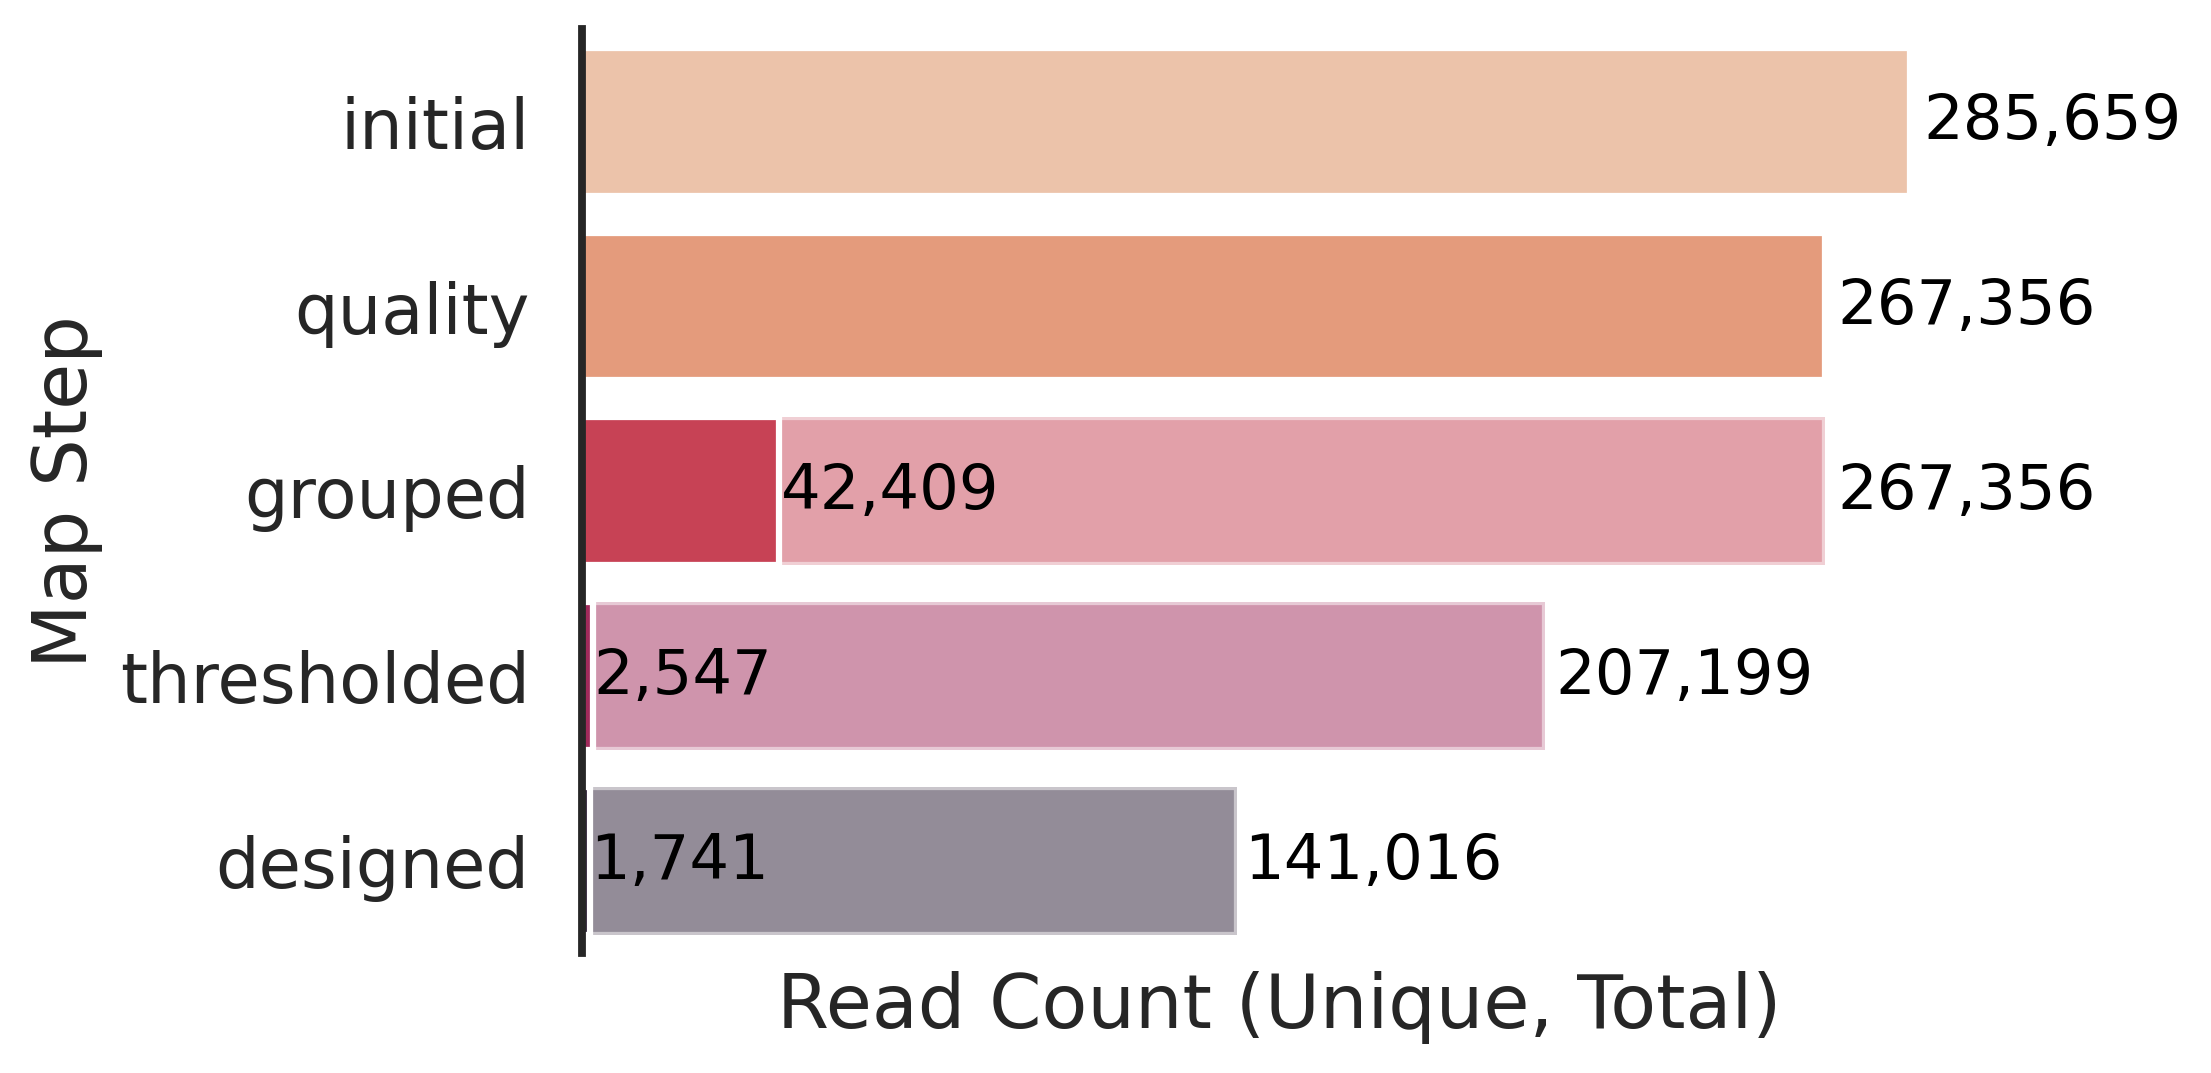

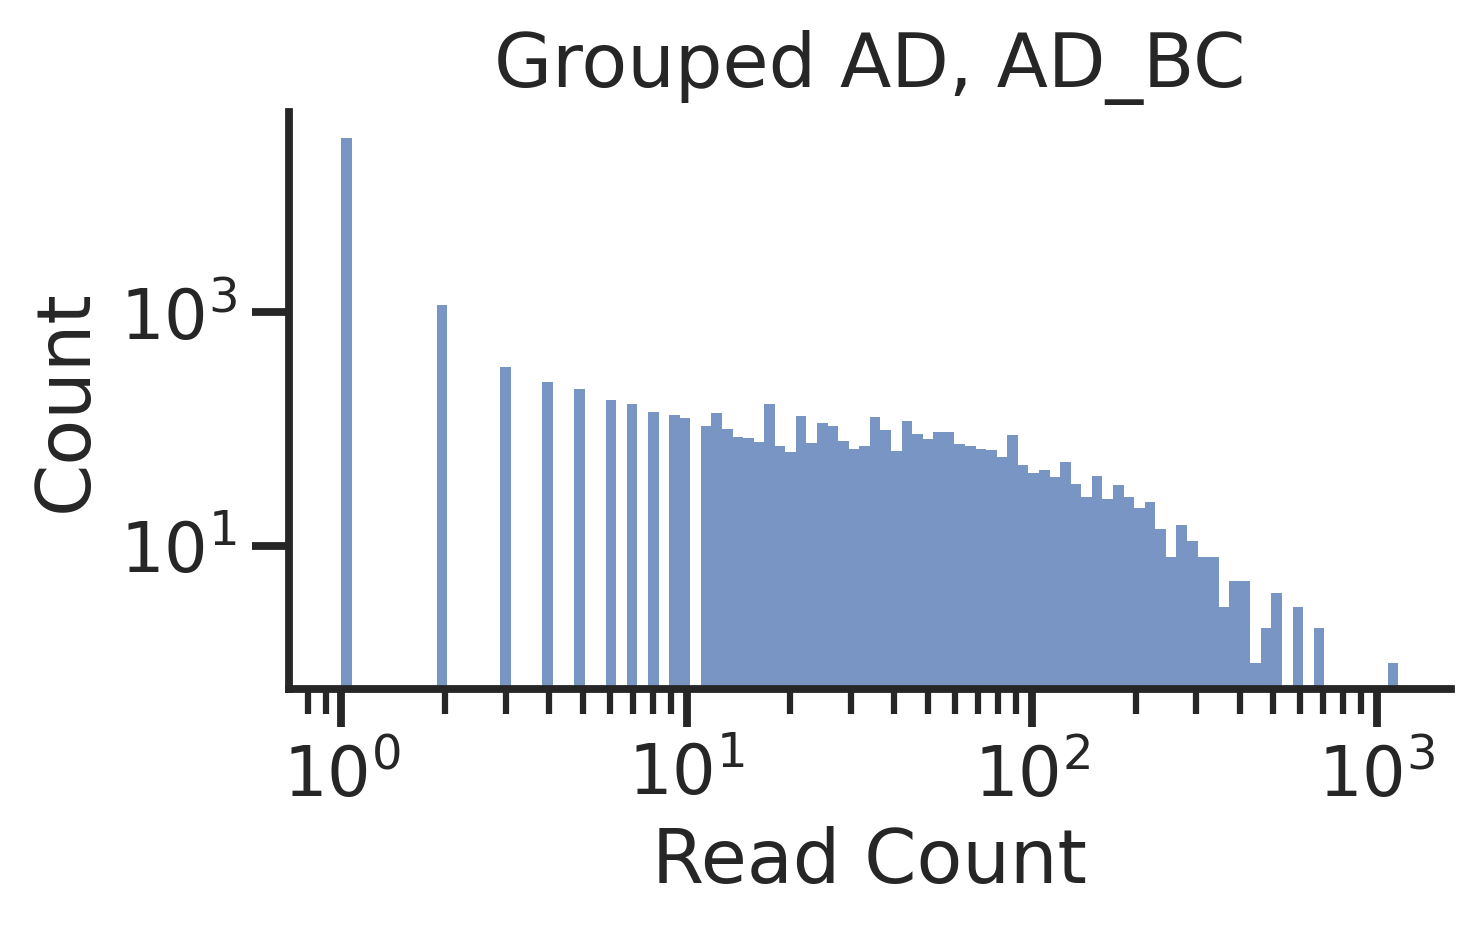

Done in 0.74 seconds.

Thresholding...
Using reads threshold of 20.


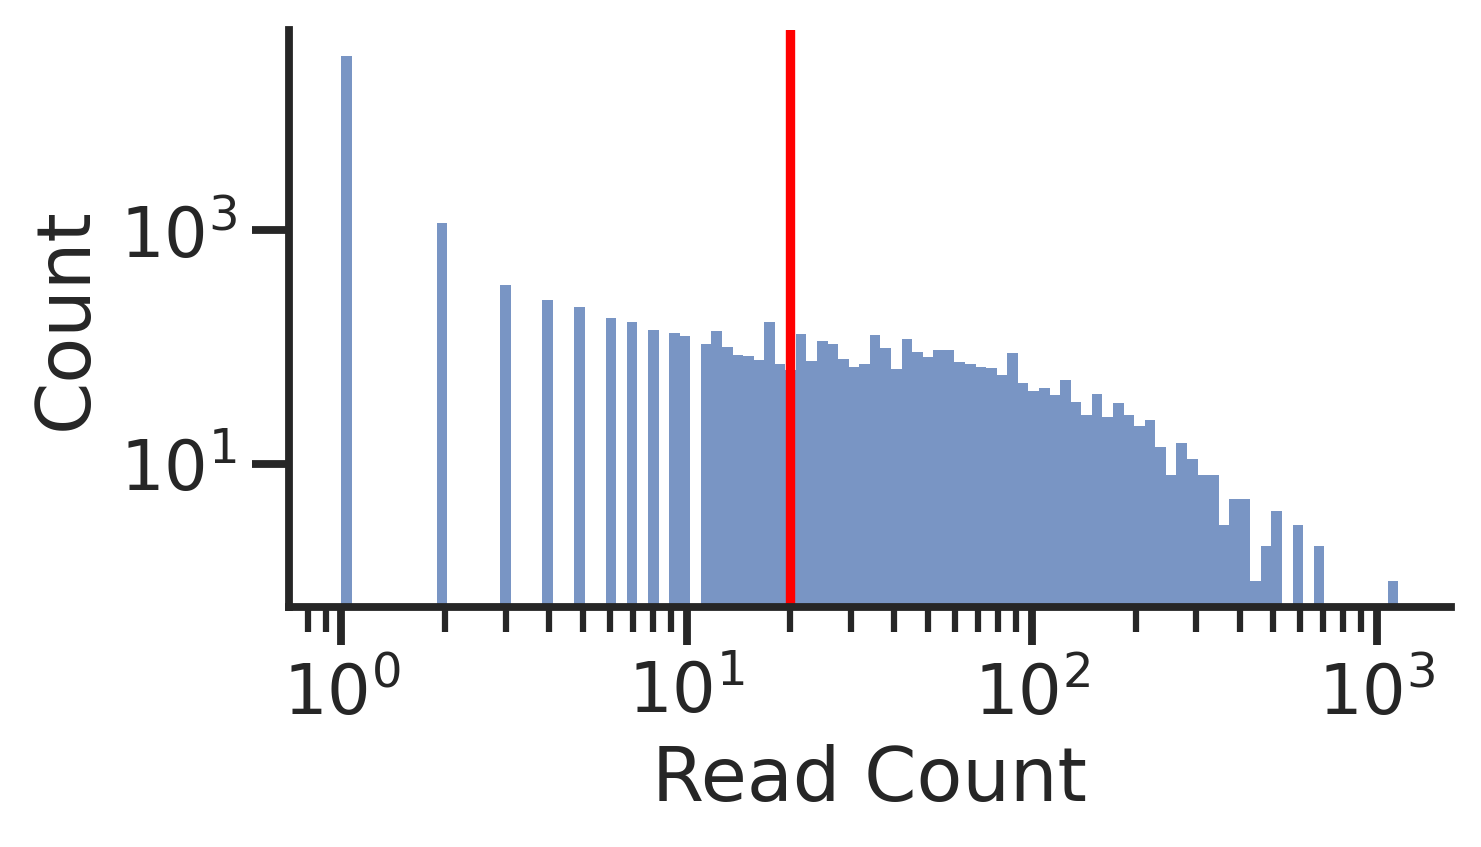

Done in 0.44 seconds.


Filtering to designed sequences...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_designed — kept only Designed == 1.
Done in 0.00 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_loss_summary'
Done in 0.08 seconds.

Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18
Reading 1 FASTQ/TXT file(s)...
Done in 0.92 seconds.

Reverse complement of sequences...
Done in 1.82 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})
CGCGCC(.{1,11})
Done in 7.16 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...
Done in 3.98 seconds.

Mapping complete.
trebl

AD  AD_qual        AD_BC  \
0  GACCCAATGTCTGCTTCTATTGGTACTGCTATGACTGTTTCTCCTA...     True  GTCCTCTGTCG   
1  GTTCCAATGGATTTGTTGGTTCATCATGATGATCATGATGGTTTGA...     True  CCTTGATCAGT   
2  TCTCCAATGTTTACTGATTTGGATGTTGCTGGTCATGAAGATTGGC...     True  TGAGTGTGAAC   
3  CCAGAATATAATGATAACTTTGATGTTTCTCCATTTGTTGGTAATA...     True  AGTGTCGCATT   
4  GATTCTTTGTTTGAATCTCAAGATTTGTTTGCTTCTCCAGTTAAAC...     True  CTCCACTGCCC   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded
5. designed


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.41 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_quality...


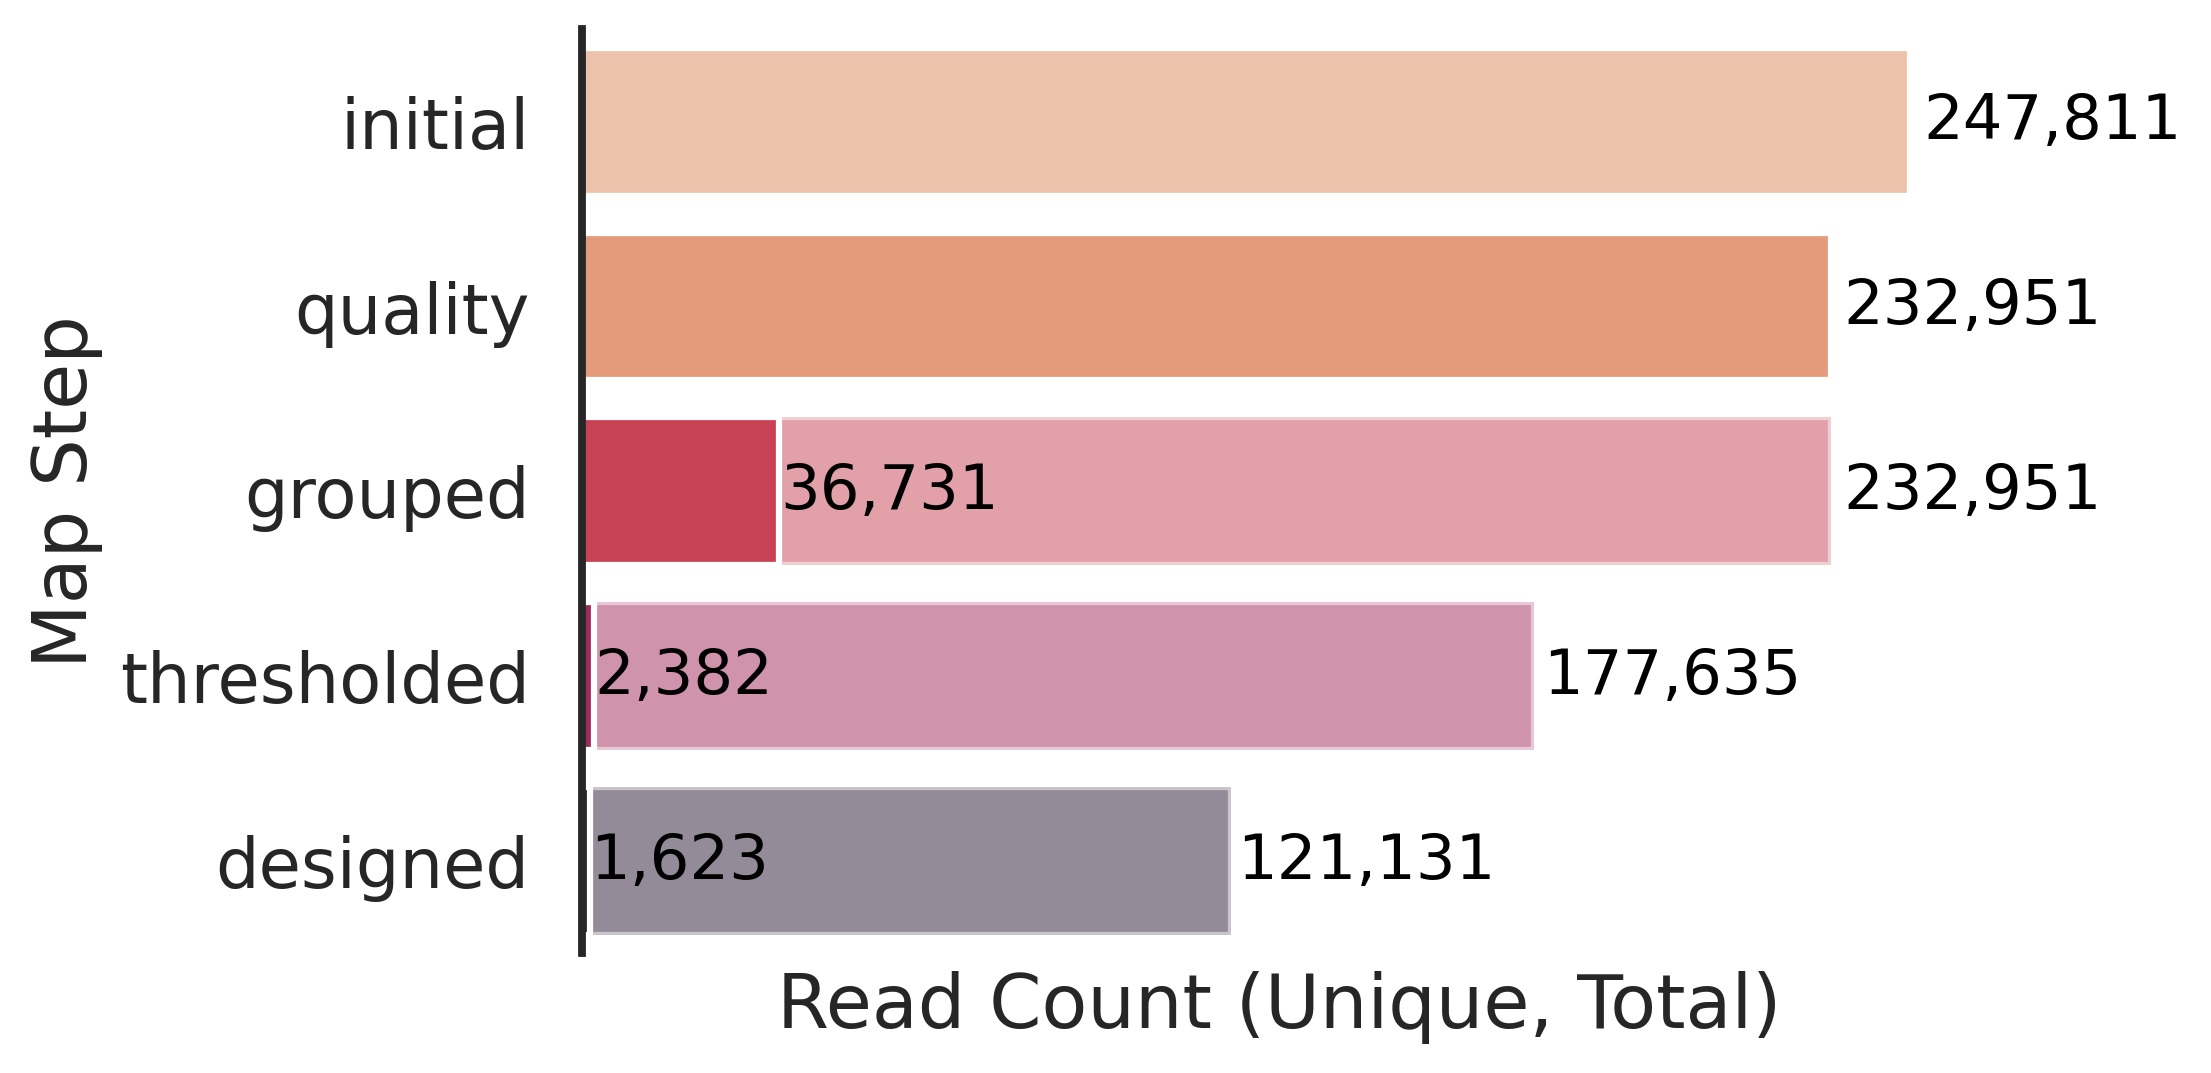

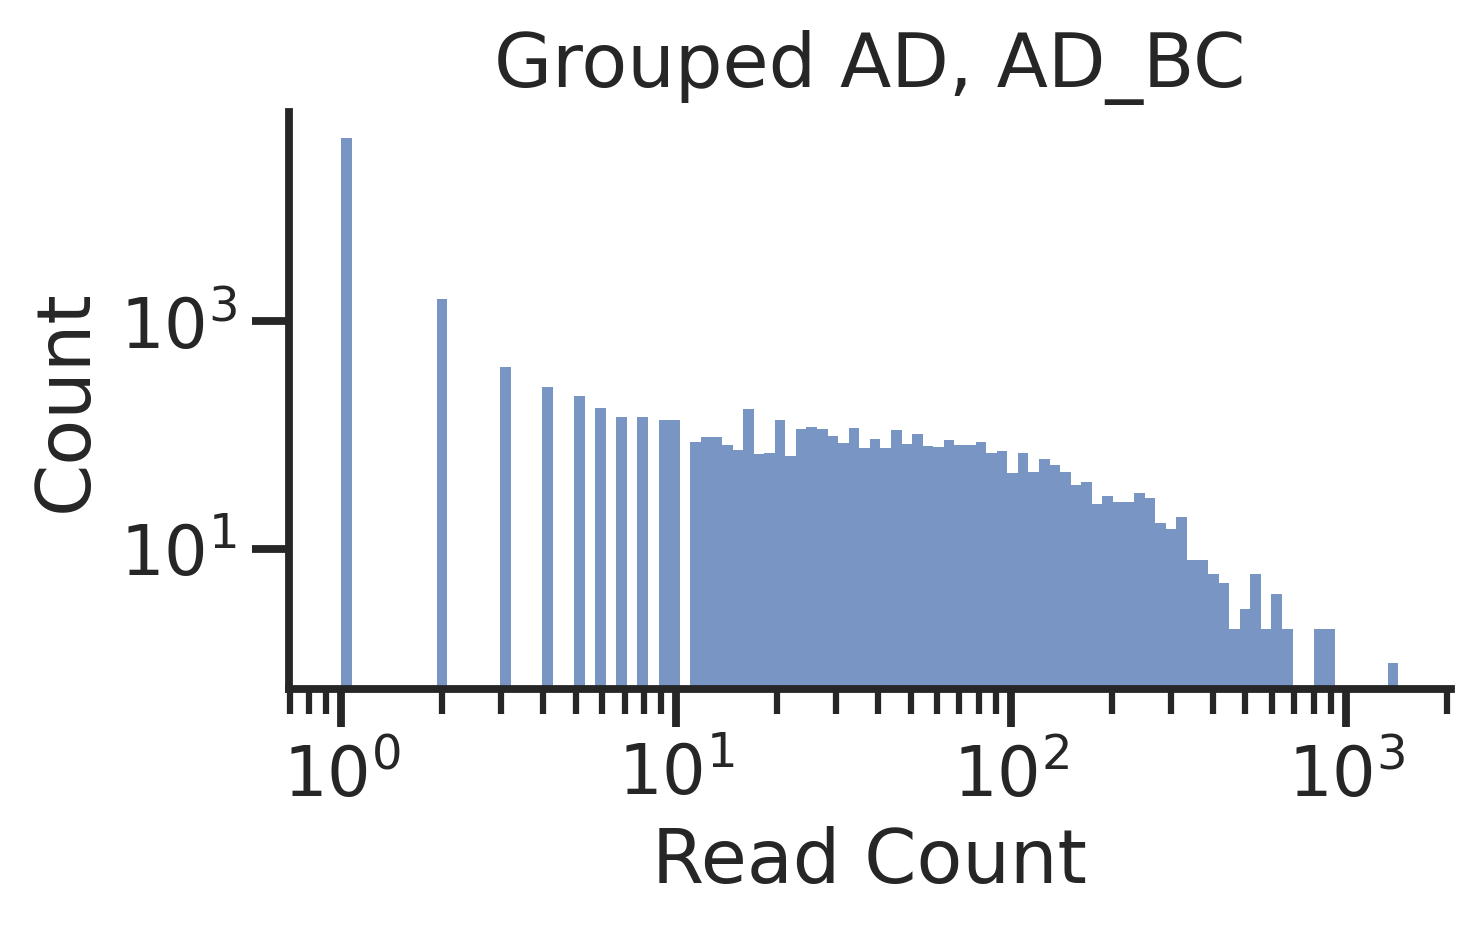

Done in 1.05 seconds.

Thresholding...
Using reads threshold of 20.


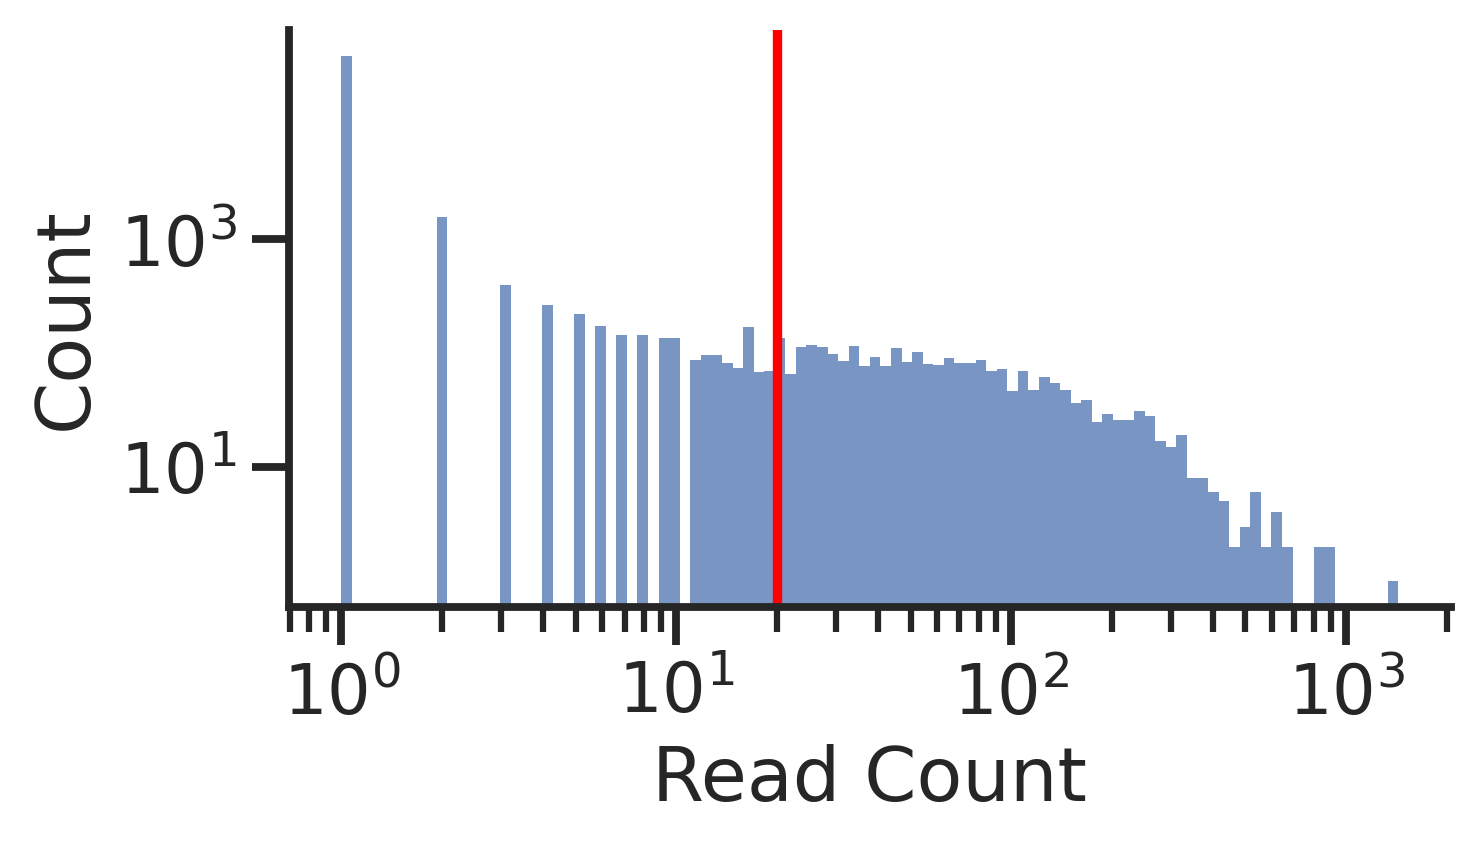

Done in 0.46 seconds.


Filtering to designed sequences...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_designed — kept only Designed == 1.
Done in 0.00 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_loss_summary'
Done in 0.08 seconds.

Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20
Reading 1 FASTQ/TXT file(s)...
Done in 0.79 seconds.

Reverse complement of sequences...
Done in 1.53 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})
CGCGCC(.{1,11})
Done in 7.19 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...
Done in 8.07 seconds.

Mapping complete.
trebl

AD  AD_qual        AD_BC  \
0  GGTGTTTCTTCTAGAAGAAGAGATAAACCATTGCCACCAATTATTG...     True  GCCTAACATCA   
1  AATTCTACTGCATTTACTAATTTGACTTCTCCATCTACTTATAATG...     True  ACGCCCGCCGC   
2  ATGTCTACTCCAAATATTCCACAAGGTGAATTGGGTTGTCCAGATA...     True  CCCTCCCCGAG   
3  ATCTTCTCTACTAATTTGGATGGTACTAATGATATTGATCATACTC...     True  TCGTCAAGAGA   
4  GTCTTTAATTTGGGTTATACTACTTCTTTGCCACCAGCTAGAAATT...     True  TTTGGTAACCG   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded
5. designed


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 3.32 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_quality...


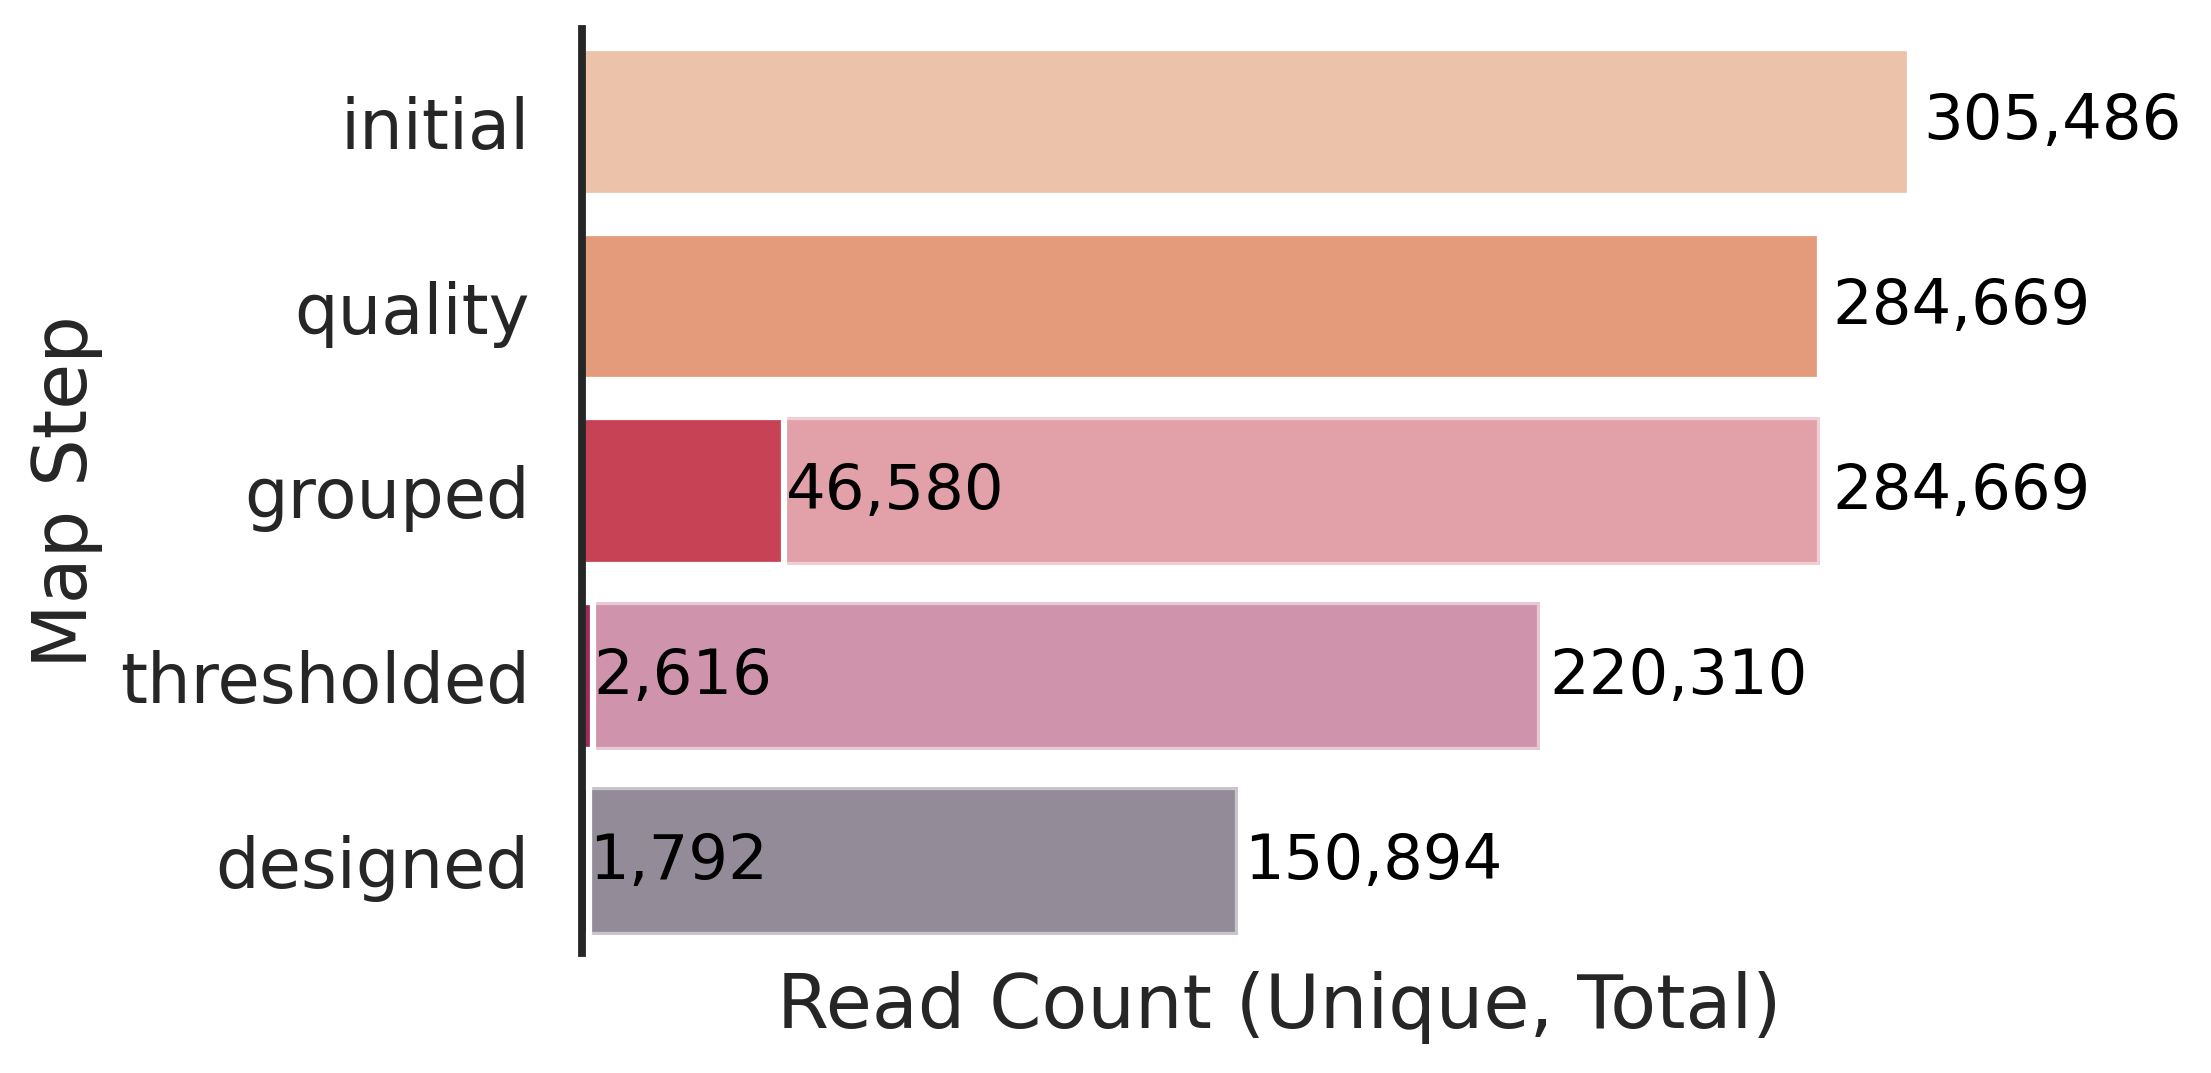

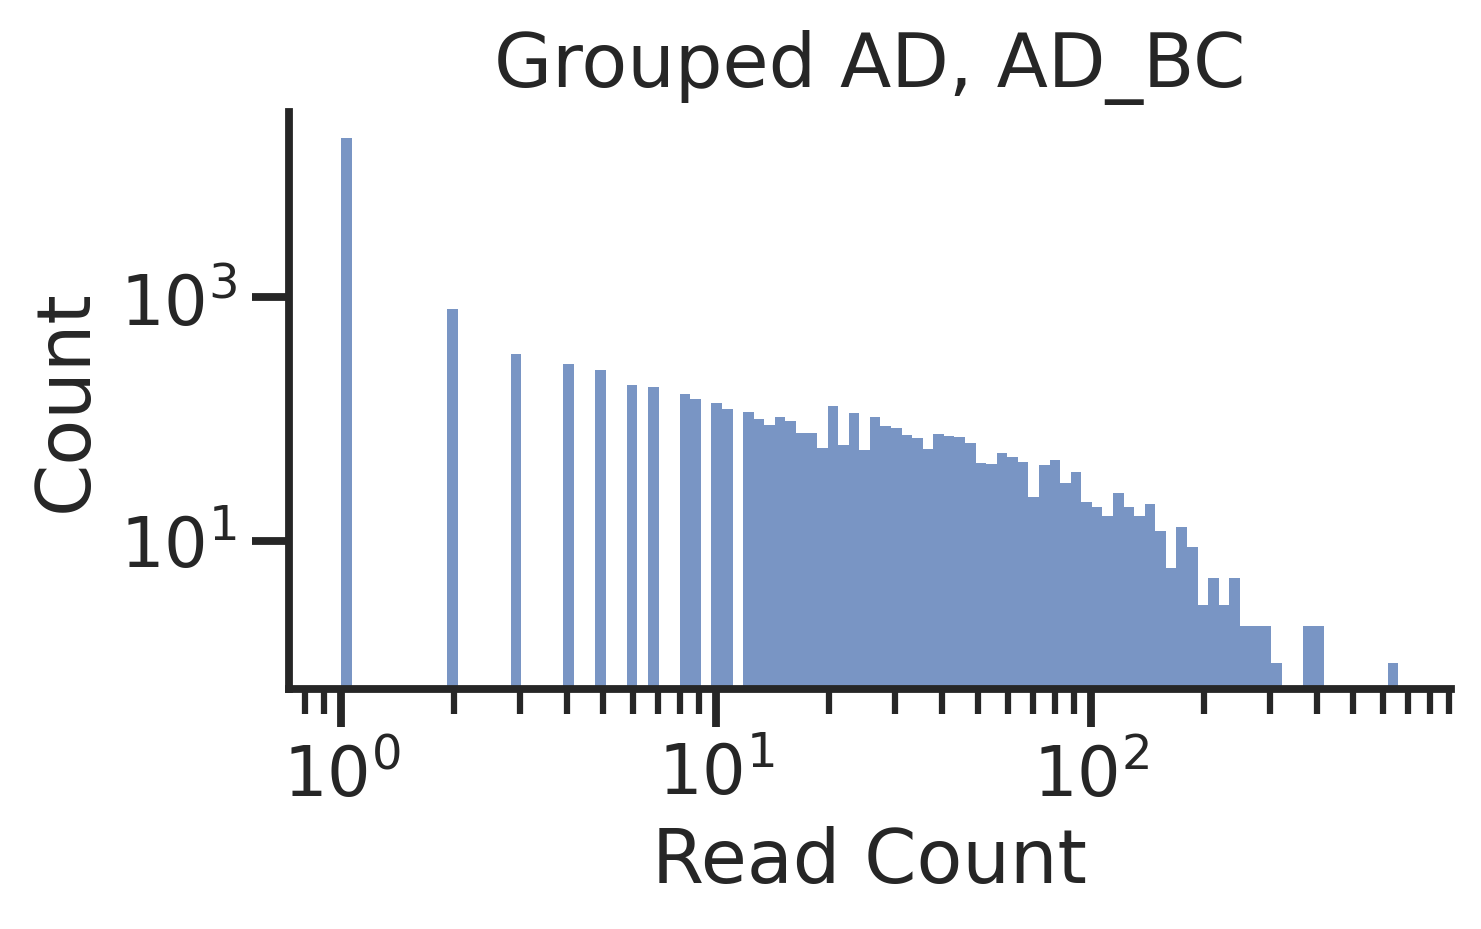

Done in 0.73 seconds.

Thresholding...
Using reads threshold of 20.


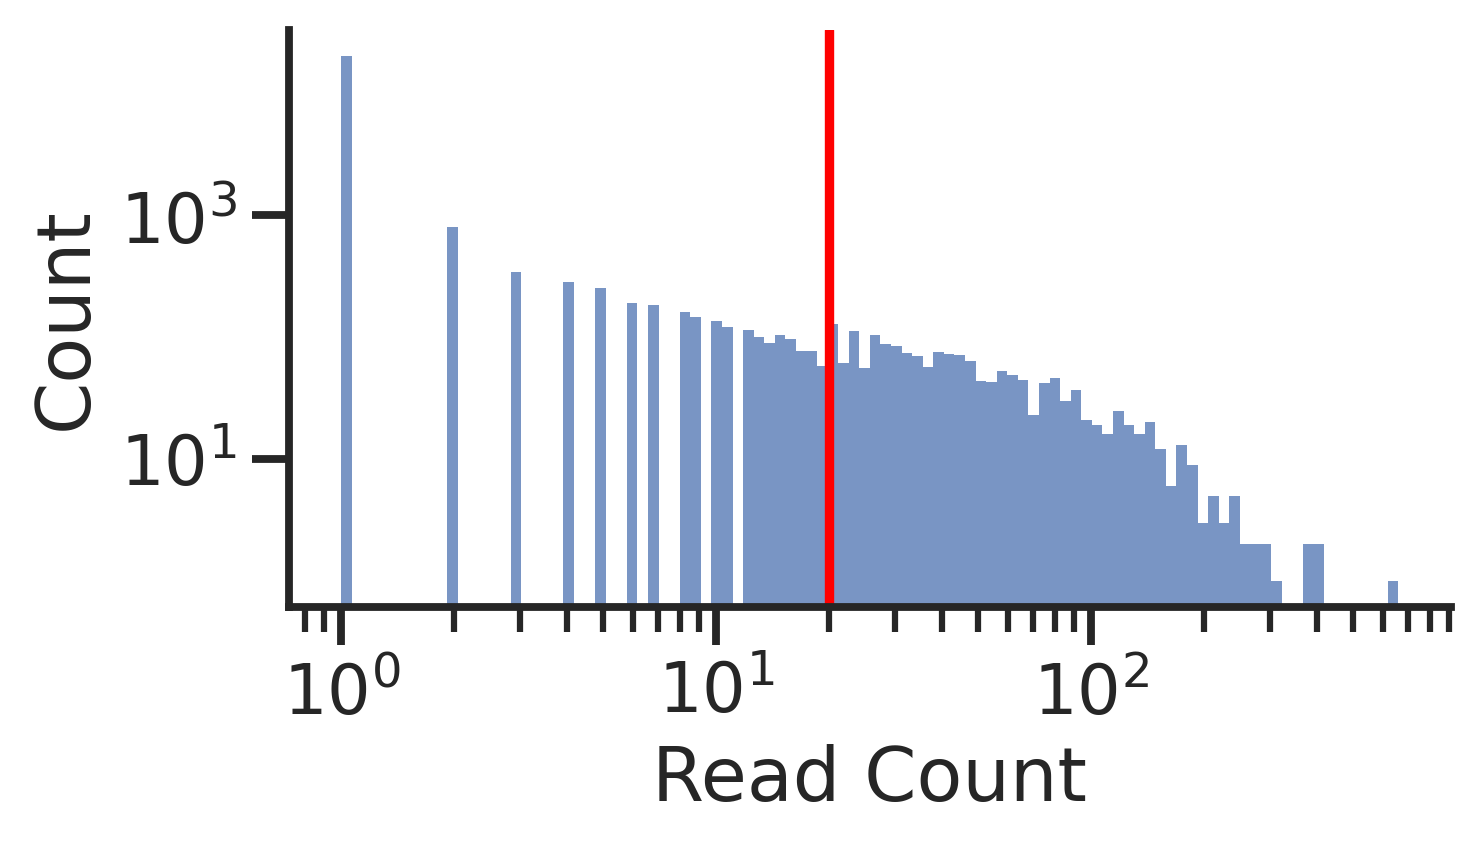

Done in 0.42 seconds.


Filtering to designed sequences...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_designed — kept only Designed == 1.
Done in 0.00 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_loss_summary'
Done in 0.07 seconds.

Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19
Reading 1 FASTQ/TXT file(s)...
Done in 6.43 seconds.

Reverse complement of sequences...
Done in 4.11 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})
CGCGCC(.{1,11})
Done in 3.92 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...
Done in 7.09 seconds.

Mapping complete.
trebl

AD  AD_qual        AD_BC  \
0  GCTAGAAATACTGAAGCTGCTAGAAGATCTAGAGCTAGGAAGATGG...     True  TAATAGCTTAC   
1  TTGACTTCTCCATCTTTGTATAATGGTTCTCCAGACTTTGATTCAT...     True  AGAGTTGCACT   
2  AAATCTCCAATTGTTGCTCCAGCTGAATTGGAAATTGCTGAAACTG...     True  TACAACCCTCC   
3  AGGAAAGGTTCTGTTACTGGTGCTGGTGTTAGGAAGAGAGTTGCTC...     True  ACATCGACGAG   
4  TTGCAACAAGACTTTGTCTTGTTTGATCAACAACCAACTCCACAAA...     True  TACCACCCAAC   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded
5. designed


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.36 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_quality...


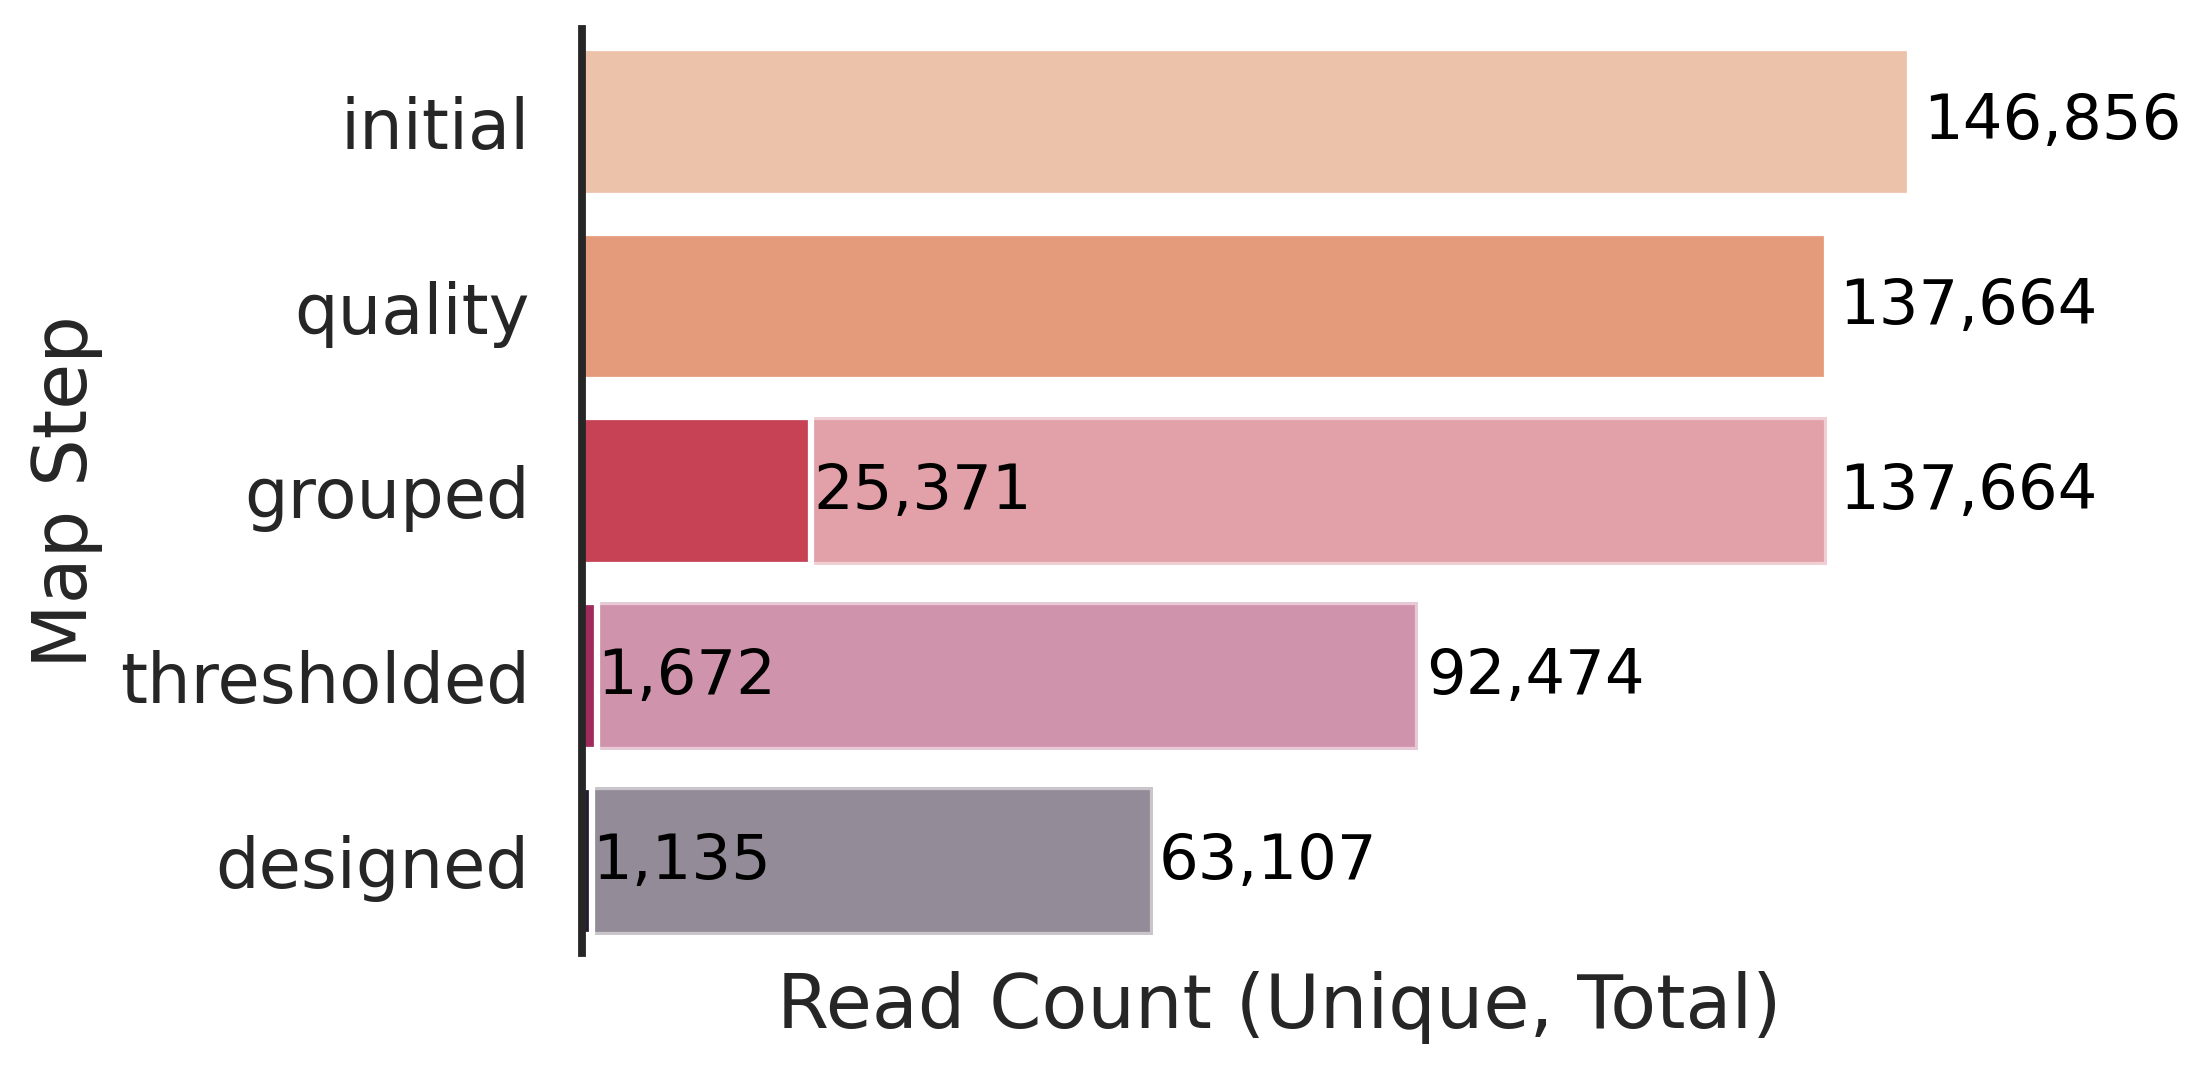

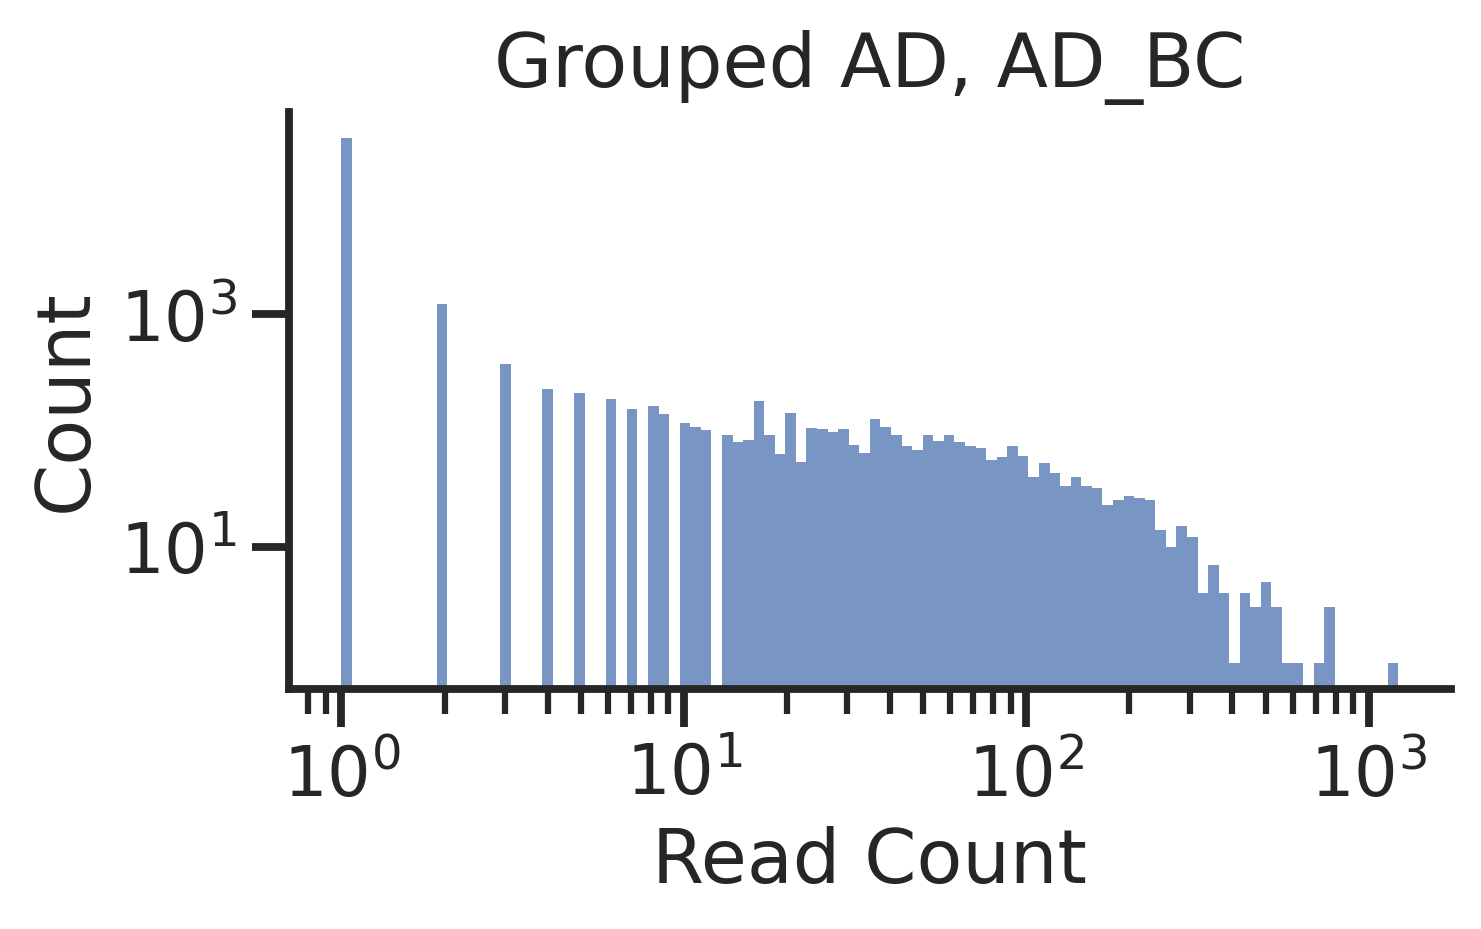

Done in 0.75 seconds.

Thresholding...
Using reads threshold of 20.


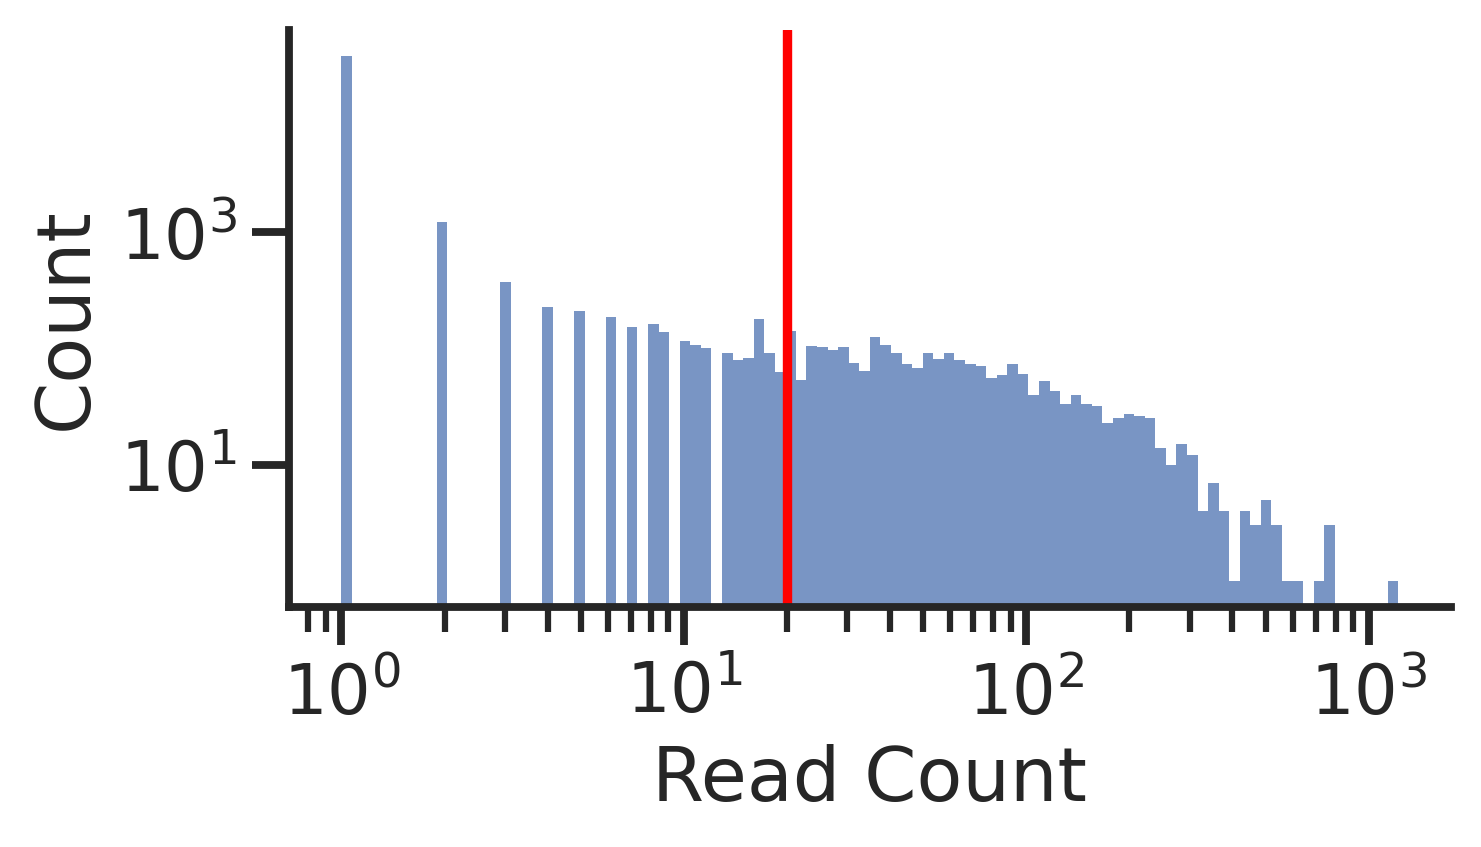

Done in 0.45 seconds.


Filtering to designed sequences...
Created table: trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_designed — kept only Designed == 1.
Done in 0.00 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_loss_summary'
Done in 0.08 seconds.



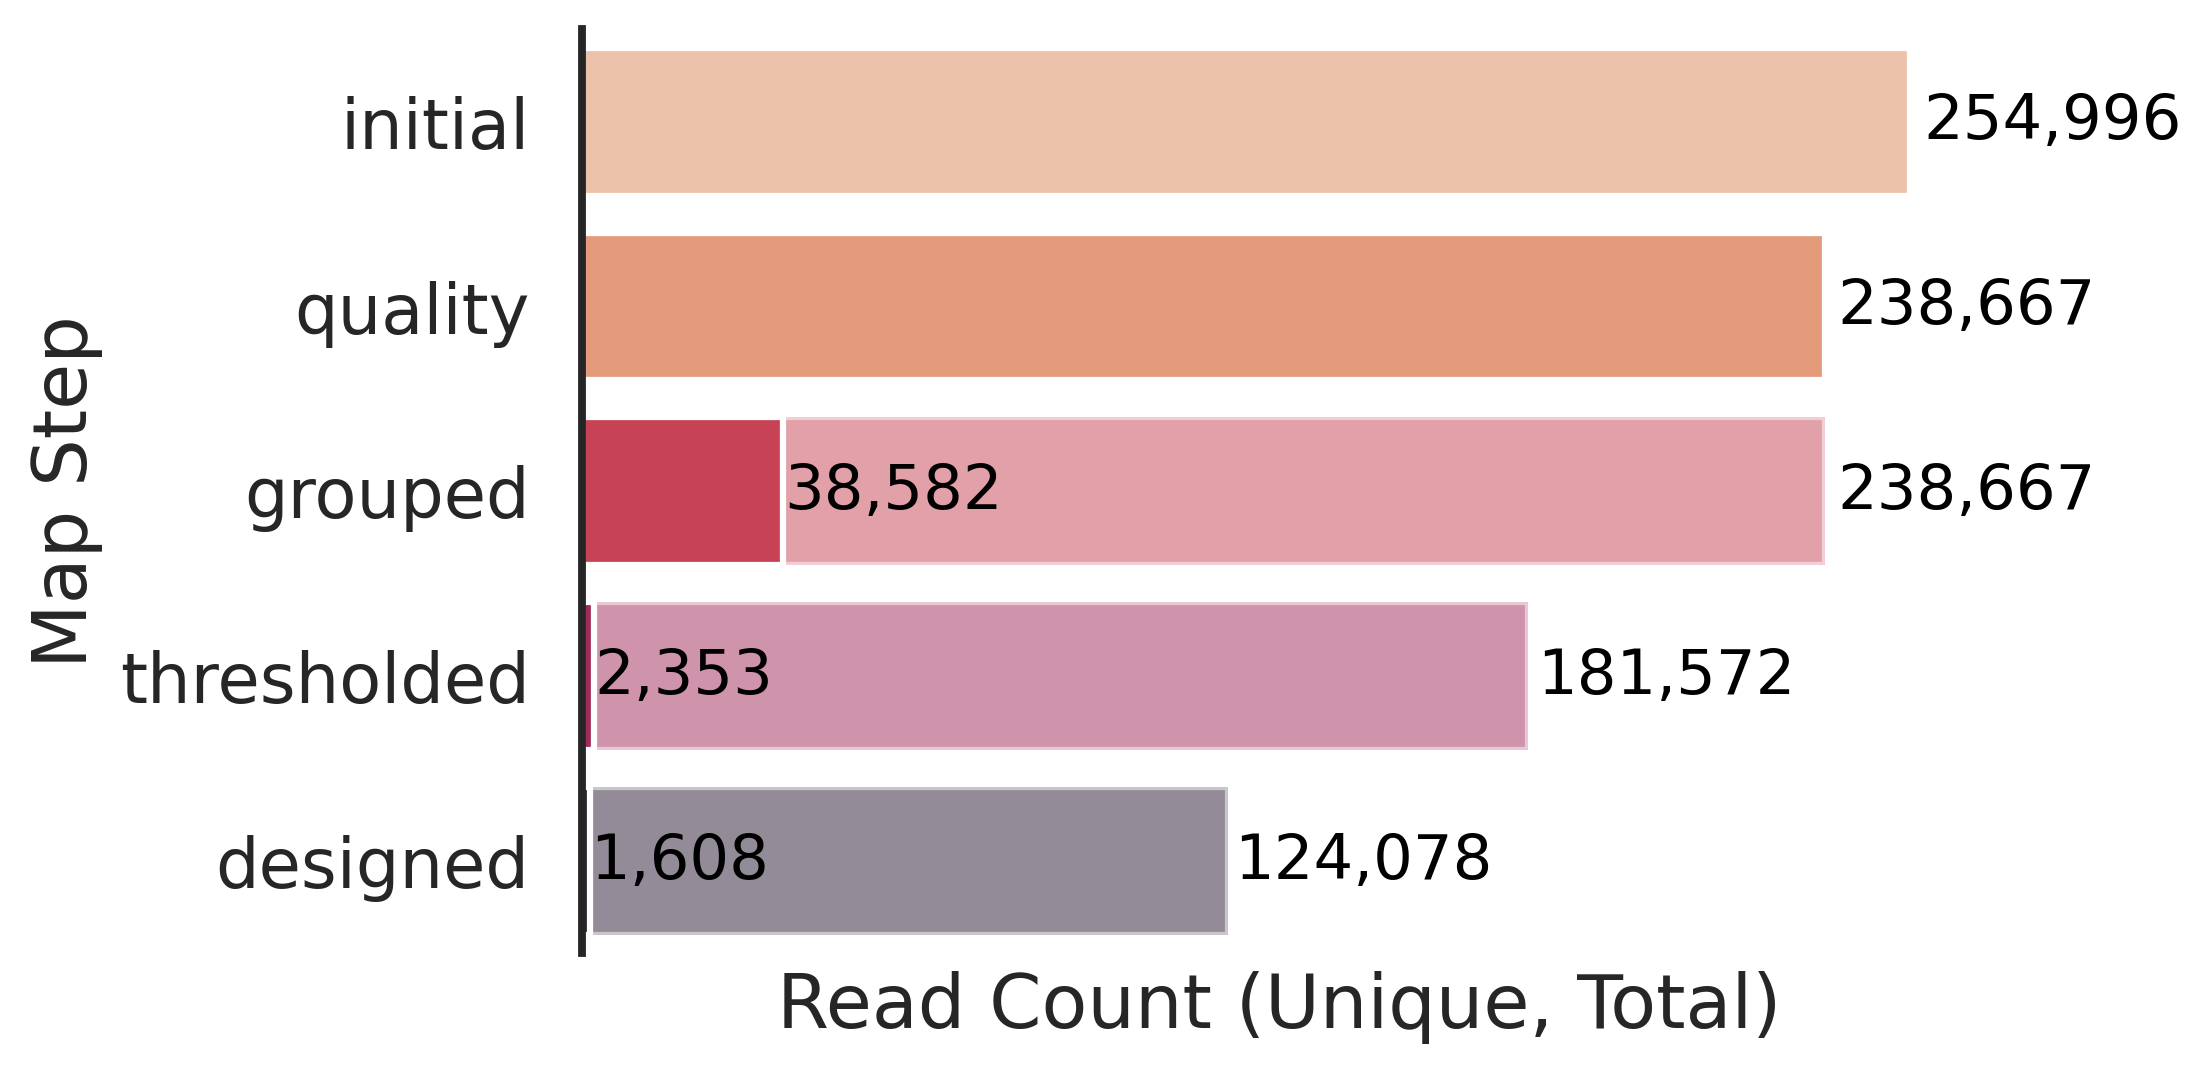

In [56]:

complex_AD_results = []
simple_AD_results = []

for file_path in yeast_pool_A_AD_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0].replace("-", "_") # Need this replace part because otherwise gets weird
    print(name_only) 

    # Get the file naeme to use for output
    file_output_path = os.path.join(yeast_pool_A_output_path, f"trebl_experiment_yeast_pool_A_{name_only}")
    print(file_output_path)

    # Extract UMIs and barcodes from reads
    bc_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"trebl_experiment_yeast_pool_A_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = "/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/A10_sequencing/v2/current/a10_designfile.csv",
                                       bc_objects = AD_objects,
                                       reverse_complement = True)
    umi_map = bc_mapper.create_map()
    display(bc_mapper.preview_map())

    # # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=AD_objects,
                                        column_pairs = [],
                                        map_order = ['quality', 'grouped', 'thresholded', 'designed'],
                                        step_name=f"trebl_experiment_yeast_pool_A_{name_only}", 
                                        descriptor = "",
                                    reads_threshold = 20)
    refiner.refine_map_from_db()
    refiner.plot_loss()
    

In [27]:
tables = refiner.show_tables()

yeast_pool_A_AD_result_tables = []
yeast_pool_A_AD_result_prefixes = []

for table in tables:
    if "trebl" in table[0] and "thresholded" in table[0] and "AD" in table[0] and "pool_A" in table[0]:
        print(table[0])
        yeast_pool_A_AD_result_prefixes.append(table[0])
        df = refiner.get_map_df(table[0])
        df["sample"] = table[0][38:]
        yeast_pool_A_AD_result_tables.append(df)

yeast_pool_A_AD_result_df = pd.concat(yeast_pool_A_AD_result_tables)
yeast_pool_A_AD_result_df

trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_thresholded


AD        AD_BC  count  \
0     GATTCTTTGTTTGAATCTCAAGATTTGTTTGCTTCTCCAGTTAAAC...  CTCCACTGCCC    660   
1     TCTCATACTACTACTGTTACTCAAACTGTTGTTTCTTCTAAACCAG...  CGTCCGATAAG    417   
2     GGTAATGTTCCACAAACTCCAAAATGGCTATGCAAGGTAAATTTCA...  CCAATCCTACT    411   
3     CAACCAAATCCATATTTGAGAGCTTTGGCTTTGTCTCCAACTCCAG...  TAGAATAAGAC    388   
4     GATCAATCTCCAGGTATCTTTGCTGGTGATGCTGTTATGGCTTCTG...  GTTTCTCGCTA    380   
...                                                 ...          ...    ...   
2377  GCTTCTCCAGCTTCTCCAAGAGCTAGAGATCTGTTGCTTCTTCTCC...  CCTGGACAGGG     21   
2378  GGTTCTGCTGCTGCTTTGCAATCAAAGAGTTGCTGCTATTATTCAA...  CCGACACAATG     21   
2379  GCTCCAAATTCTACTGCATTTACTAATTTGACTACTCCATCTATTA...  GCTCATGCGCC     21   
2380  GATTCTCCAGGTTACTTCTCTCAAGATACTTCTCCAATGTTTGCTA...  TAAAATGCGAG     21   
2381  TCTCCACCACAACAAGACTTTGTCTTGTTTGATTCTCCACAACCAC...  TTCCCGTTTGT     21   

      AD_qual  AD_BC_qual  Designed  \
0        True        True         1   
1        True        True         1   
2        True        True         0   
3        True        True         1   
4        True        True         1   
...       ...         ...       ...   
2377     True        True         0   
2378     True        True         0   
2379     True        True         0   
2380     True        True         0   
2381     True        True         1   

                                                 sample  
0     AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AG...  
1     AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AG...  
2     AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AG...  
3     AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AG...  
4     AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AG...  
...                                                 ...  
2377  AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GC...  
2378  AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GC...  
2379  AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GC...  
2380  AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GC...  
2381  AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GC...  

[11570 rows x 7 columns]

In [60]:
yeast_pool_A_AD_result_df["sample"].value_counts()

sample
AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_thresholded    2616
AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_thresholded         2547
AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_thresholded          2382
AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_thresholded    2353
AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_thresholded          1672
Name: count, dtype: int64

In [61]:
sum(yeast_pool_A_AD_result_df['count'])

879190

### 2. RPTR BC

Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25
Reading 1 FASTQ/TXT file(s)...
Done in 0.71 seconds.

Reverse complement of sequences...
Done in 1.59 seconds.

Extracting 1 barcodes...
CTCGAG(.{1,14})
Done in 0.24 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Done in 3.15 seconds.

Mapping complete.
trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_initial
Total rows: 277049


RPTR_BC  RPTR_BC_qual  Designed
0  TTTTCTGTNTATCA          True         1
1  ATATGGAAGTANAT          True         1
2  GAGACTCATATANA          True         1
3  TTTGTATCNTTTAG          True         1
4                         False         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.09 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_quality...


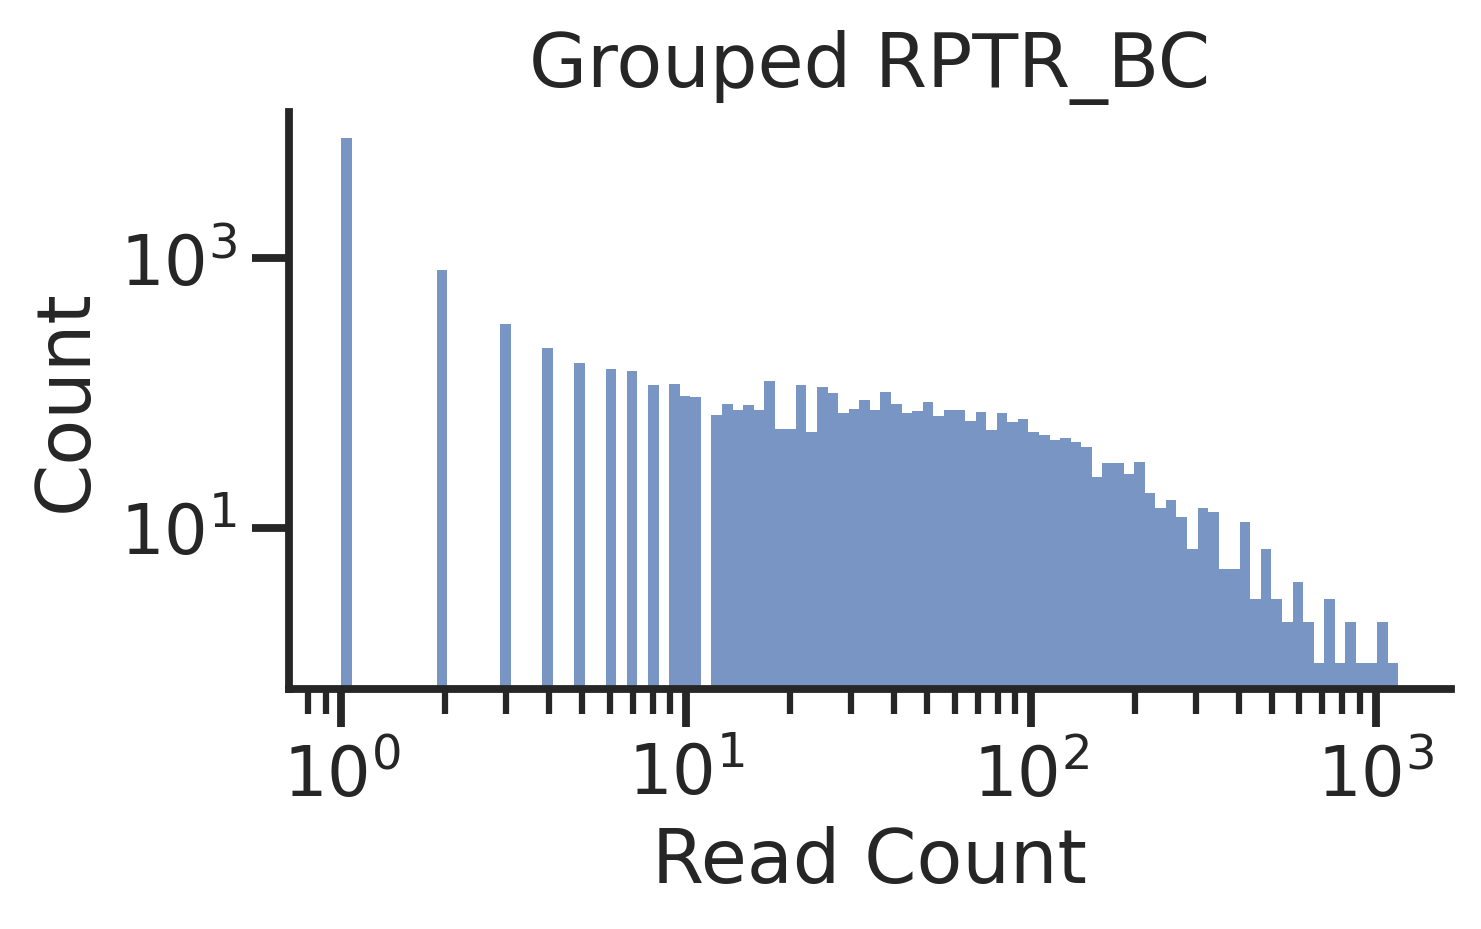

Done in 0.77 seconds.

Thresholding...
Using reads threshold of 20.


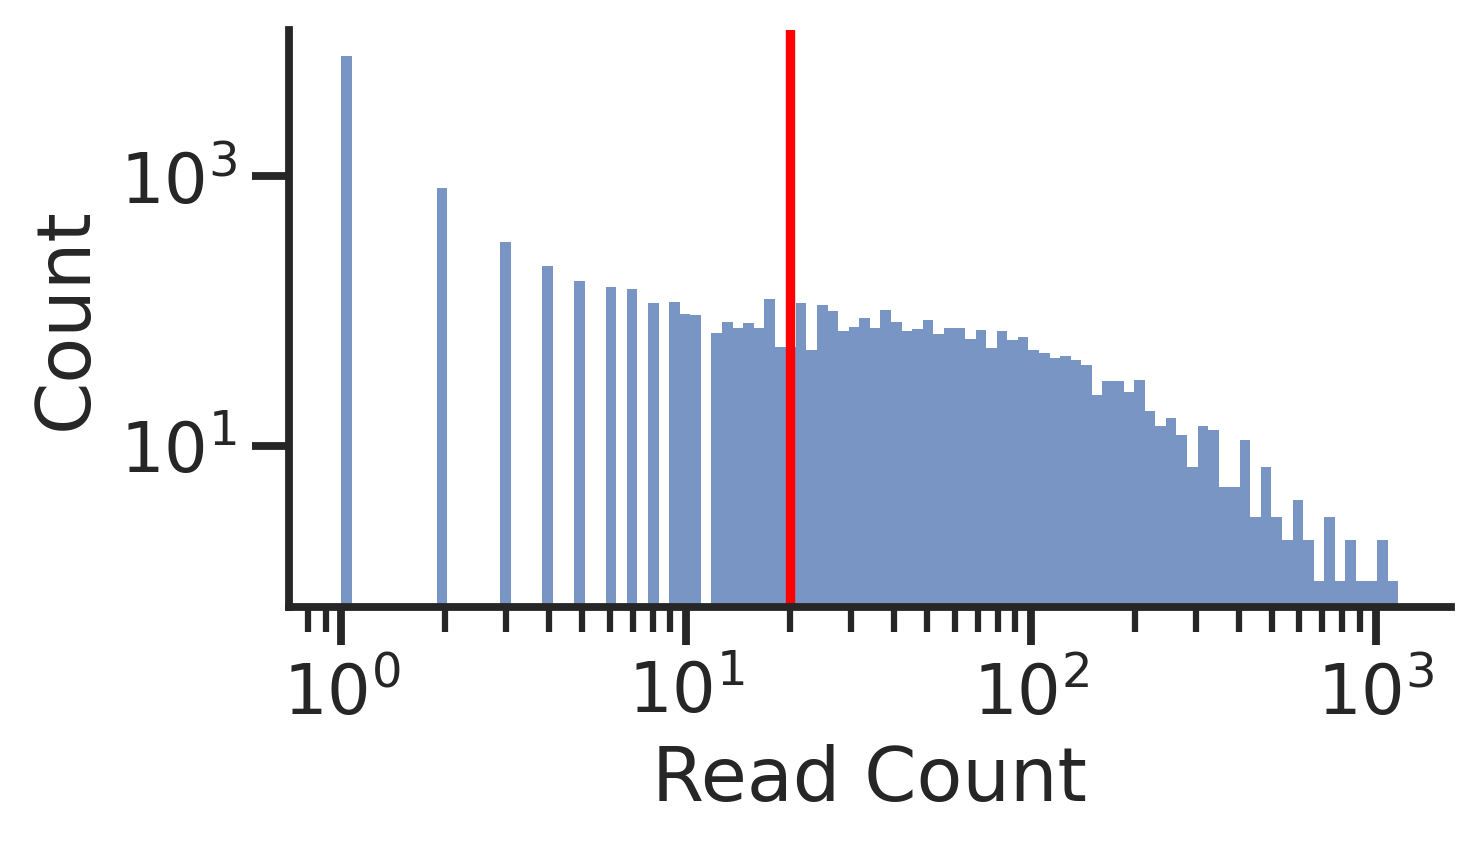

Done in 0.45 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_loss_summary'
Done in 0.02 seconds.

Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24
Reading 1 FASTQ/TXT file(s)...
Done in 1.02 seconds.

Reverse complement of sequences...
Done in 1.84 seconds.

Extracting 1 barcodes...
CTCGAG(.{1,14})
Done in 0.28 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Done in 3.35 seconds.

Mapping complete.
trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_initial
Total rows: 368875


RPTR_BC  RPTR_BC_qual  Designed
0  GGACCGGANGTGAG          True         1
1  TGCGTGGGTTACNT          True         1
2  TCAGCATCCAANAC          True         1
3  AATGCGTTAGGNGG          True         1
4                         False         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.13 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_quality...


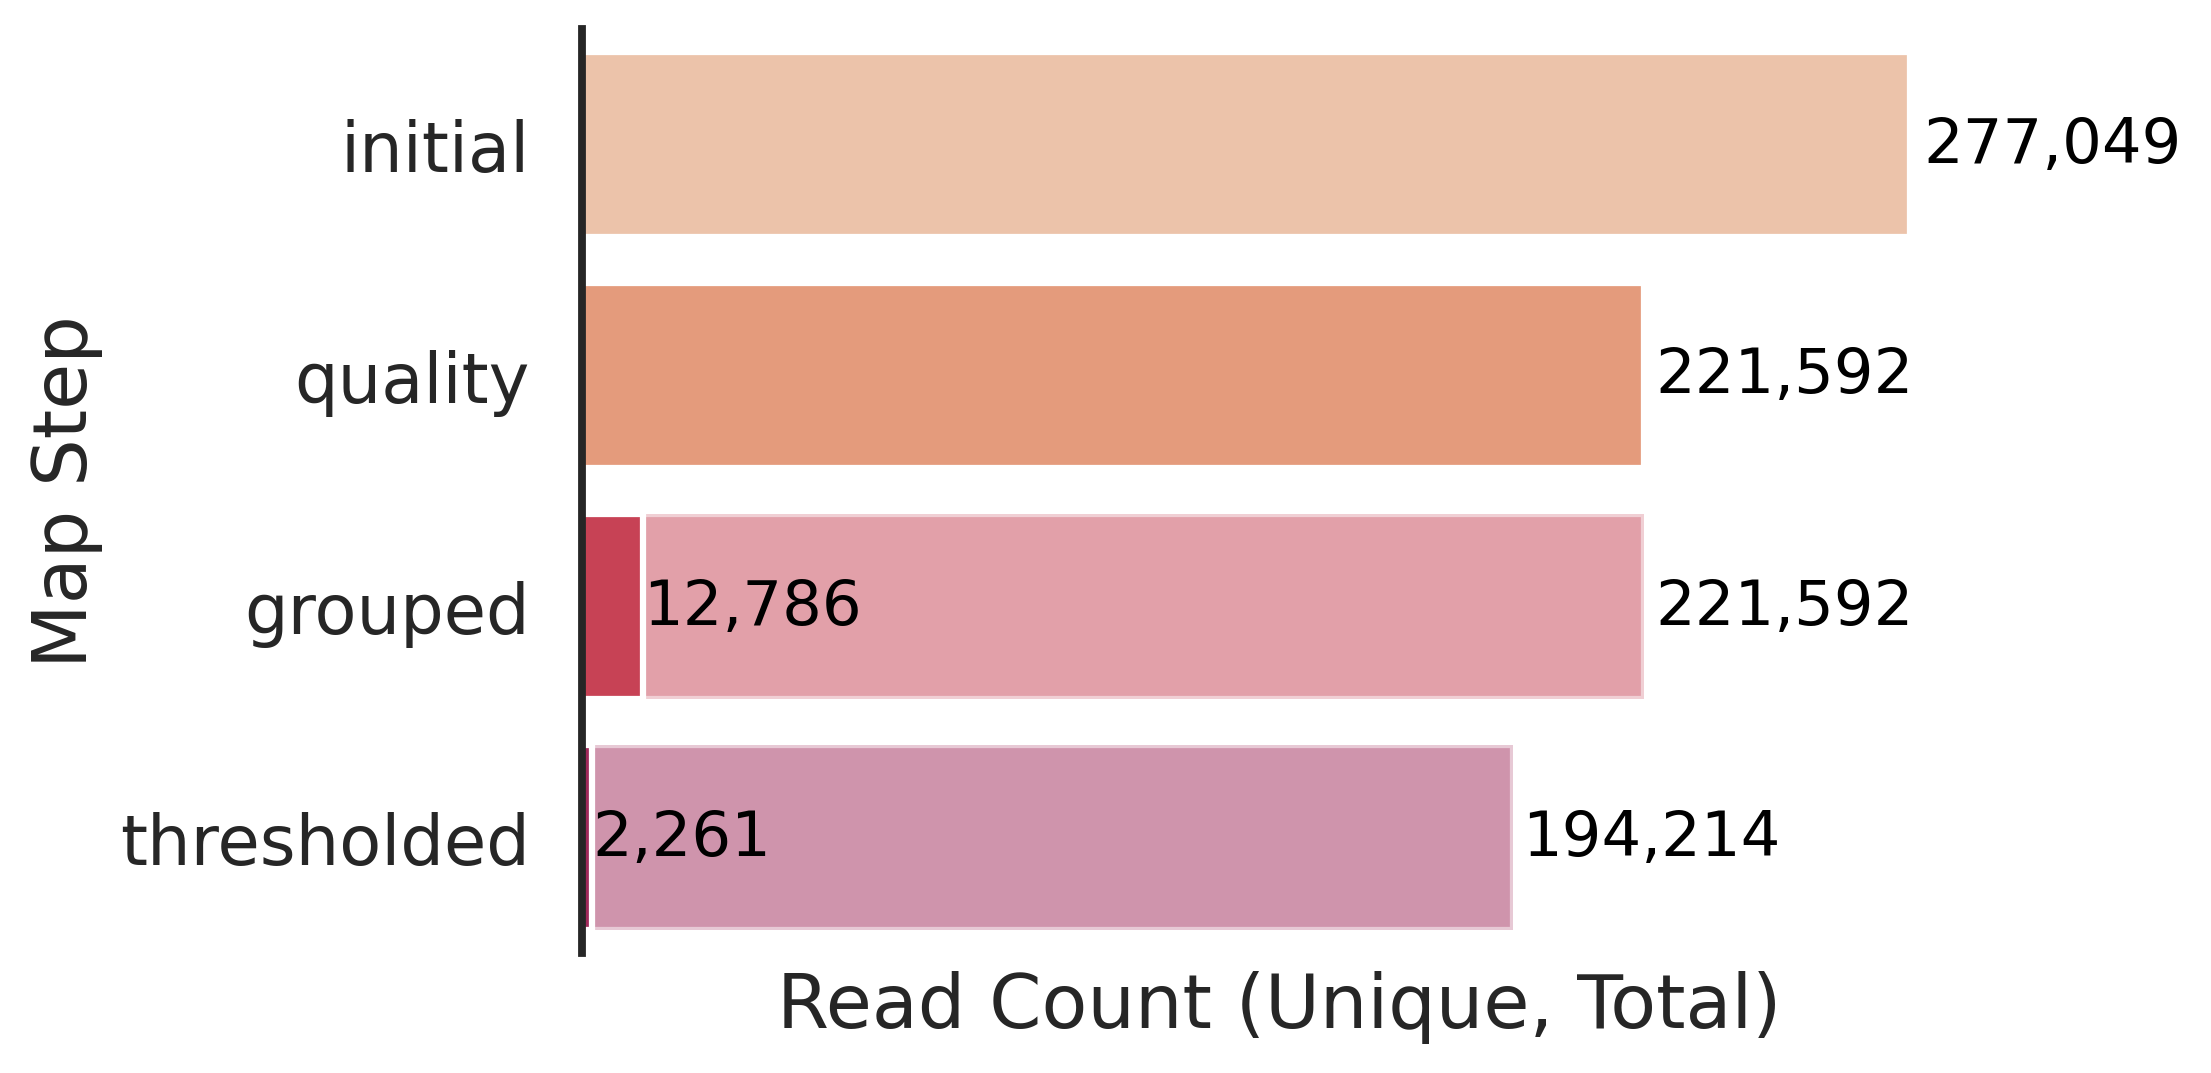

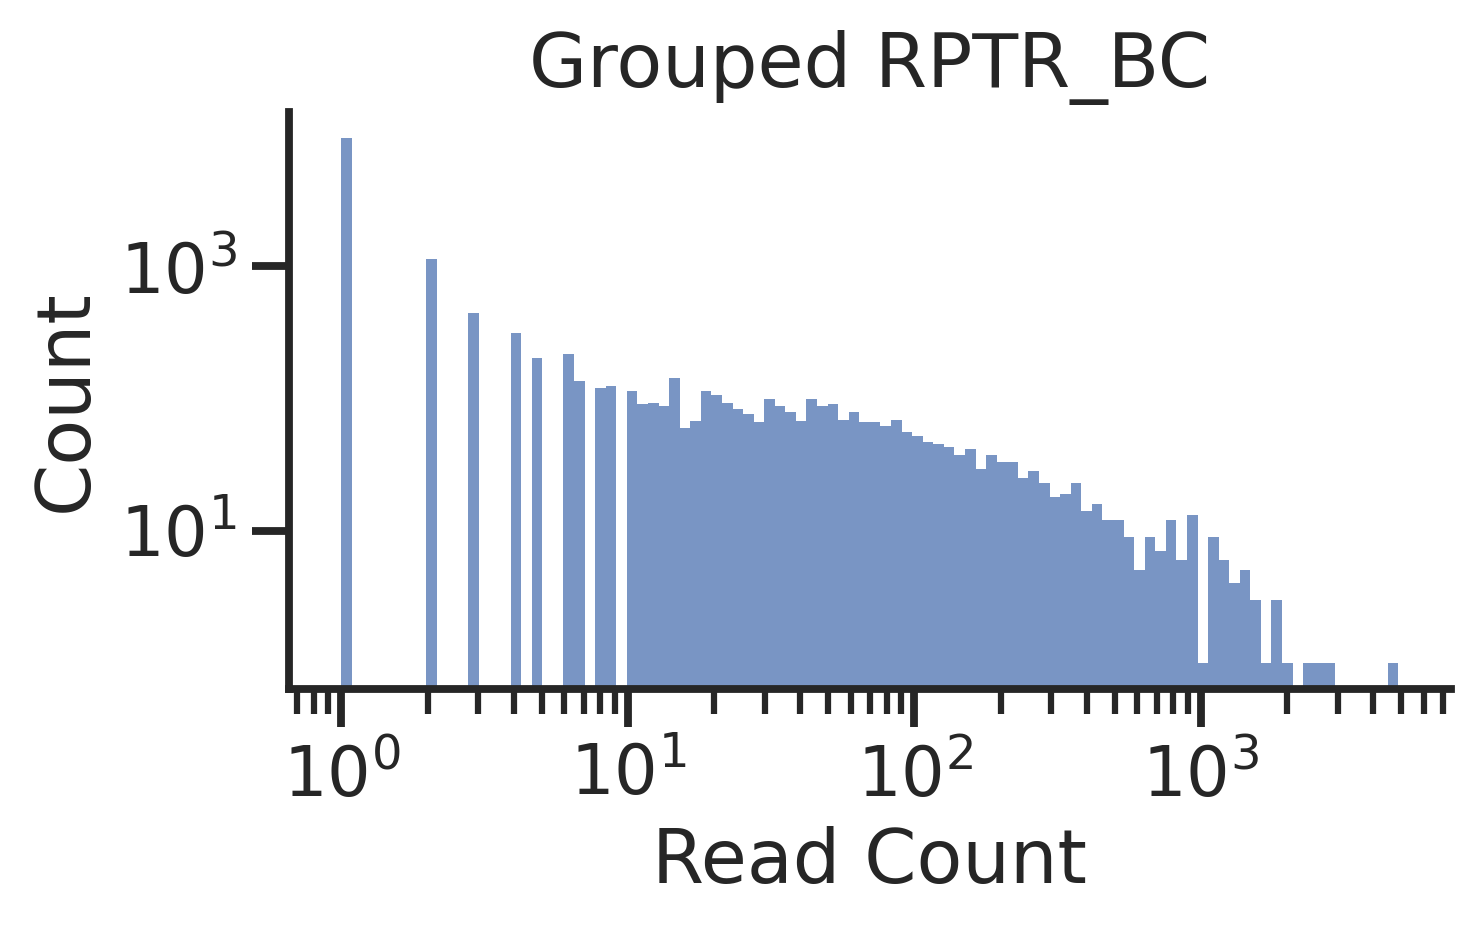

Done in 0.72 seconds.

Thresholding...
Using reads threshold of 20.


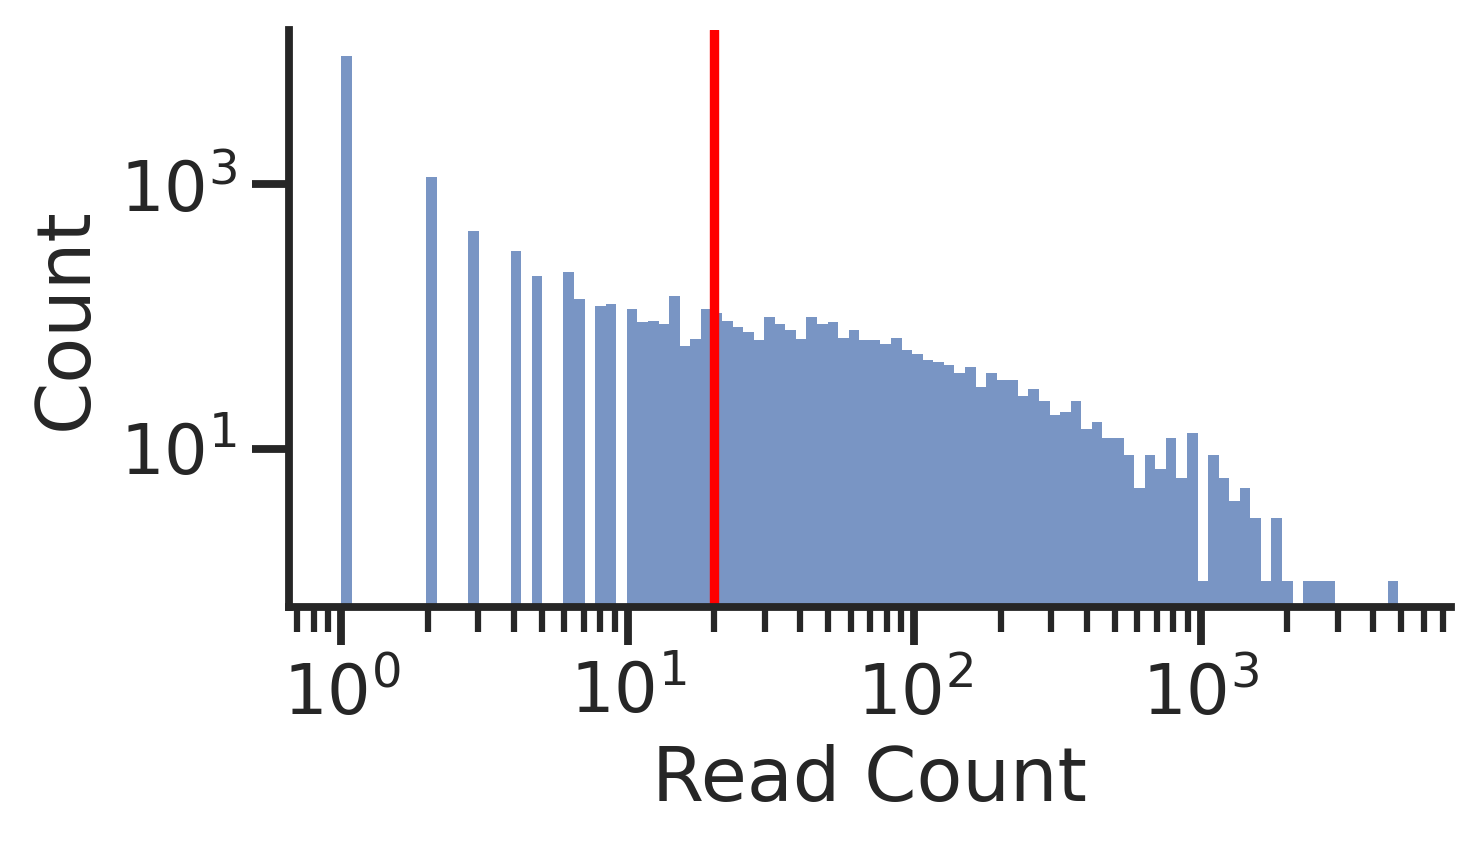

Done in 0.47 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_loss_summary'
Done in 0.02 seconds.

Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26
Reading 1 FASTQ/TXT file(s)...
Done in 0.65 seconds.

Reverse complement of sequences...
Done in 1.57 seconds.

Extracting 1 barcodes...
CTCGAG(.{1,14})
Done in 0.23 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Done in 3.20 seconds.

Mapping complete.
trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_initial
Total rows: 253560


RPTR_BC  RPTR_BC_qual  Designed
0  AGGCCTACNACCTG          True         1
1                         False         1
2                         False         1
3  GCCACAGCNACACA          True         1
4  TGGGCCGGAATNGC          True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.09 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_quality...


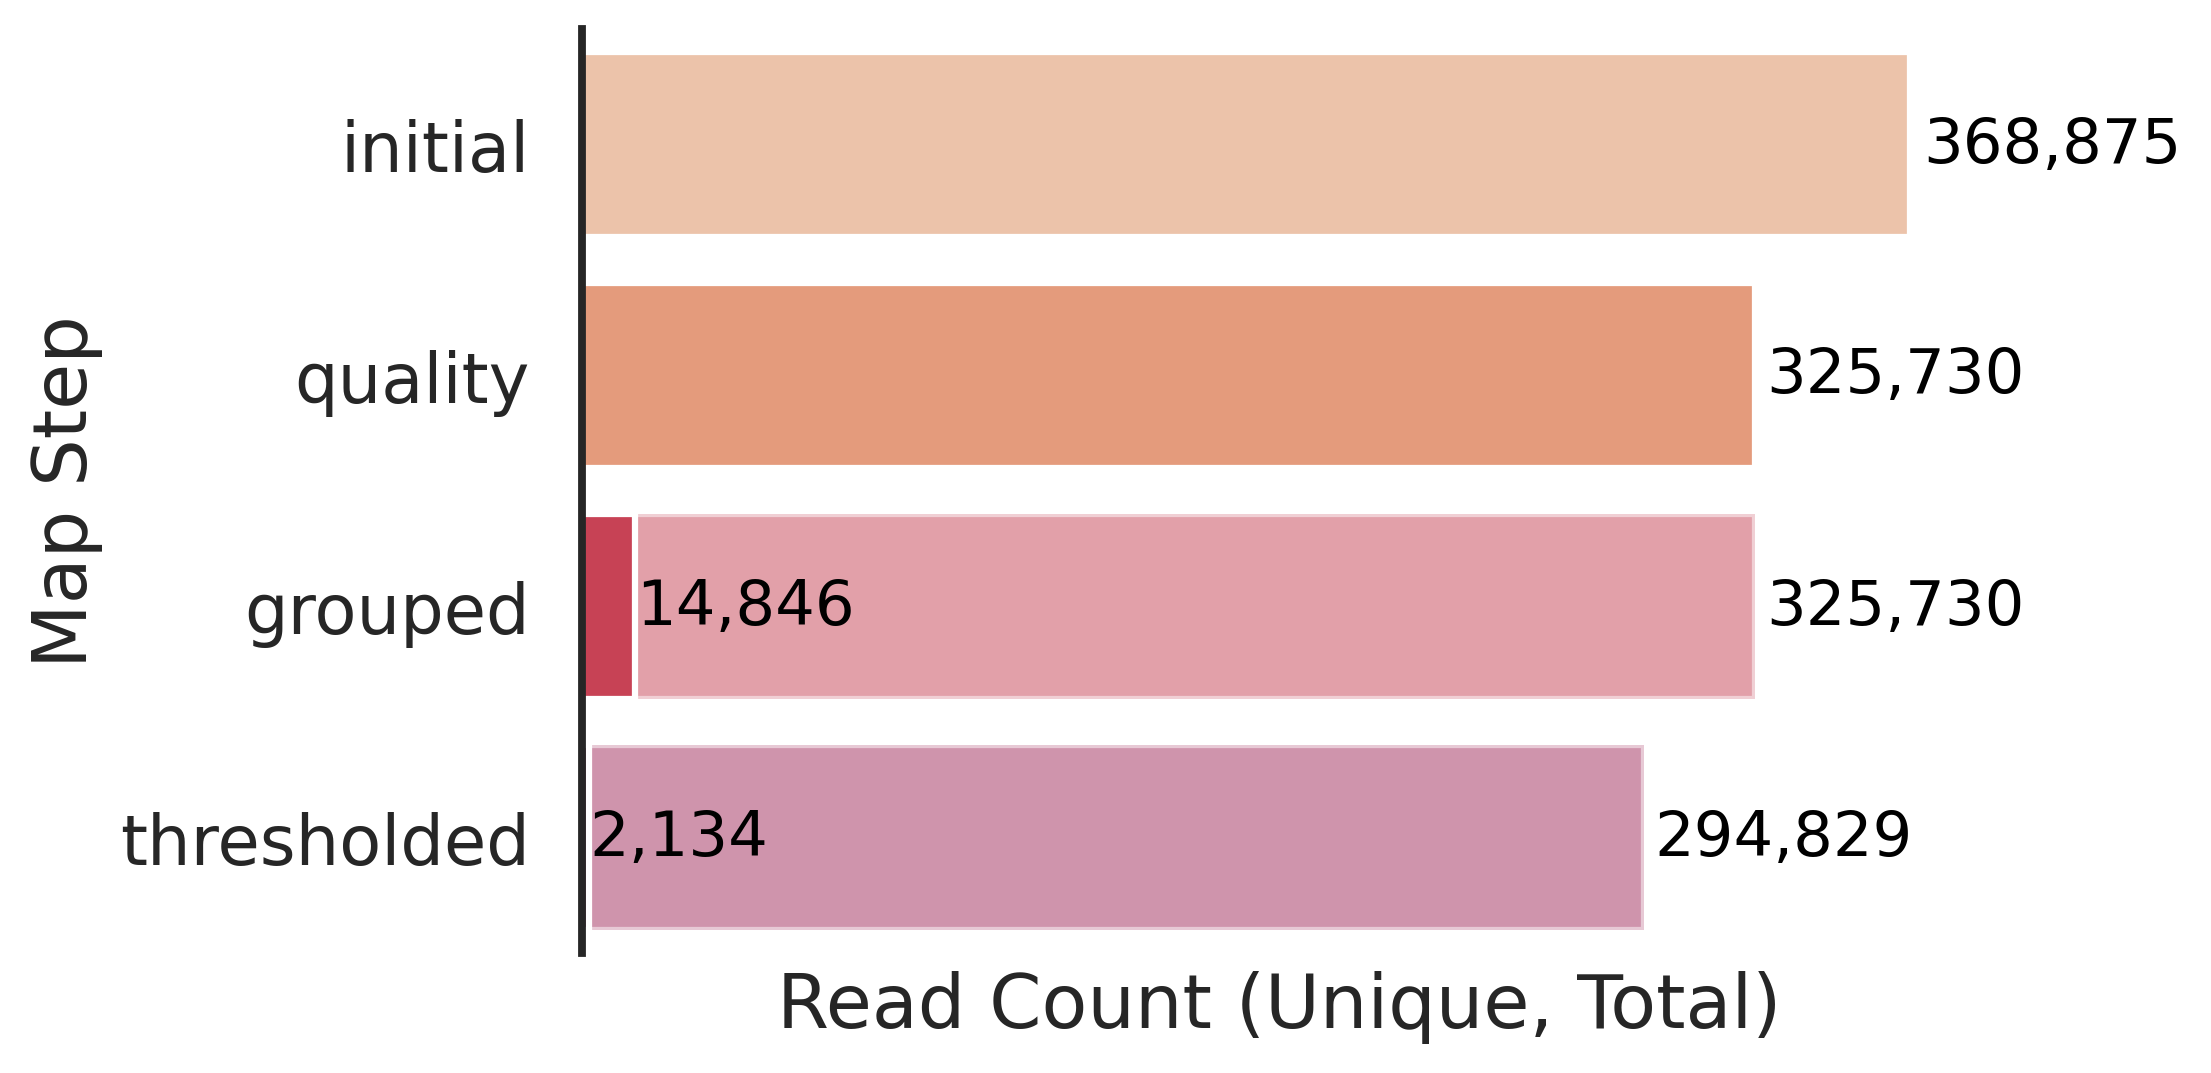

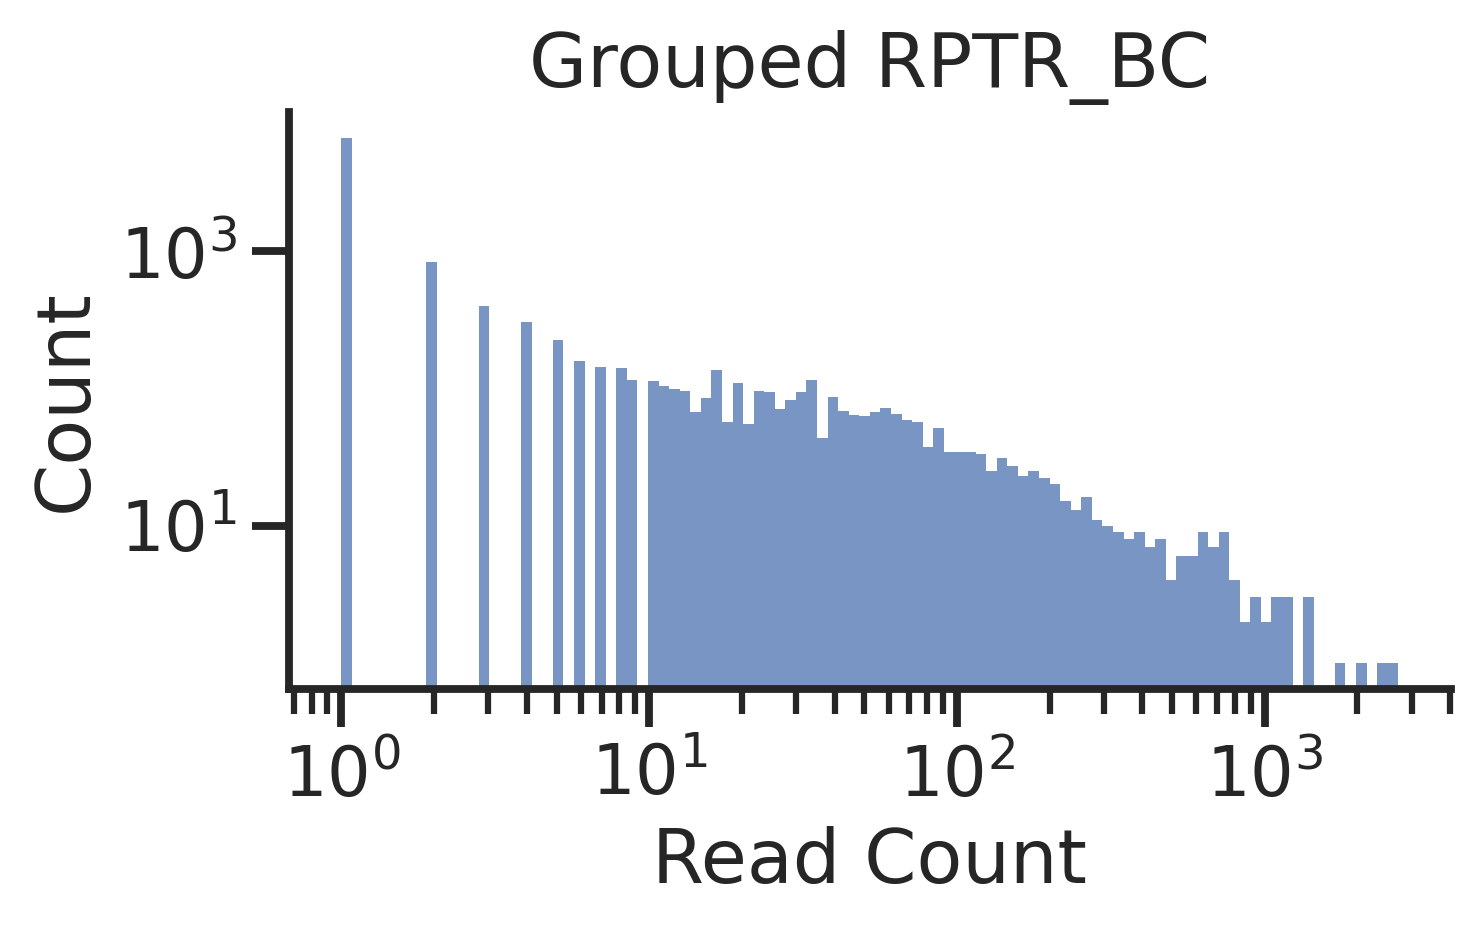

Done in 0.68 seconds.

Thresholding...
Using reads threshold of 20.


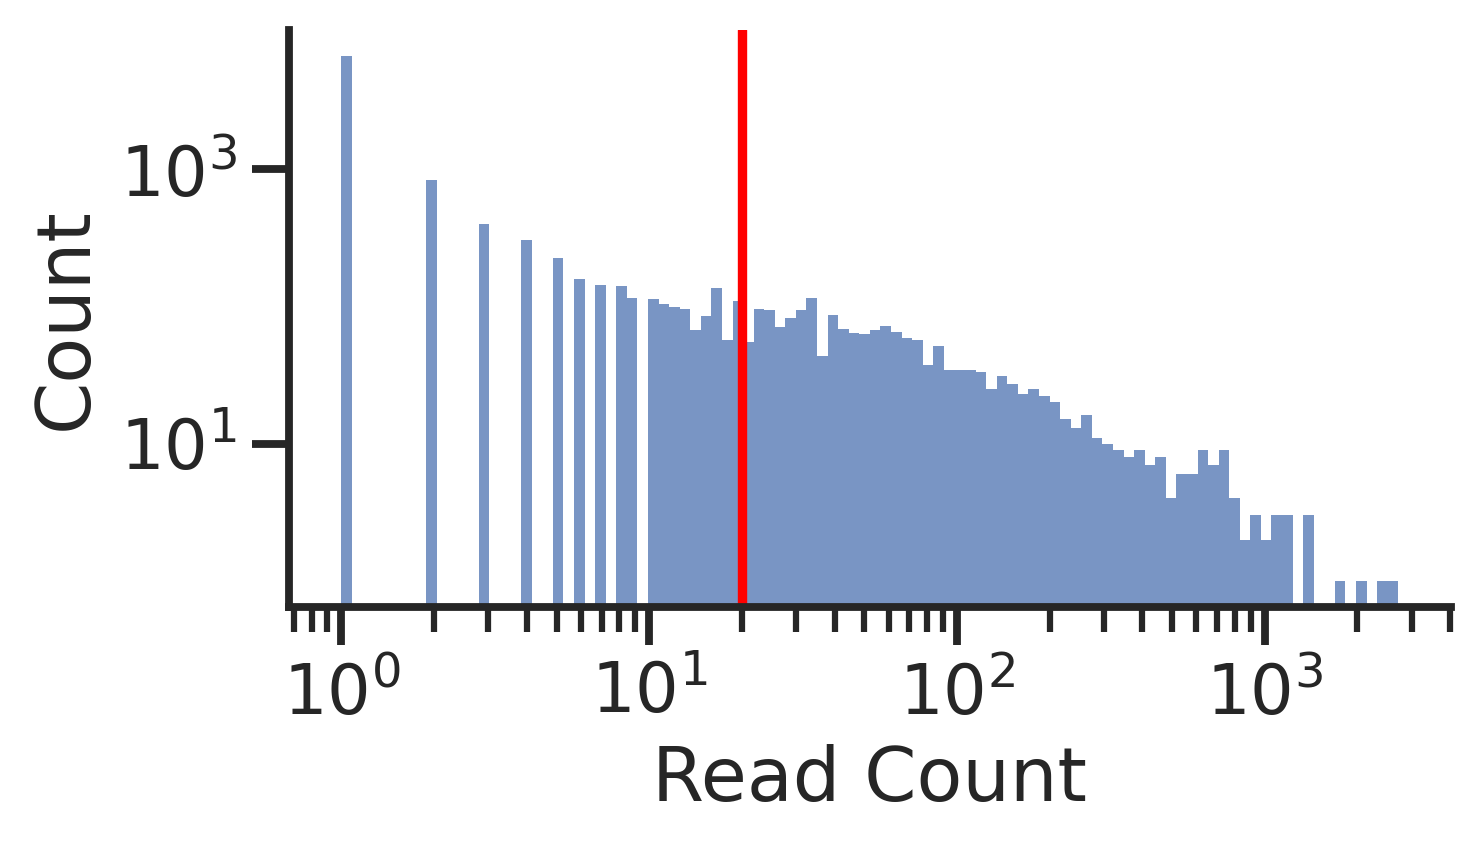

Done in 0.43 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_loss_summary'
Done in 0.02 seconds.

Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27
Reading 1 FASTQ/TXT file(s)...
Done in 0.92 seconds.

Reverse complement of sequences...
Done in 1.83 seconds.

Extracting 1 barcodes...
CTCGAG(.{1,14})
Done in 0.28 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Done in 4.55 seconds.

Mapping complete.
trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_initial
Total rows: 389472


RPTR_BC  RPTR_BC_qual  Designed
0  CGATTAAATNATGT          True         1
1  CCGTTTCCAGCANG          True         1
2                         False         1
3  TTGAATCATACCNG          True         1
4  TTCTAGGGAACNCG          True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.13 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_quality...


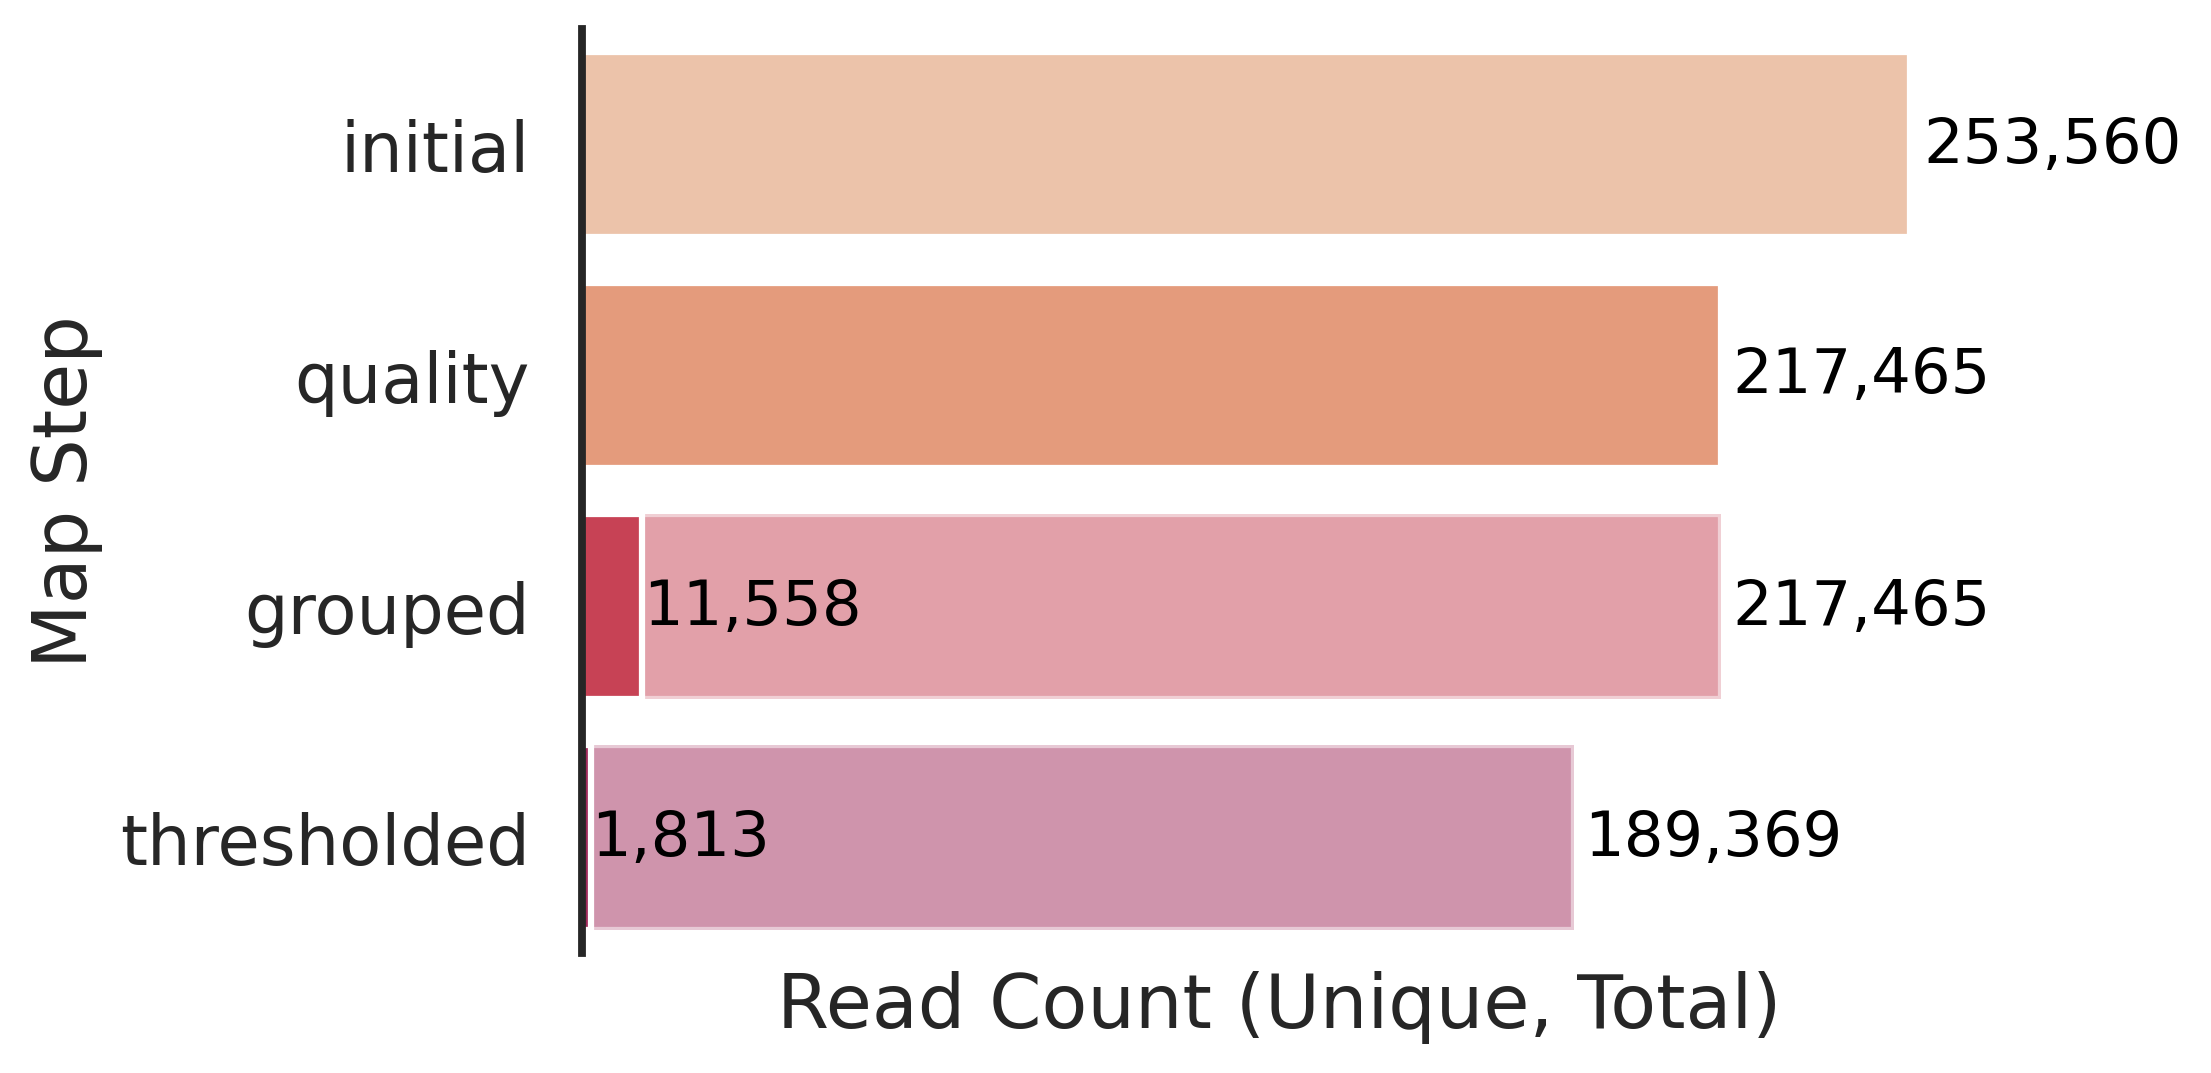

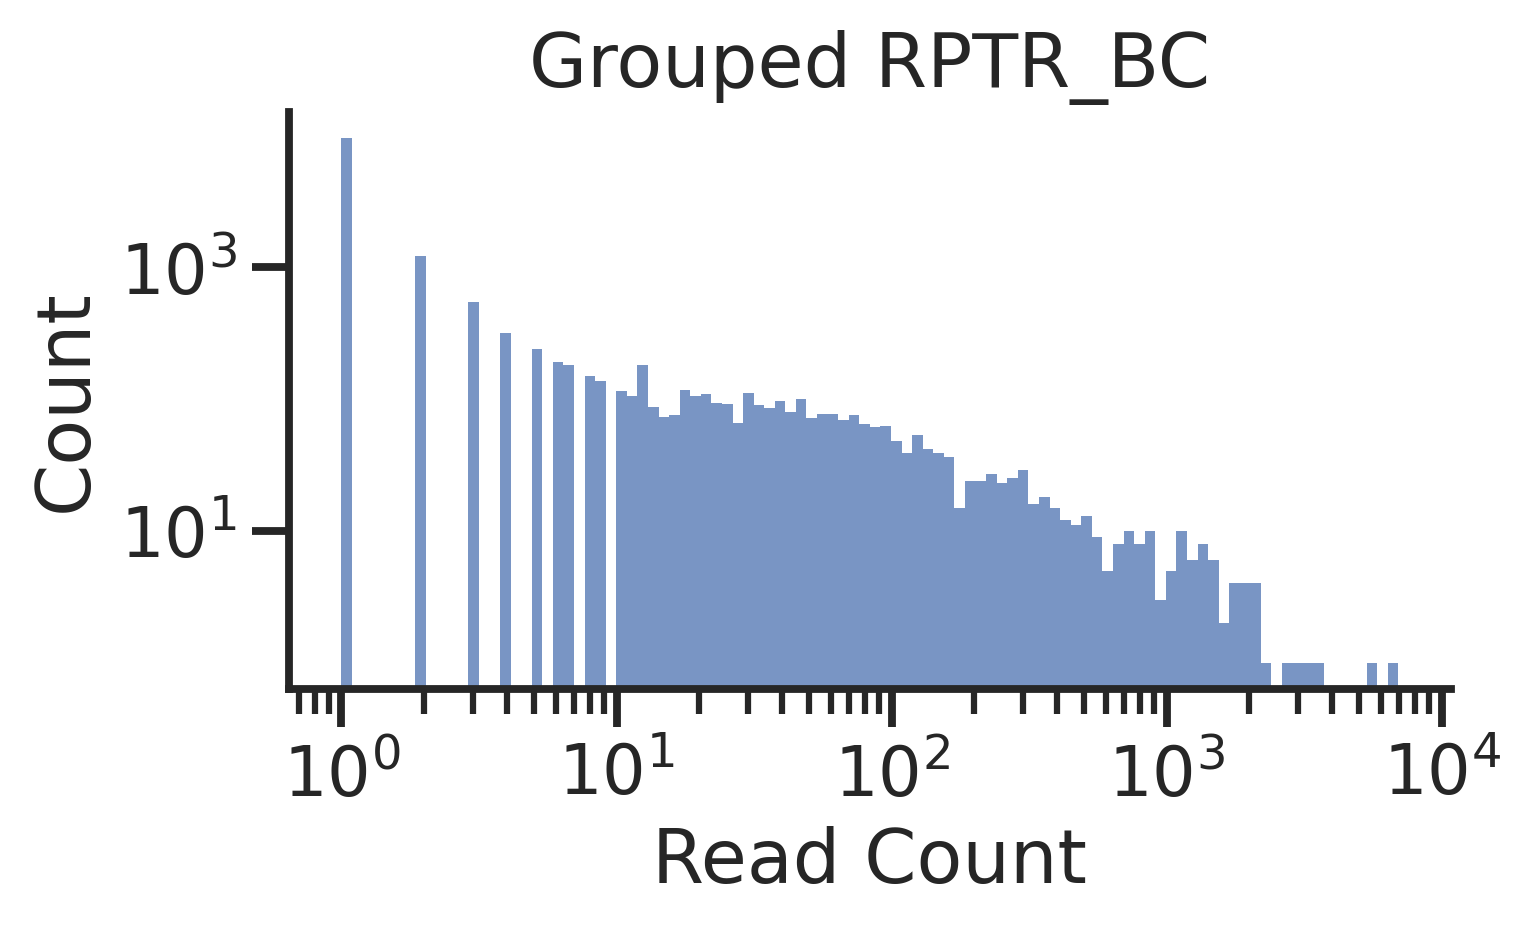

Done in 0.71 seconds.

Thresholding...
Using reads threshold of 20.


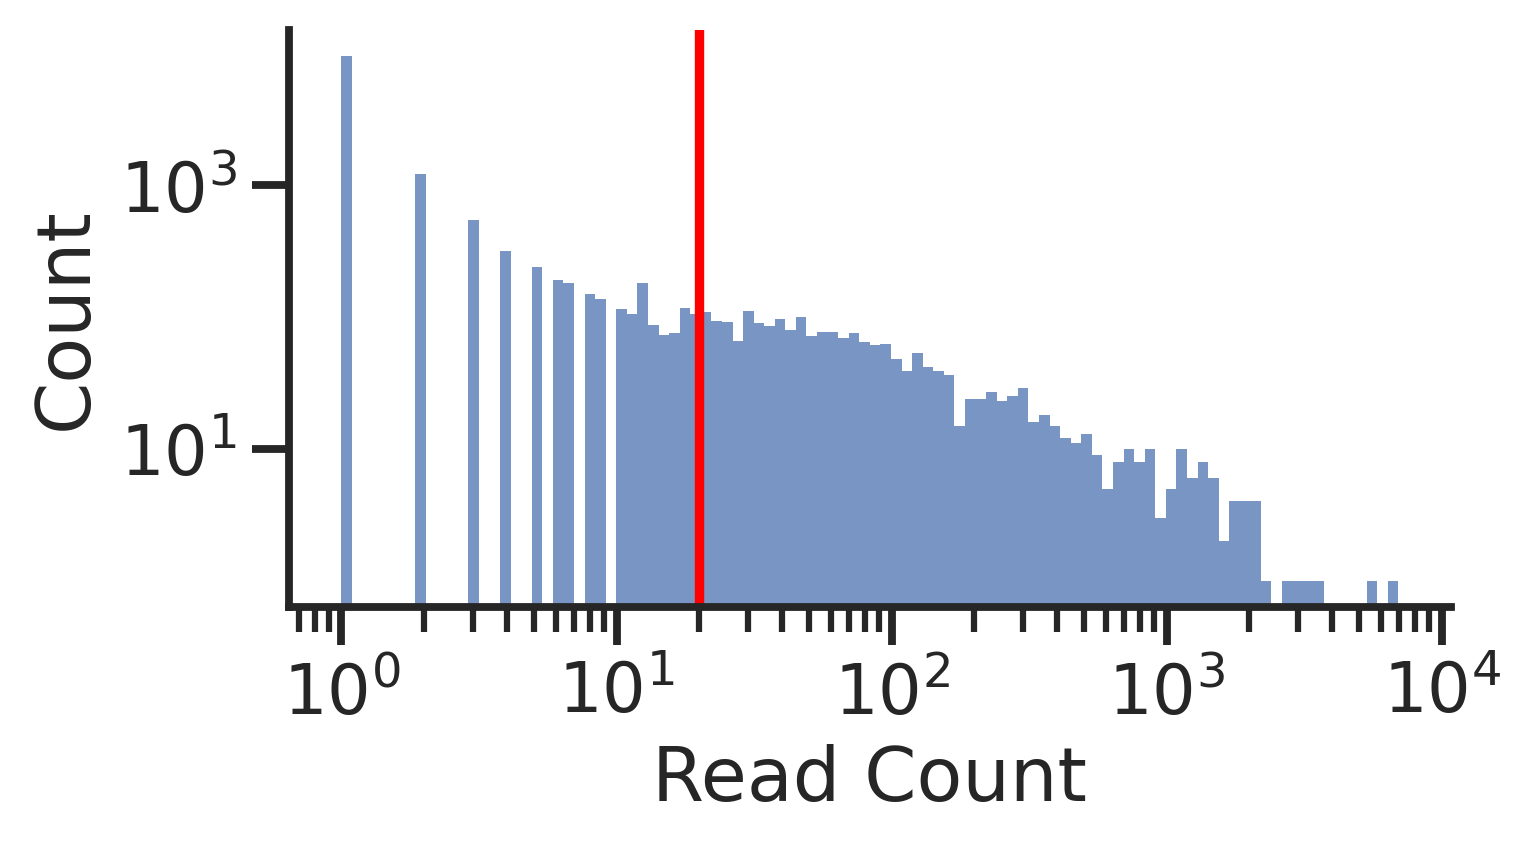

Done in 0.86 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_loss_summary'
Done in 0.02 seconds.

Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_A/trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23
Reading 1 FASTQ/TXT file(s)...
Done in 1.18 seconds.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.27 seconds.

Extracting 1 barcodes...
CTCGAG(.{1,14})
Done in 0.29 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Done in 4.89 seconds.

Mapping complete.
trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_initial
Total rows: 368519


RPTR_BC  RPTR_BC_qual  Designed
0  GAGGTAAATNAGAT          True         1
1  TATCCCATNTCAGG          True         1
2  TTTGTATCCTTNAG          True         1
3  CCCGAAGTCCNATA          True         1
4  GGACAGTCNGCCAT          True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.13 seconds.

Grouping trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_quality...


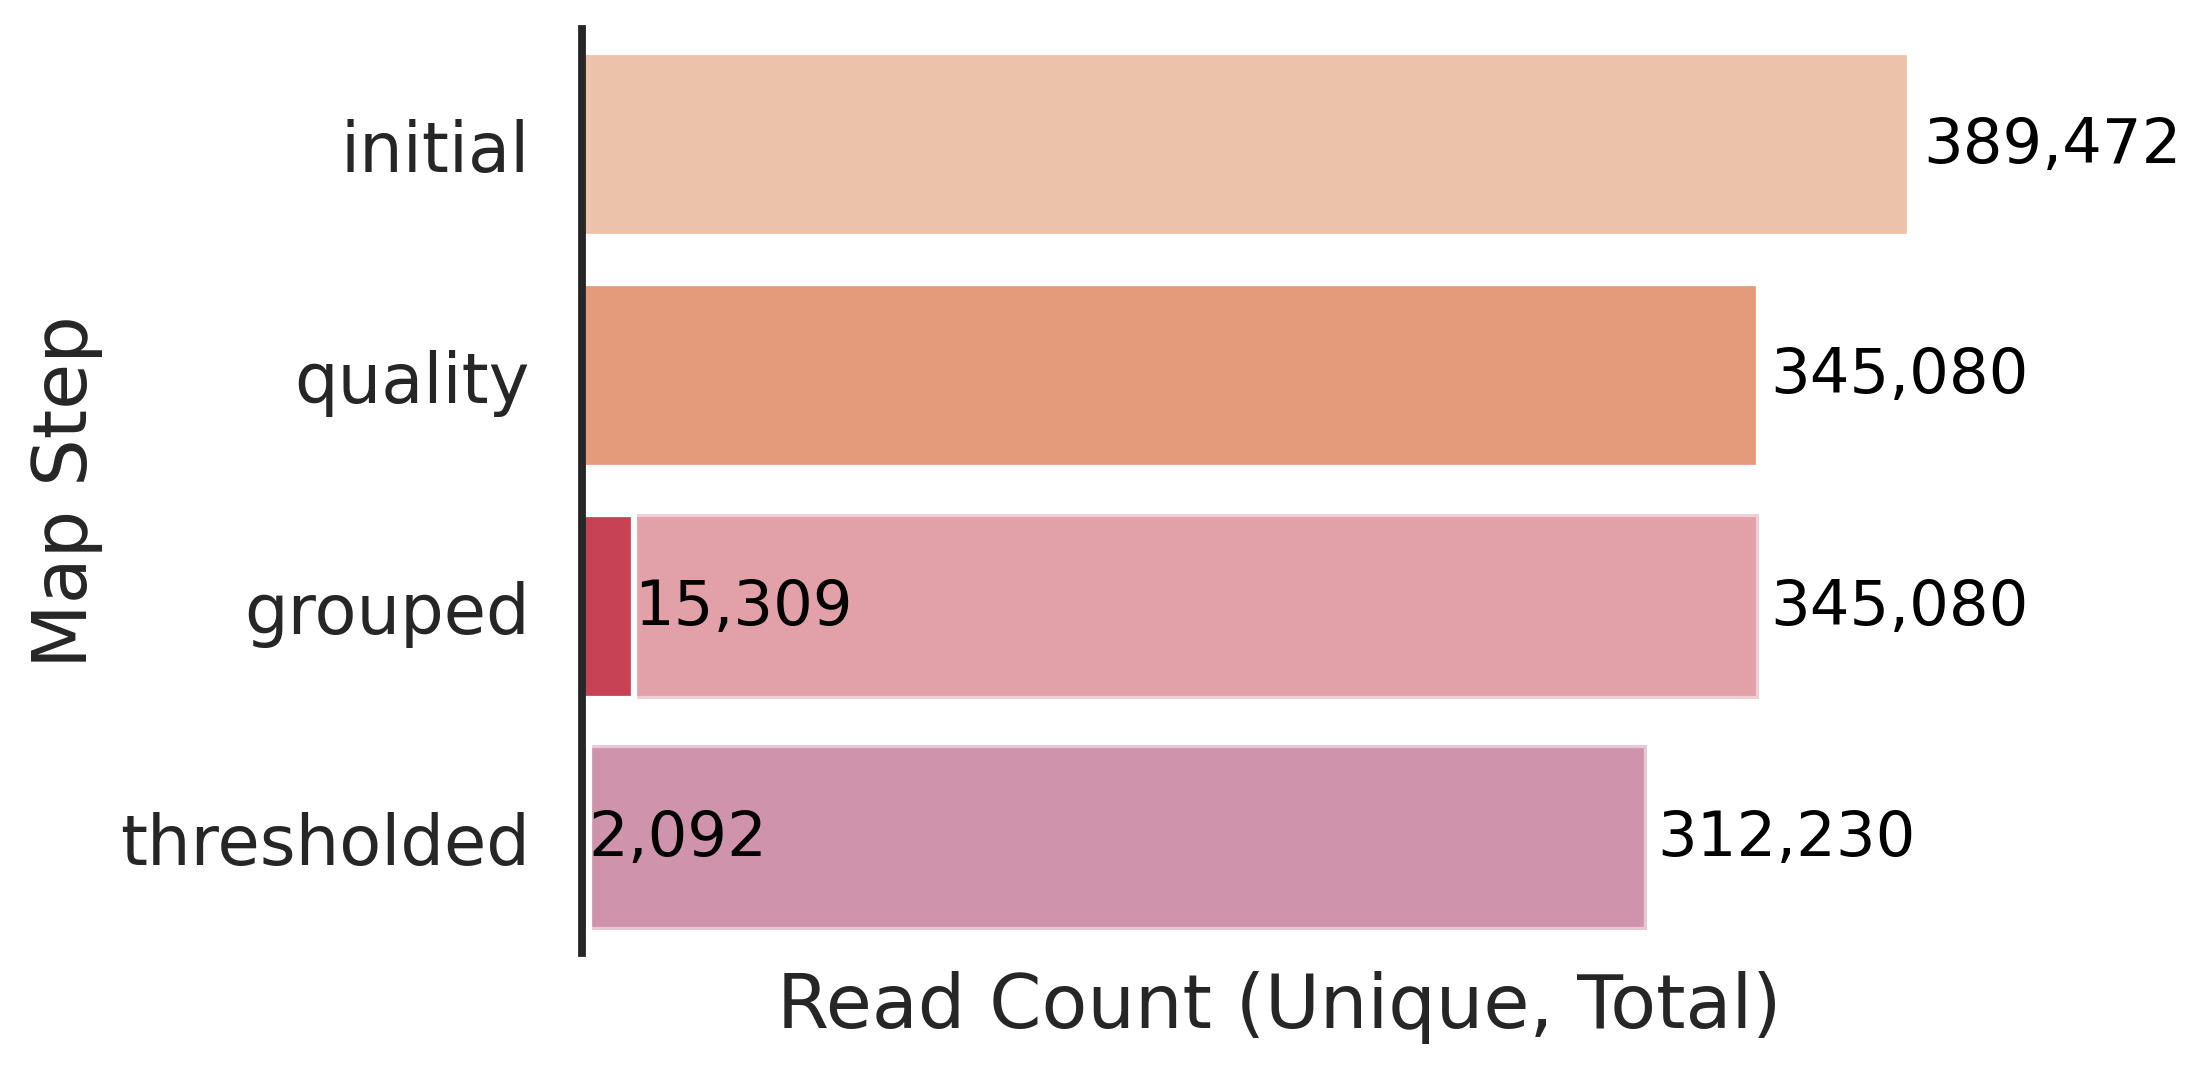

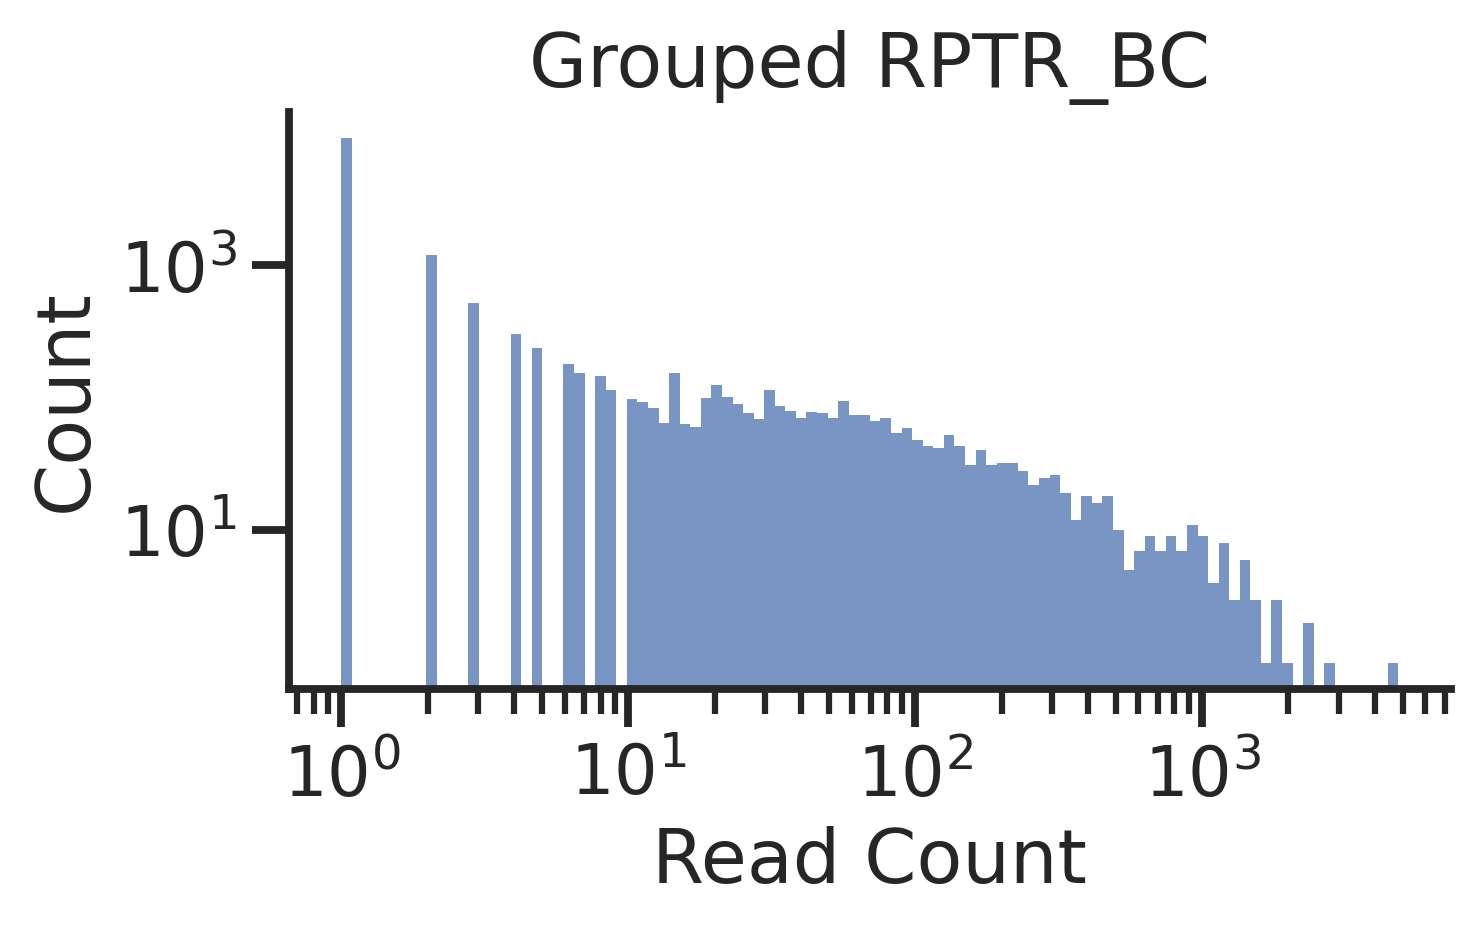

Done in 0.71 seconds.

Thresholding...
Using reads threshold of 20.


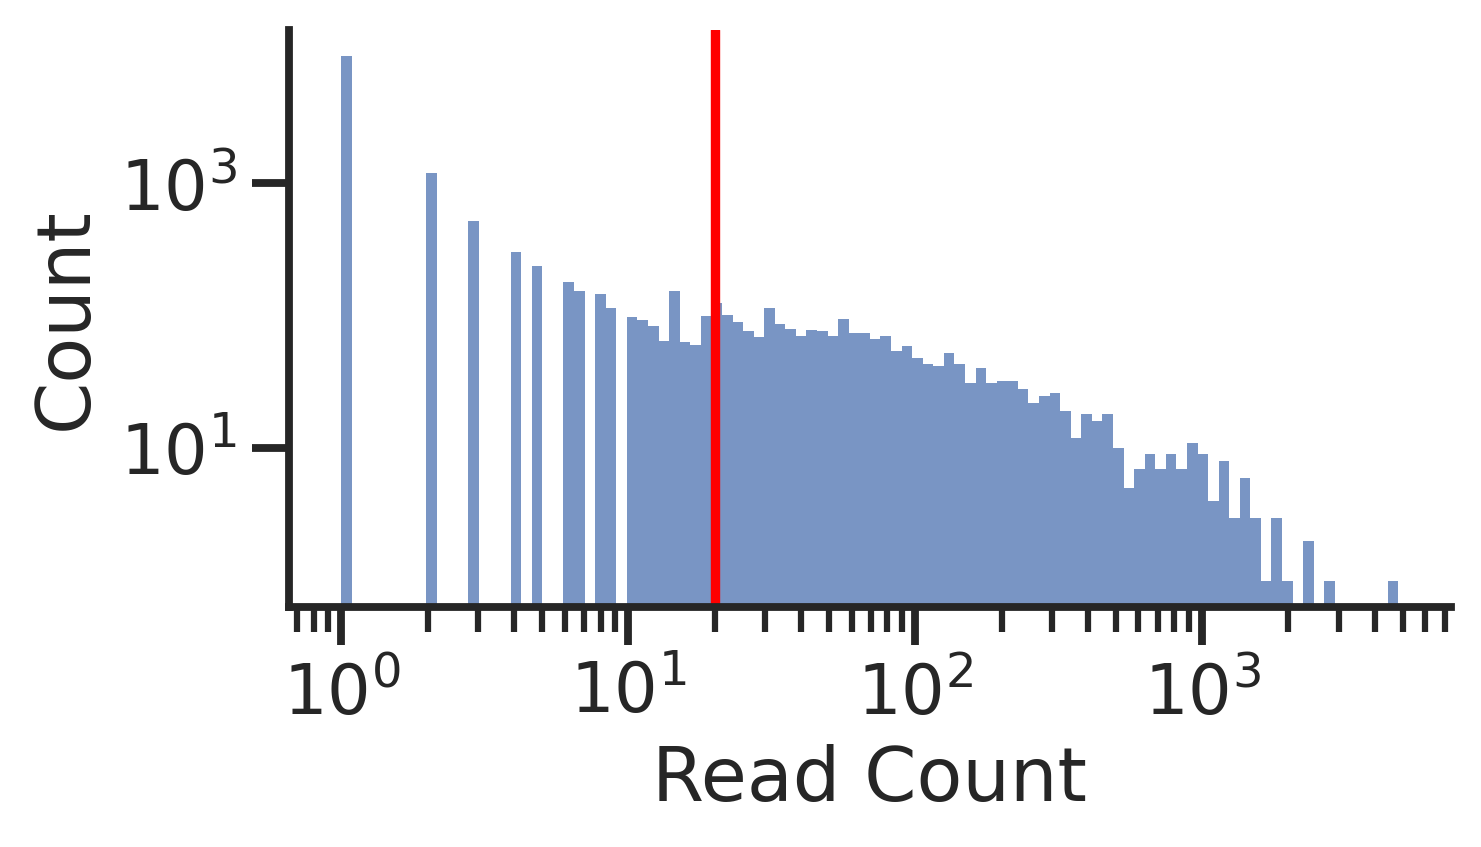

Done in 0.45 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_loss_summary'
Done in 0.02 seconds.



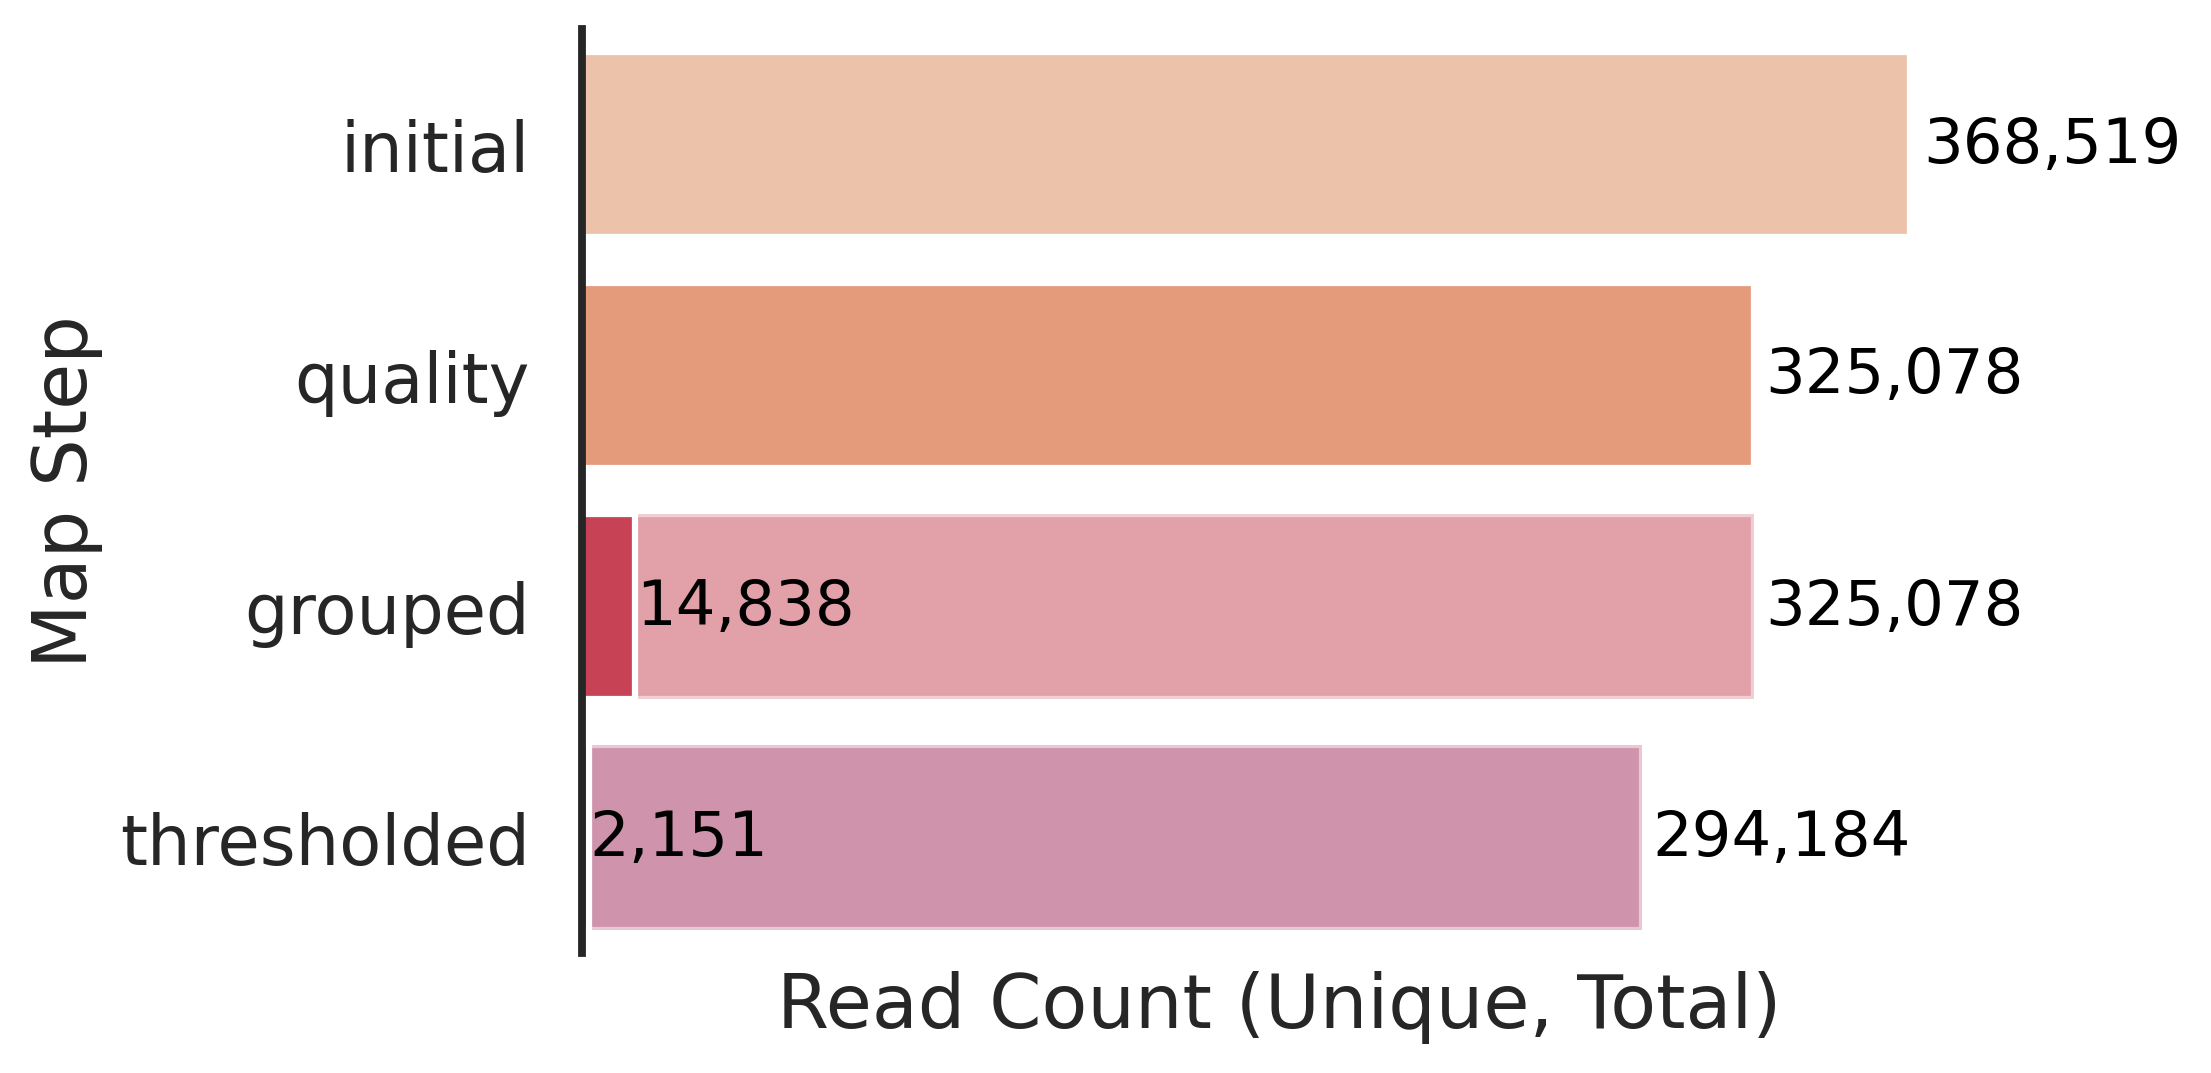

In [45]:
RPTR_objects = [EC_RPTR_BC]

for file_path in yeast_pool_A_RT_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0].replace("-", "_") # Need this replace part because otherwise gets weird
    print(name_only) 

    # Get the file naeme to use for output
    file_output_path = os.path.join(yeast_pool_A_output_path, f"trebl_experiment_yeast_pool_A_{name_only}")
    print(file_output_path)

    # Extract UMIs and barcodes from reads
    bc_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"trebl_experiment_yeast_pool_A_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = None,
                                       bc_objects = RPTR_objects,
                                       reverse_complement = True)
    umi_map = bc_mapper.create_map()
    display(bc_mapper.preview_map())

    # # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=RPTR_objects,
                                        column_pairs = [],
                                        map_order = ['quality', 'grouped', 'thresholded'],
                                        step_name=f"trebl_experiment_yeast_pool_A_{name_only}", 
                                        descriptor = "",
                                        should_check_exists = False,
                                        design_check = False,
                                        reads_threshold = 20)
    refiner.refine_map_from_db()
    refiner.plot_loss()
    

In [34]:
tables = refiner.show_tables()

yeast_pool_A_RPTR_result_tables = []
yeast_pool_A_RPTR_result_prefixes = []

for table in tables:
    if "trebl" in table[0] and "thresholded" in table[0] and "RPTR" in table[0] and "pool_A" in table[0]:
        print(table[0])
        yeast_pool_A_RPTR_result_prefixes.append(table[0])
        df = refiner.get_map_df(table[0])
        df["sample"] = table[0][38:]
        yeast_pool_A_RPTR_result_tables.append(df)

yeast_pool_A_RPTR_result_df = pd.concat(yeast_pool_A_RPTR_result_tables)
yeast_pool_A_RPTR_result_df

trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_thresholded
trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_thresholded


RPTR_BC  count  RPTR_BC_qual  Designed  \
0     CCTGGGATATGAGT   1162          True         1   
1     TGGGCCGGAATTGC   1054          True         1   
2     GCTTCTCCGCACAT   1032          True         1   
3     GTCCAGTTTAGTGA    980          True         1   
4     TTATTTAGAAGTTT    878          True         1   
...              ...    ...           ...       ...   
1808  GTGCATATTGCAAA     21          True         1   
1809  TGAGAGTATGTGAA     21          True         1   
1810  TATTGCCAAGAATC     21          True         1   
1811  ATGGGCGGAATAAT     21          True         1   
1812  ATCGTGTCGAATTA     21          True         1   

                                                 sample  
0     RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_...  
1     RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_...  
2     RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_...  
3     RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_...  
4     RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_...  
...                                                 ...  
1808  RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_...  
1809  RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_...  
1810  RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_...  
1811  RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_...  
1812  RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_...  

[10451 rows x 5 columns]

In [51]:
sum(yeast_pool_A_RPTR_result_df["count"])

1284826

In [49]:
yeast_pool_A_RPTR_result_df["sample"].value_counts()

sample
RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_thresholded          2261
RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_thresholded    2151
RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_thresholded    2134
RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_thresholded         2092
RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_thresholded          1813
Name: count, dtype: int64

### BC Quality Loss

In [57]:
yeast_pool_A_AD_result_prefixes.sort()

In [60]:
yeast_pool_A_RPTR_result_prefixes.sort()

In [58]:
yeast_pool_A_AD_result_prefixes

['trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_thresholded',
 'trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_thresholded',
 'trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_thresholded',
 'trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_thresholded',
 'trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_thresholded']

In [61]:
yeast_pool_A_RPTR_result_prefixes

['trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_thresholded',
 'trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_thresholded',
 'trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_50p_MVS_0076_I1_MVS_0076_I2_AAGCCTTCAA_TCACGTGTGA_S23_RPTR_BC_thresholded',
 'trebl_experiment_yeast_pool_A_Staller_RPTR_3_240_1_67p_MVS_0077_I1_MVS_0077_I2_TAGATCGCTC_CTATCTGGTT_S24_RPTR_BC_thresholded',
 'trebl_experiment_yeast_pool_A_Staller_RPTR_3_5_2_MVS_0079_I1_MVS_0079_I2_TCTTGGCCTC_CTCTATTCGC_S26_RPTR_BC_thresholded']

In [37]:
step1_map = refiner.get_map_df('step1_AD_AD_BC_RPTR_BC_designed')
step1_map

AD        AD_BC  \
0       CCATTGTGTTCTCCTAAAGCTCCATCTGCTTTGATTACTCCAATGA...  AAAGTTATCAA   
1       TTTGATCCATCTAATGAAATTTCATTTGATGATCCAGTCTTGTTTC...  CAGTAACTATC   
2       TCTTCTTCTGTTCCATCTTCTGTTTCTAATATGGGTACTGTTTCTC...  GACCCCAACGT   
3       CCAACTTCTACTGCTACTACTAATTTGGCTTCTCCATTGTCTTTGT...  GGATCCAAGTT   
4       GCTGCTCATTACTTCTTGGCTTTGAGACAATCTCAAGAGTTCTCTG...  TCACTTGTTAT   
...                                                   ...          ...   
127403  ACTGCTTTGACTTCTCCATCTTTGTATGATGAATCTCCAGACTTTG...  CCTTCCCGCAG   
127404  GTTGCTAATATGGCTGATTTAAATTCTAATAATTCATTTGATTCTG...  TTCACTCCTTA   
127405  GCATTTACTAATTTGACTTCTCCATCTACTTATAATGAATCTCCAG...  CTCGGCAGAAG   
127406  AATGCTTCTTCTGCTCCATCTTCTTCTTCATTTGGTTTGTCTGGTA...  TAAGAAACGAC   
127407  GGTAAAGTTTATGAATTGATCTTGTCTTGGGATGAACAATTGTATC...  TCAGTATGAAT   

               RPTR_BC  count  AD_qual  AD_BC_qual  RPTR_BC_qual  Designed  
0       TTCGGTGCCATAAC     87     True        True          True         1  
1       ATACGACGCTTTAC     87     True        True          True         1  
2       CACCACGCTTAGCT     87     True        True          True         1  
3       ATGCGTATTATTTA     87     True        True          True         1  
4       CGAATGACTCGACC     87     True        True          True         1  
...                ...    ...      ...         ...           ...       ...  
127403  TCGCAATTTCCTCT     87     True        True          True         1  
127404  CACGCAAGCCAAGG     87     True        True          True         1  
127405  TAACCCCAACACCG     87     True        True          True         1  
127406  GAGGACAATCATCG     87     True        True          True         1  
127407  CCCGAGATTTTATG     87     True        True          True         1  

[127408 rows x 8 columns]

In [41]:
len("trebl_experiment_yeast_pool_A_Staller_AD_")

41

In [46]:
file_name

'trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_initial'

In [54]:
import re
str(re.search(r'(\d+_\d+_\d+)', file_name)[0])

'3_5_2'

trebl_experiment_yeast_pool_A_Staller_AD_3_0_2_MVS_0073_I1_MVS_0073_I2_GCTCCTGATG_AGGTCGTGTC_S20_AD_AD_BC_initial step1 count: 70076
trebl_experiment_yeast_pool_A_Staller_AD_3_10_1_MVS_0075_I1_MVS_0075_I2_CTGTCCACAC_CACTGTATAG_S22_AD_AD_BC_initial step1 count: 136948
trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_50p_MVS_0071_I1_MVS_0071_I2_TTCAATACGC_CTTGCACGAG_S18_AD_AD_BC_initial step1 count: 145212
trebl_experiment_yeast_pool_A_Staller_AD_3_240_1_67p_MVS_0072_I1_MVS_0072_I2_GTCGACTAAC_AAGACCTGAG_S19_AD_AD_BC_initial step1 count: 122477
trebl_experiment_yeast_pool_A_Staller_AD_3_5_2_MVS_0074_I1_MVS_0074_I2_GTATTCACAG_GCTTATGAGA_S21_AD_AD_BC_initial step1 count: 119817
trebl_experiment_yeast_pool_A_Staller_RPTR_3_0_2_MVS_0078_I1_MVS_0078_I2_AAGCGCAAGG_AATGCAACCT_S25_RPTR_BC_initial step1 count: 130339
trebl_experiment_yeast_pool_A_Staller_RPTR_3_10_1_MVS_0080_I1_MVS_0080_I2_GTGAAGGCGA_TCACATCAAG_S27_RPTR_BC_initial step1 count: 227891
trebl_experiment_yeast_pool_A_Staller_RPTR_3_24

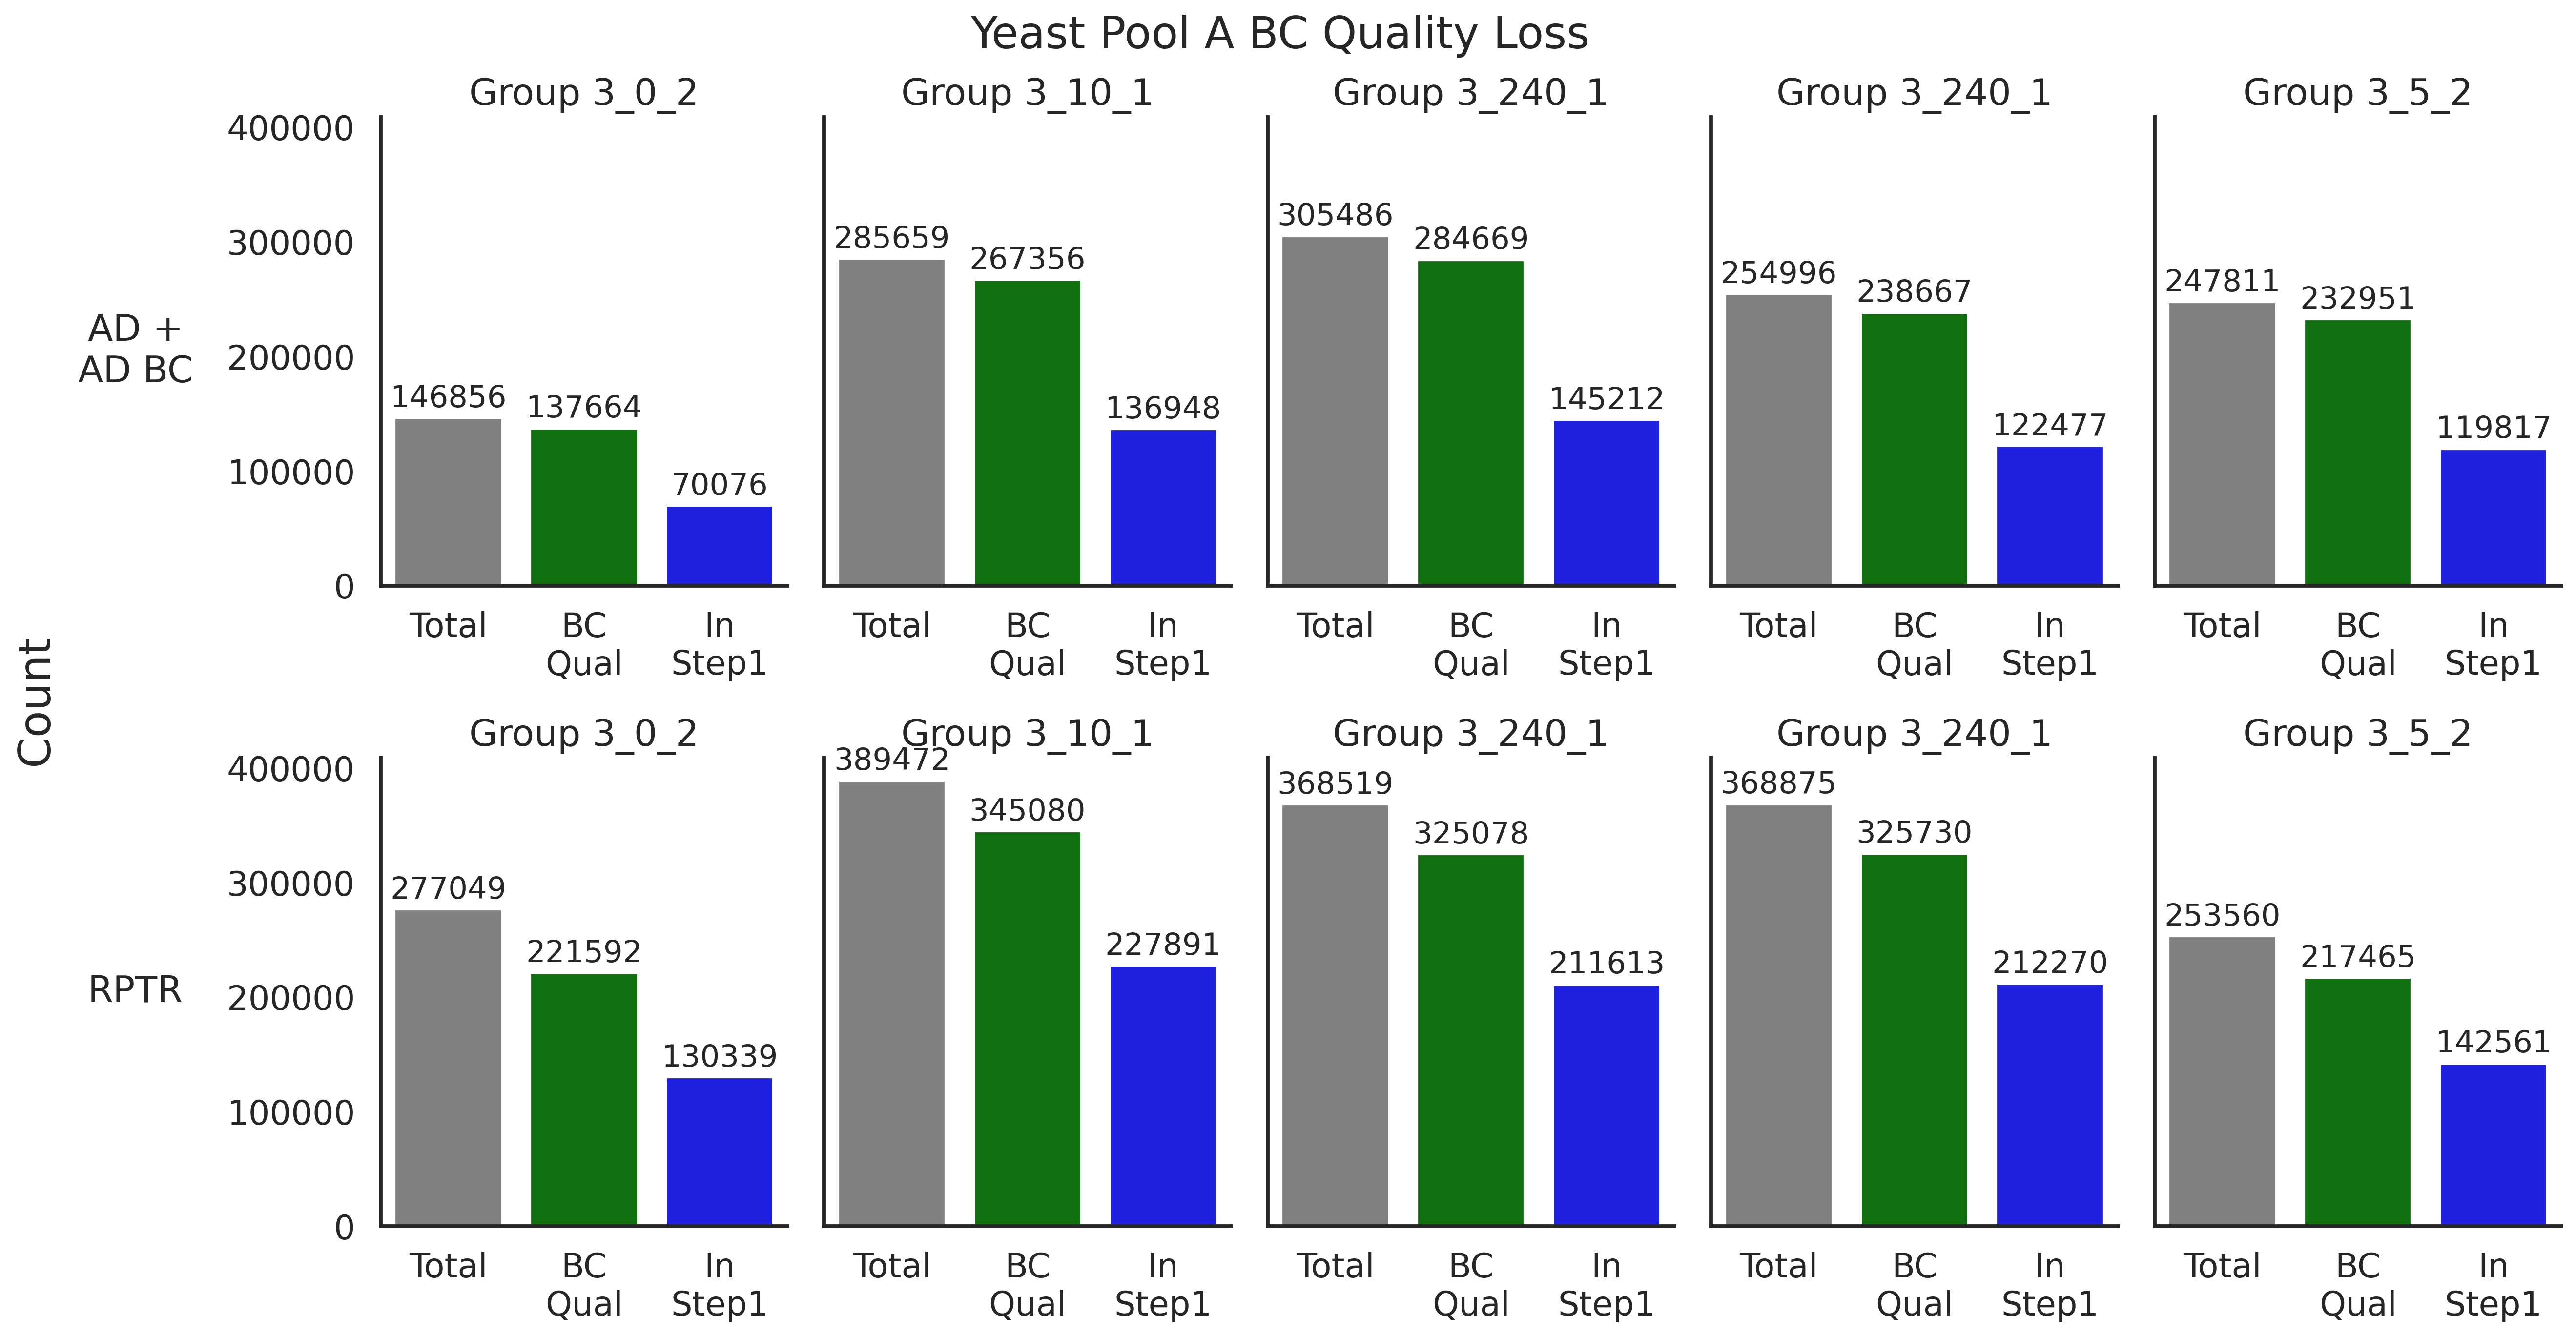

In [80]:
fig, axes = plt.subplots(2, 5, figsize=(18,9), dpi=300, sharey=True, sharex=False)
axes = axes.flatten()  # flatten to index easily 0..9 (2*5)

# First row: AD (ADBC/HawkBCs)
for i, prefix in enumerate(yeast_pool_A_AD_result_prefixes): 
    # Construct the file name for Step1 mapping
    file_name = prefix[:-12] + "_initial"  # keep your original logic
    
    df = refiner.get_map_df(file_name)
    
    total_count = len(df)
    both_true = ((df["AD_BC_qual"]) & (df["AD_qual"])).sum()
    step1_count = len(df[(df["AD_BC"].isin(step1_map["AD_BC"])) & (df["AD"].isin(step1_map["AD"]))])
    print(f"{file_name} step1 count: {step1_count}")

    plot_counts = pd.DataFrame({
        "Category": ["Total", "BC\nQual", "In\nStep1"],
        "Count": [total_count, both_true, step1_count]
    })

    ax = axes[i]  # use loop index
    sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green", "blue"])
    
    # Add counts above bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)

    # Title, remove x/y labels
    ax.set_title("Group " + str(re.search(r'(\d+_\d+_\d+)', file_name)[0]), fontsize='medium')
    ax.set_xlabel("")
    ax.set_ylabel("")

# Second row: RPTR (RTBC)
for i, prefix in enumerate(yeast_pool_A_RPTR_result_prefixes): 

    file_name = prefix[:-12] + "_initial"  # keep your original logic
    df = refiner.get_map_df(file_name)
    
    total_count = len(df)
    true_count = df["RPTR_BC_qual"].sum()  # assuming boolean True/False
    step1_count = len(df[df["RPTR_BC"].isin(step1_map["RPTR_BC"])])
    print(f"{file_name} step1 count: {step1_count}")
    
    plot_counts = pd.DataFrame({
        "Category": ["Total", "BC\nQual", "In\nStep1"],
        "Count": [total_count, true_count, step1_count]
    })

    ax = axes[6 + i - 1]
    sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green", "blue"])
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)

    ax.set_title("Group " + str(re.search(r'(\d+_\d+_\d+)', file_name)[0]), fontsize='medium')
    ax.set_xlabel("")
    ax.set_ylabel("")

axes[0].set_ylabel("AD +\nAD BC", rotation = 0, labelpad = 45, va = 'center')
axes[5].set_ylabel("RPTR", rotation = 0, labelpad = 45, va = 'center')

#axes[0].set_ylim(0, 2000000)
fig.supylabel("Count")
sns.despine()
plt.tight_layout(pad = 1)
fig.suptitle("Yeast Pool A BC Quality Loss", y = 1.02)
plt.savefig(os.path.join("../../output/GCN4/yeast_pool_A/figures", f"bc_quality_loss.png"))
plt.show()

## Yeast Pool B ** Save loss figures **

### 1. AD + ADBC

##### Submitted job with global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/GCN4/yeast_pool_B_trebl_experiment.py

In [81]:
yeast_pool_B_PolyT_AD_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Apr2024/20240425/EC_Ciber2/results/assembled_reads/AD_reads/*fastq")
yeast_pool_B_RT_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Apr2024/20240425/EC_Ciber2/results/assembled_reads/RPTR_reads/*fastq")
yeast_pool_B_output_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_B" # May need to change to your directory due to writing permissions

In [10]:
# print(len(yeast_pool_B_AD_seq_files))
# yeast_pool_B_AD_seq_files

In [11]:
# AD_objects = [EC_AD, EC_AD_BC]

# complex_AD_results = []
# simple_AD_results = []

# for file_path in yeast_pool_B_AD_seq_files:
    
#     # Get the file naeme to use for database
#     base_name = os.path.basename(file_path)
#     name_only = base_name.split('.')[0].replace("-", "_") # Need this replace part because otherwise gets weird
#     print(name_only) 

#     # Get the file naeme to use for output
#     file_output_path = os.path.join(yeast_pool_B_output_path, f"trebl_experiment_yeast_pool_B_{name_only}")
#     print(file_output_path)

#     # Extract UMIs and barcodes from reads
#     bc_mapper = initial_map.InitialMapper(db_path = db_path,
#                                        step_name = f"trebl_experiment_yeast_pool_B_{name_only}", 
#                                        seq_file = file_path,
#                                        design_file_path = "/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/A10_sequencing/v2/current/a10_designfile.csv",
#                                        bc_objects = AD_objects,
#                                        reverse_complement = True)
#     bc_mapper.create_map()
#     display(bc_mapper.preview_map())

#     # # Only keep barcodes of correct length
#     refiner = map_refiner.MapRefiner(db_path = db_path,
#                                         bc_objects=AD_objects,
#                                         column_pairs = [],
#                                         map_order = ['quality', 'designed', 'grouped', 'thresholded'],
#                                         step_name=f"trebl_experiment_yeast_pool_B_{name_only}", 
#                                         descriptor = "",
#                                         should_check_exists = False,
#                                         design_check = True, reads_threshold = 100)
#     refiner.refine_map_from_db()    

In [12]:
# tables = refiner.show_tables()

# yeast_pool_B_AD_result_tables = []

# for table in tables:
#     if "trebl" in table[0] and "thresholded" in table[0]:
#         print(table[0])
#         df = refiner.get_map_df(table[0])
#         df["sample"] = table[0][38:]
#         yeast_pool_B_AD_result_tables.append(df)

# yeast_pool_B_AD_result_df = pd.concat(yeast_pool_B_AD_result_tables)
# yeast_pool_B_AD_result_df

### 2. RPTR BC

##### Submitted job with global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/GCN4/yeast_pool_B_trebl_experiment.py

In [82]:
RPTR_objects = [EC_RPTR_BC]

for file_path in yeast_pool_B_RT_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0].replace("-", "_") # Need this replace part because otherwise gets weird
    print(name_only) 

    # # Get the file naeme to use for output
    # file_output_path = os.path.join(yeast_pool_B_output_path, f"trebl_experiment_yeast_pool_B_{name_only}")
    # print(file_output_path)

    # # Extract UMIs and barcodes from reads
    # bc_mapper = initial_map.InitialMapper(db_path = db_path,
    #                                    step_name = f"trebl_experiment_yeast_pool_B_{name_only}", 
    #                                    seq_file = file_path,
    #                                    design_file_path = None,
    #                                    bc_objects = RPTR_objects,
    #                                    reverse_complement = True)
    # umi_map = bc_mapper.create_map()
    # display(bc_mapper.preview_map())

    # # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=RPTR_objects,
                                        column_pairs = [],
                                        map_order = ['quality', 'grouped', 'thresholded'],
                                        step_name=f"trebl_experiment_yeast_pool_B_{name_only}", 
                                        descriptor = "",
                                        reads_threshold = 100)
    # refiner.refine_map_from_db()
    

RPTR_3_0_S70
Base prefix (stable across descriptors): trebl_experiment_yeast_pool_B_RPTR_3_0_S70_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_B_RPTR_3_0_S70_RPTR_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded

RPTR_4_10_S78
Base prefix (stable across descriptors): trebl_experiment_yeast_pool_B_RPTR_4_10_S78_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_B_RPTR_4_10_S78_RPTR_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded

RPTR_4_15_S79
Base prefix (stable across descriptors): trebl_experiment_yeast_pool_B_RPTR_4_15_S79_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_B_RPTR_4_15_S79_RPTR_BC_

Using the following step order:
1. initial
2. quality
3. grouped
4. thresholded

RPTR_2_5_S64
Base prefix (stable across descriptors): trebl_experiment_yeast_pool_B_RPTR_2_5_S64_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_B_RPTR_2_5_S64_R

## BC Quality loss

In [135]:
tables = refiner.show_tables()

yeast_pool_B_AD_prefixes = []
yeast_pool_B_RPTR_prefixes = []

for table in tables:
    if "trebl_experiment_yeast_pool_B_" in table[0] and "thresholded" in table[0]:
        if "RPTR" in table[0]:
            yeast_pool_B_RPTR_prefixes.append(table[0])
        if "AD" in table[0]:
            yeast_pool_B_AD_prefixes.append(table[0])

In [107]:
len(yeast_pool_B_AD_prefixes)

19

In [108]:
len(yeast_pool_B_RPTR_prefixes)

15

In [104]:
yeast_pool_B_prefixes_df["AD"].iloc[0]

'trebl_experiment_yeast_pool_B_AD_2_0_S44_AD_AD_BC_thresholded'

In [110]:
con = duckdb.connect(db_path)

trebl_experiment_yeast_pool_B_AD_2_0_S44_AD_AD_BC_initial step1 count: 15482187
trebl_experiment_yeast_pool_B_AD_2_10_S46_AD_AD_BC_initial step1 count: 16966130
trebl_experiment_yeast_pool_B_AD_2_15_S47_AD_AD_BC_initial step1 count: 18687311
trebl_experiment_yeast_pool_B_AD_2_180_S49_AD_AD_BC_initial step1 count: 20520161
trebl_experiment_yeast_pool_B_AD_2_30_S48_AD_AD_BC_initial step1 count: 20413904
trebl_experiment_yeast_pool_B_AD_2_5_S45_AD_AD_BC_initial step1 count: 14566456
trebl_experiment_yeast_pool_B_AD_3_0_S50_AD_AD_BC_initial step1 count: 19427230
trebl_experiment_yeast_pool_B_AD_3_10_S52_AD_AD_BC_initial step1 count: 15765387
trebl_experiment_yeast_pool_B_AD_3_15_S53_AD_AD_BC_initial step1 count: 17490600
trebl_experiment_yeast_pool_B_AD_3_180_S54_AD_AD_BC_initial step1 count: 17586482
trebl_experiment_yeast_pool_B_AD_3_240_S55_AD_AD_BC_initial step1 count: 17763637
trebl_experiment_yeast_pool_B_AD_3_5_S51_AD_AD_BC_initial step1 count: 18536126
trebl_experiment_yeast_pool_B

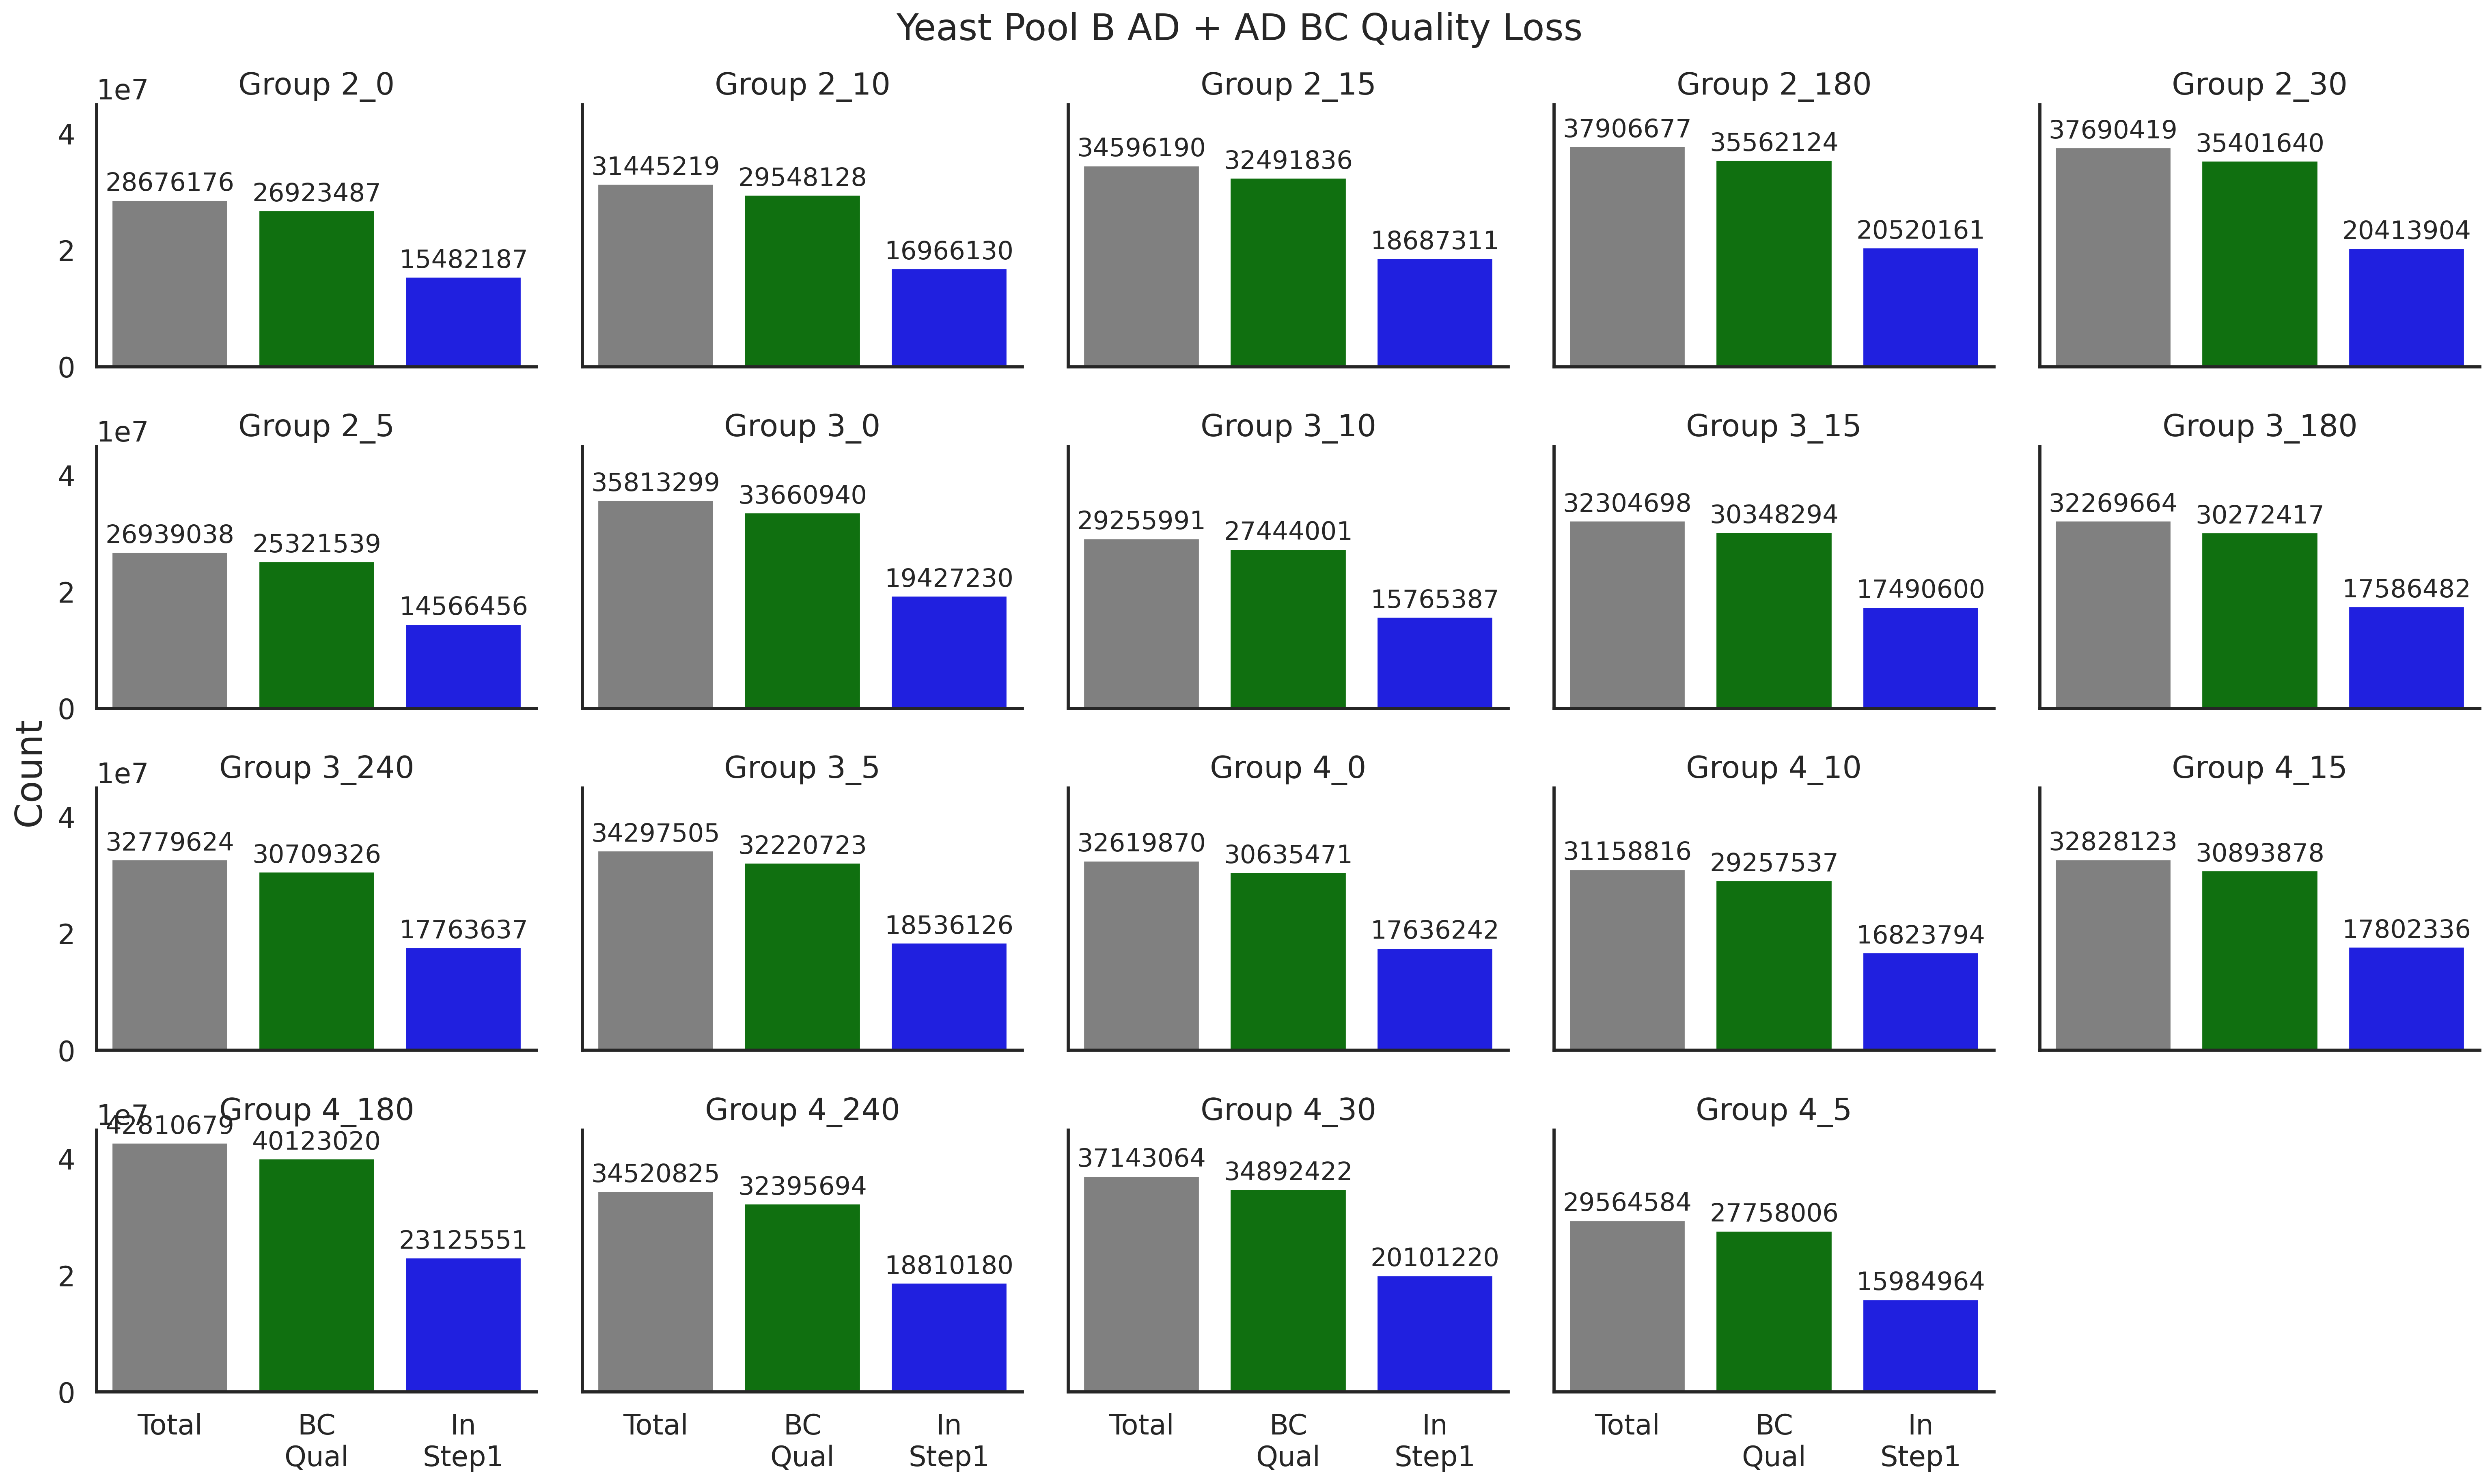

In [125]:
fig, axes = plt.subplots(4, 5, figsize=(21,12), dpi=300, sharey=True, sharex=True)
axes = axes.flatten()  # flatten to index easily 0..9 (2*5)

for i, prefix in enumerate(yeast_pool_B_AD_prefixes):
    file_name = prefix[:-12] + "_initial"  # construct your "maps" table/file name

    # Query total counts
    total_count = con.execute(f"SELECT COUNT(*) FROM {file_name}").fetchone()[0]

    # Query number of rows where both BC and AD are qualified
    both_true = con.execute(f"""
        SELECT COUNT(*) 
        FROM {file_name} 
        WHERE AD_BC_qual AND AD_qual
    """).fetchone()[0]

    # Query number of rows in Step1 map
    step1_count = con.execute(f"""
        SELECT COUNT(*) 
        FROM {file_name} AS m
        JOIN step1_AD_AD_BC_RPTR_BC_designed AS s
        ON m.AD_BC = s.AD_BC AND m.AD = s.AD
    """).fetchone()[0]

    print(f"{file_name} step1 count: {step1_count}")

    # Prepare DataFrame for plotting
    plot_counts = pd.DataFrame({
        "Category": ["Total", "BC\nQual", "In\nStep1"],
        "Count": [total_count, both_true, step1_count]
    })

    ax = axes[i]
    sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green", "blue"])
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)

    ax.set_title("Group " + str(re.search(r'(\d+_\d+)', file_name)[0]), fontsize='medium')
    ax.set_xlabel("")
    ax.set_ylabel("")

axes[-1].set_visible(False)

fig.supylabel("Count")
sns.despine()
plt.tight_layout(pad = 1)
fig.suptitle("Yeast Pool B AD + AD BC Quality Loss", y = 1.02)
plt.savefig(os.path.join(yeast_pool_B_output_path + "/figures", f"AD_AD_BC_quality_loss.png"))
plt.show()

trebl_experiment_yeast_pool_B_RPTR_2_0_S63_RPTR_BC_initial step1 count: 15082629
trebl_experiment_yeast_pool_B_RPTR_2_10_S65_RPTR_BC_initial step1 count: 21066721
trebl_experiment_yeast_pool_B_RPTR_2_240_S69_RPTR_BC_initial step1 count: 17809326
trebl_experiment_yeast_pool_B_RPTR_2_30_S67_RPTR_BC_initial step1 count: 15792208
trebl_experiment_yeast_pool_B_RPTR_2_5_S64_RPTR_BC_initial step1 count: 17672973
trebl_experiment_yeast_pool_B_RPTR_3_0_S70_RPTR_BC_initial step1 count: 14628360
trebl_experiment_yeast_pool_B_RPTR_3_10_S72_RPTR_BC_initial step1 count: 20902817
trebl_experiment_yeast_pool_B_RPTR_3_180_S74_RPTR_BC_initial step1 count: 17812207
trebl_experiment_yeast_pool_B_RPTR_3_5_S71_RPTR_BC_initial step1 count: 17987921
trebl_experiment_yeast_pool_B_RPTR_4_0_S76_RPTR_BC_initial step1 count: 18040370
trebl_experiment_yeast_pool_B_RPTR_4_10_S78_RPTR_BC_initial step1 count: 19148292
trebl_experiment_yeast_pool_B_RPTR_4_15_S79_RPTR_BC_initial step1 count: 17227290
trebl_experiment_ye

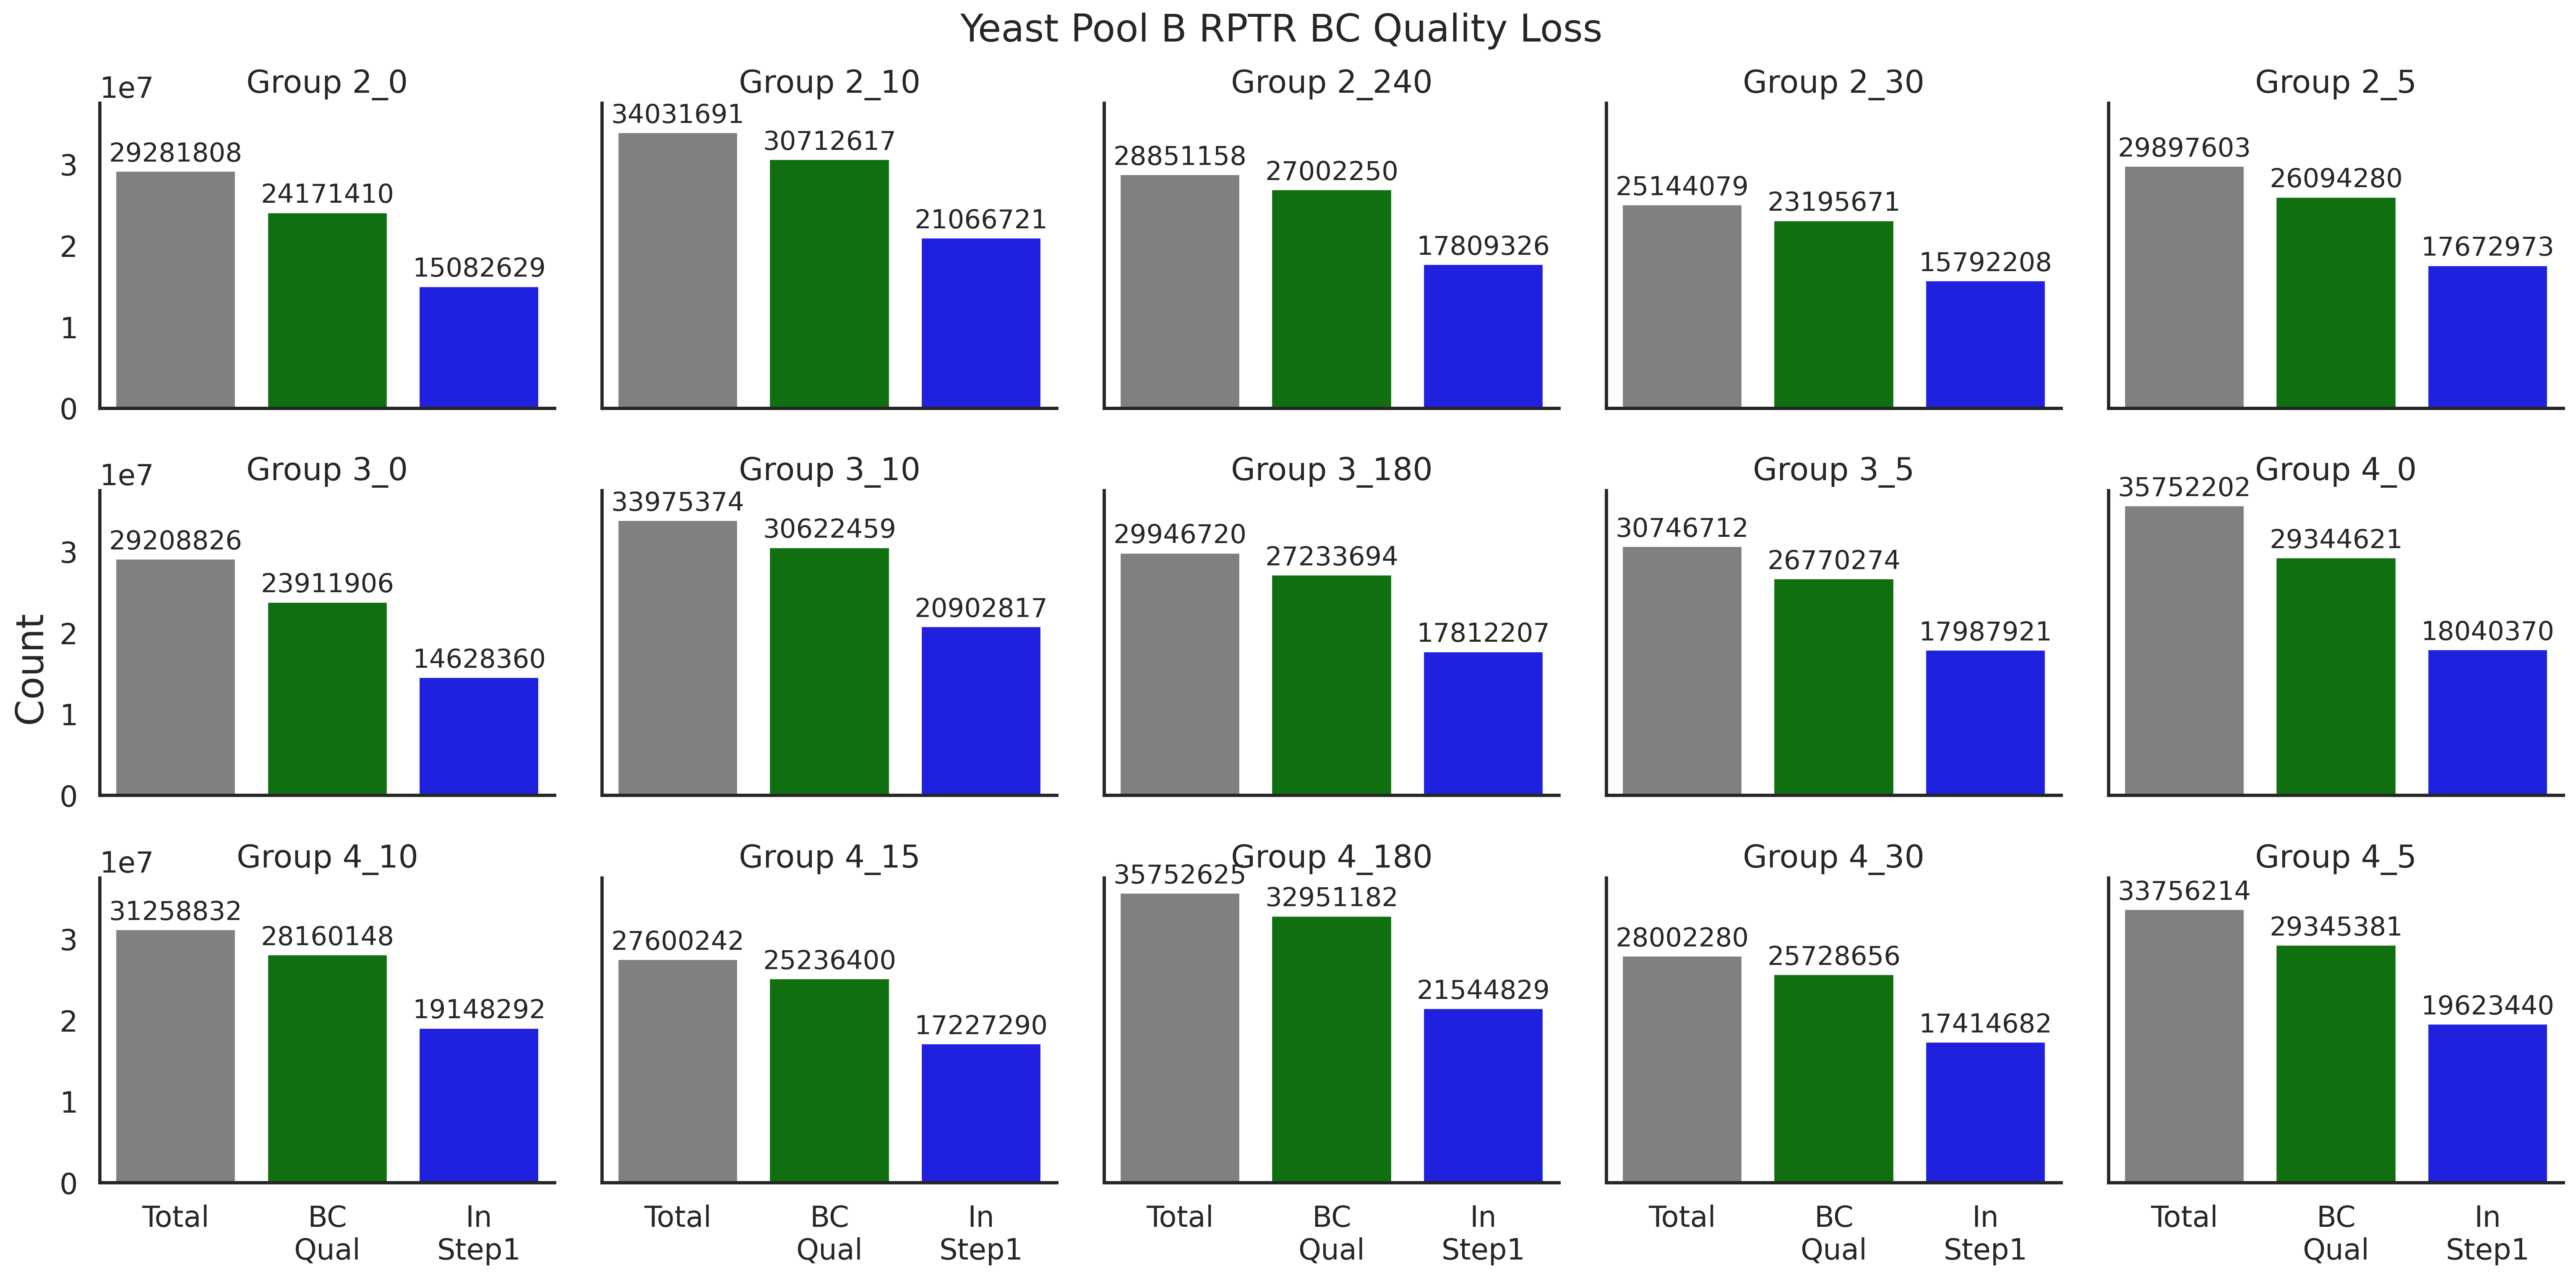

In [126]:
fig, axes = plt.subplots(3, 5, figsize=(21,10), dpi=300, sharey=True, sharex=True)
axes = axes.flatten()  # flatten to index easily 0..9 (2*5)

for i, prefix in enumerate(yeast_pool_B_RPTR_prefixes):
    file_name = prefix[:-12] + "_initial"  # construct your "maps" table/file name

    # Query total counts
    total_count = con.execute(f"SELECT COUNT(*) FROM {file_name}").fetchone()[0]

    # Query number of rows where both BC and AD are qualified
    true_count = con.execute(f"""
        SELECT COUNT(*) 
        FROM {file_name} 
        WHERE RPTR_BC_qual
    """).fetchone()[0]

    # Query number of rows in Step1 map
    step1_count = con.execute(f"""
        SELECT COUNT(*) 
        FROM {file_name} AS m
        JOIN step1_AD_AD_BC_RPTR_BC_designed AS s
        ON m.RPTR_BC = s.RPTR_BC
    """).fetchone()[0]

    print(f"{file_name} step1 count: {step1_count}")

    # Prepare DataFrame for plotting
    plot_counts = pd.DataFrame({
        "Category": ["Total", "BC\nQual", "In\nStep1"],
        "Count": [total_count, true_count, step1_count]
    })

    ax = axes[i]
    sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green", "blue"])
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)

    ax.set_title("Group " + str(re.search(r'(\d+_\d+)', file_name)[0]), fontsize='medium')
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.supylabel("Count")
sns.despine()
plt.tight_layout(pad = 1)
fig.suptitle("Yeast Pool B RPTR BC Quality Loss", y = 1.02)
plt.savefig(os.path.join(yeast_pool_B_output_path + "/figures", f"RPTR_BC_quality_loss.png"))
plt.show()

## Yeast Pool C

### 1. PolyT ** Save loss figures **

In [10]:
yeast_pool_C_PolyT_AD_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Sep2024/ciber2_iii_MZ001/EC_Ciber2_iii_Gcn4/results/assembled/AD/*")
yeast_pool_C_PolyT_RT_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Sep2024/ciber2_iii_MZ001/EC_Ciber2_iii_Gcn4/results/assembled/RPTR/*")
yeast_pool_C_PolyT_output_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_PolyT" # May need to change to your directory due to writing permissions

#### 1A. AD + ADBC

##### Submitted job with /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/GCN4/yeast_pool_C_PolyT_trebl_experiment.py

AD_2_240_S7_L001
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_PolyT/trebl_experiment_yeast_pool_C_PolyT_AD_2_240_S7_L001
Reading 1 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 1.31 minutes.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 26.88 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CGCGCC(.{1,11})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 24.25 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 13.05 seconds.

Mapping complete.
trebl_experiment_yeast_pool_C_PolyT_AD_2_240_S7_L001_AD_AD_BC_initial
Total rows: 31562436


AD  AD_qual        AD_BC  \
0  CAAATGAACTCATTTGTTGATGGTAAATTTAGATTGTTTGAGTTCT...     True  GGAGAGGTACG   
1  AGAGAATTTATTAATGGTATGGCTGAAGTTATTAAGACTGCTGCTA...     True  AGTTGCGTATA   
2  GCTTCTCCAGCTAATCAAACTTATGATTTGTCTTCTTCTGTTCCAT...     True  TCGCCCACGCG   
3  CACTTTGATGTTTCTCCATTTGTTGGTGATGGTGATTTGGATCAAT...     True                
4  TTGGTTCAAGAACCATTTATGTCTGCTCCAAATTCTGCTGCTTTGA...     True  ATCGAAACAAA   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3       False         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_C_PolyT_AD_2_240_S7_L001_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_C_PolyT_AD_2_240_S7_L001_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. designed
4. grouped
5. thresholded


Filtering to high-quality reads...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_C_PolyT_AD_2_240_S7_L001_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 28.95 seconds.


Filtering to designed sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_C_PolyT_AD_2_240_S7_L001_AD_AD_BC_designed — kept only Designed == 1.
Done in 27.52 seconds.

Grouping trebl_experiment_yeast_pool_C_PolyT_AD_2_240_S7_L001_AD_AD_BC_designed...


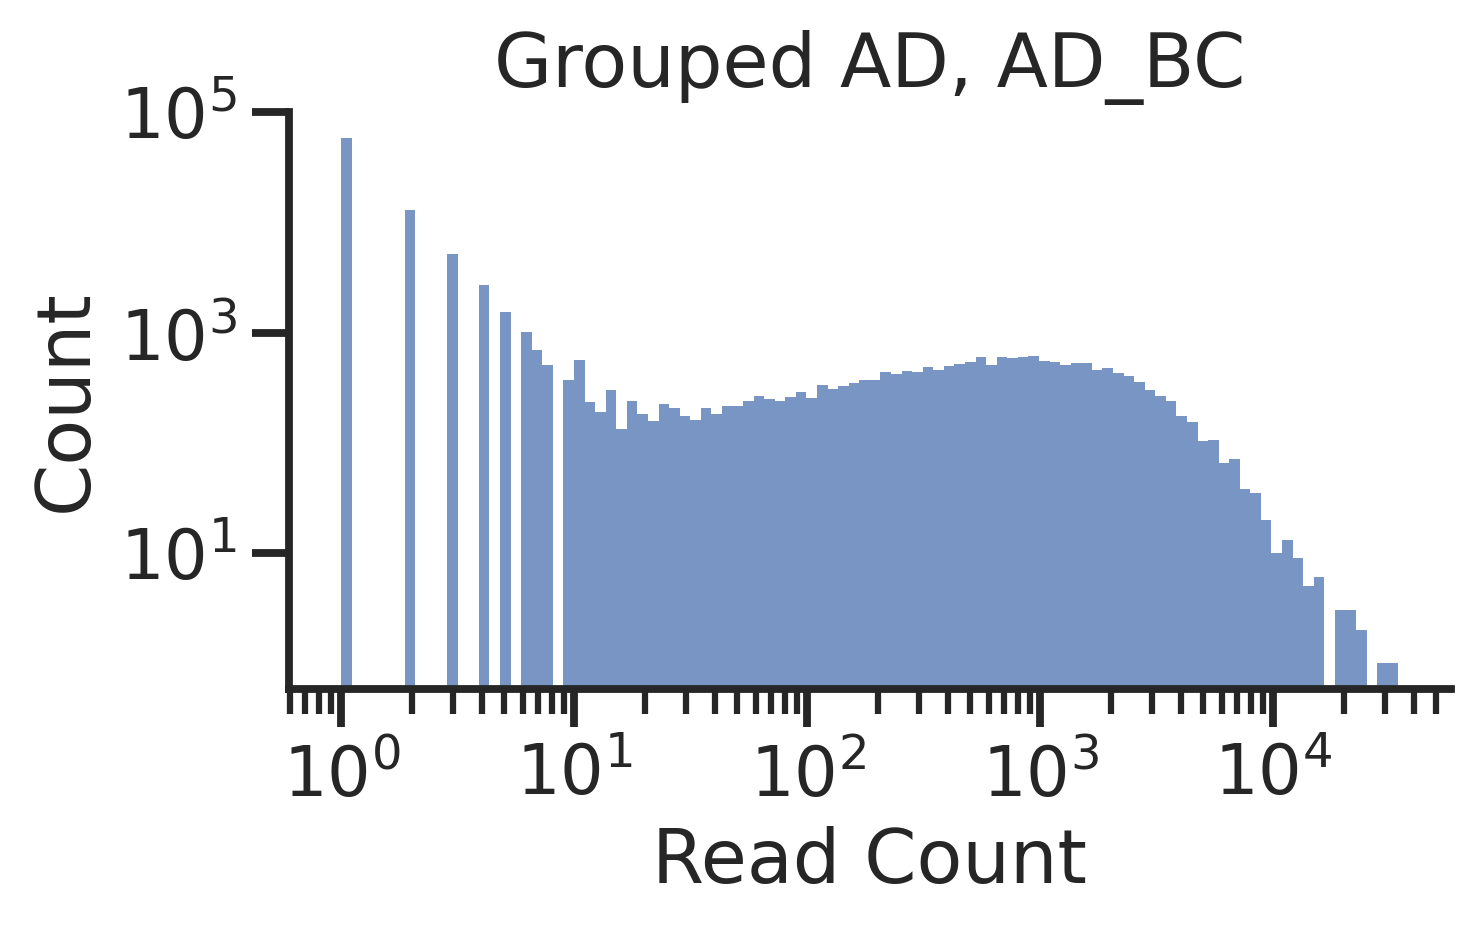

Done in 0.98 seconds.

Thresholding...


Enter minimum read count threshold (default = 5):  20


Using reads threshold of 20.


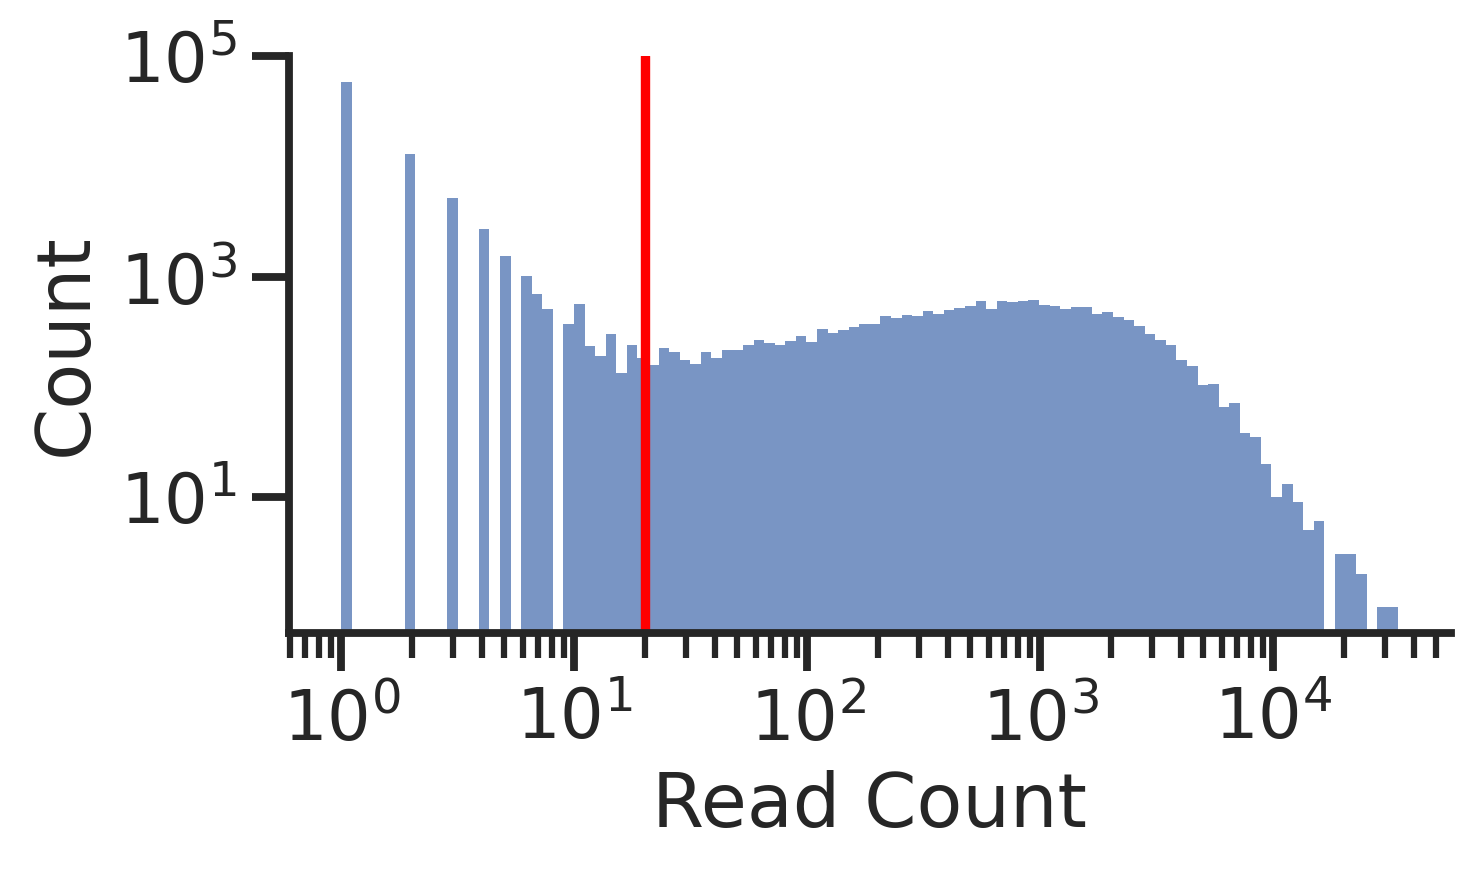

Done in 2.72 minutes.

Done.
AD_3_5_S9_L001
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_PolyT/trebl_experiment_yeast_pool_C_PolyT_AD_3_5_S9_L001
Reading 1 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 1.27 minutes.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 23.12 seconds.

Extracting 2 barcodes...
GGCTAGC(.{1,120})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CGCGCC(.{1,11})


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 24.21 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 13.10 seconds.

Mapping complete.
trebl_experiment_yeast_pool_C_PolyT_AD_3_5_S9_L001_AD_AD_BC_initial
Total rows: 30065487


AD  AD_qual        AD_BC  \
0  CATTCTCCACATTTGAATCAACAAGCTCCAGATGCTCAACCACATC...     True  GCCACACCTCC   
1  CATTCTCCACATTTGAATCAACAAGCTCCAGATGCTCAACCACATC...     True  GCCACACCTCC   
2  CAAACTGCTAAGATGATGAATGCTGCTGGTTTGTCTCCACCAACTA...     True  TTCCGATCTCC   
3  AATGCTGATGCTGATTTGGCTGGTCAAGATGCTTGGTTCTCTTTGT...     True  GATAGAAATAT   
4  AGAGATTCTCAACAATTGGCTGATTTGGATTTGTTTGATGACTTTA...     True  CCACCCCTTCC   

   AD_BC_qual  Designed  
0        True         1  
1        True         1  
2        True         1  
3        True         1  
4        True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_C_PolyT_AD_3_5_S9_L001_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_C_PolyT_AD_3_5_S9_L001_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. designed
4. grouped
5. thresholded


Filtering to high-quality reads...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_C_PolyT_AD_3_5_S9_L001_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 21.78 seconds.


Filtering to designed sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: trebl_experiment_yeast_pool_C_PolyT_AD_3_5_S9_L001_AD_AD_BC_designed — kept only Designed == 1.
Done in 25.25 seconds.

Grouping trebl_experiment_yeast_pool_C_PolyT_AD_3_5_S9_L001_AD_AD_BC_designed...


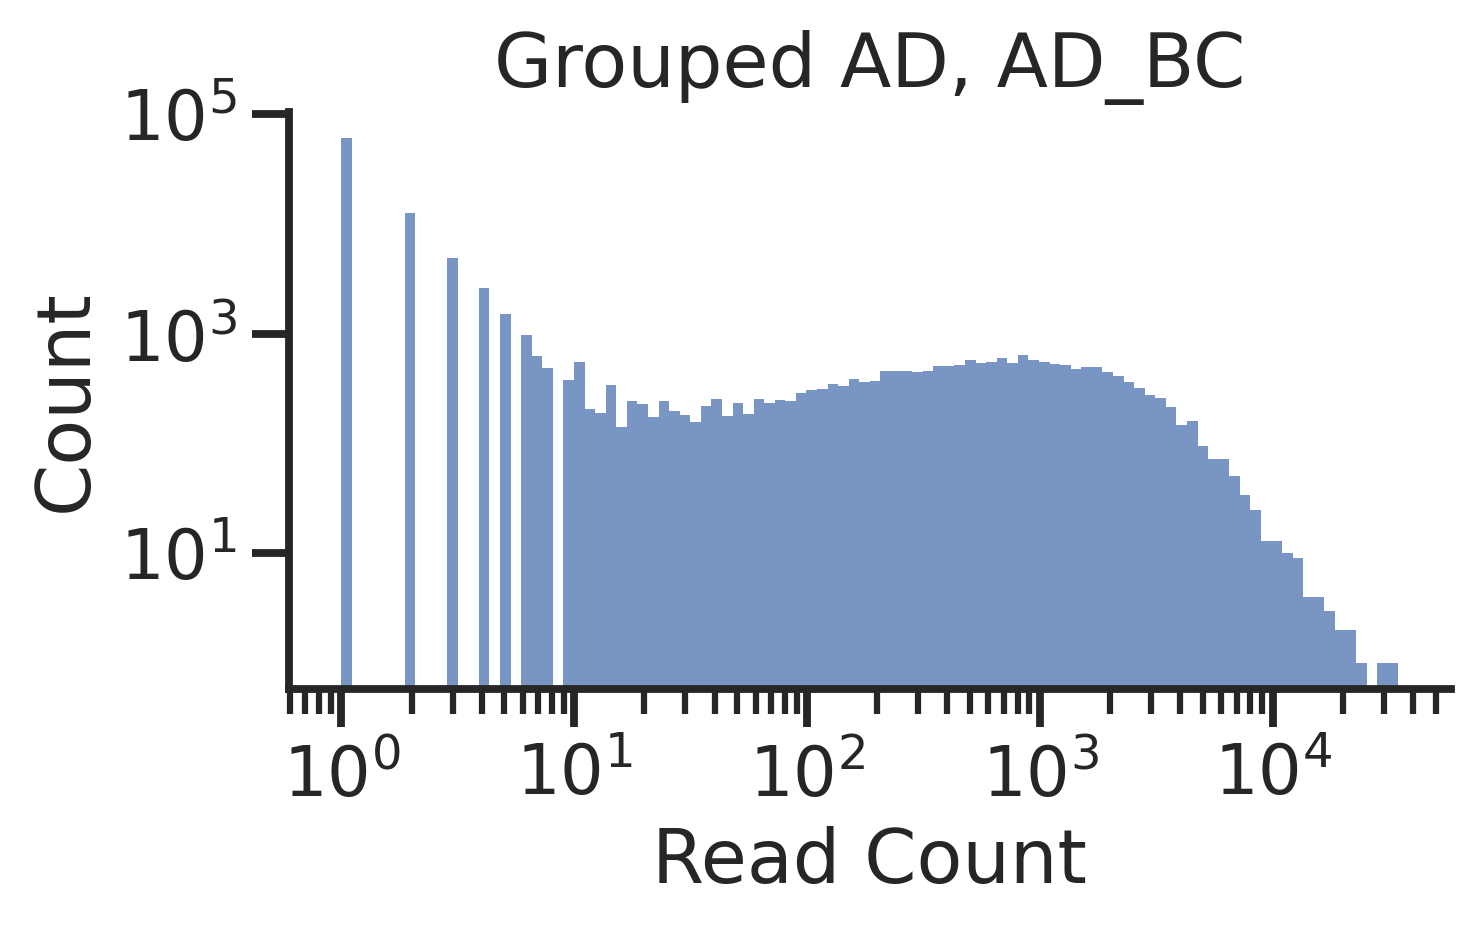

Done in 1.22 seconds.

Thresholding...


Enter minimum read count threshold (default = 5):  20


Using reads threshold of 20.


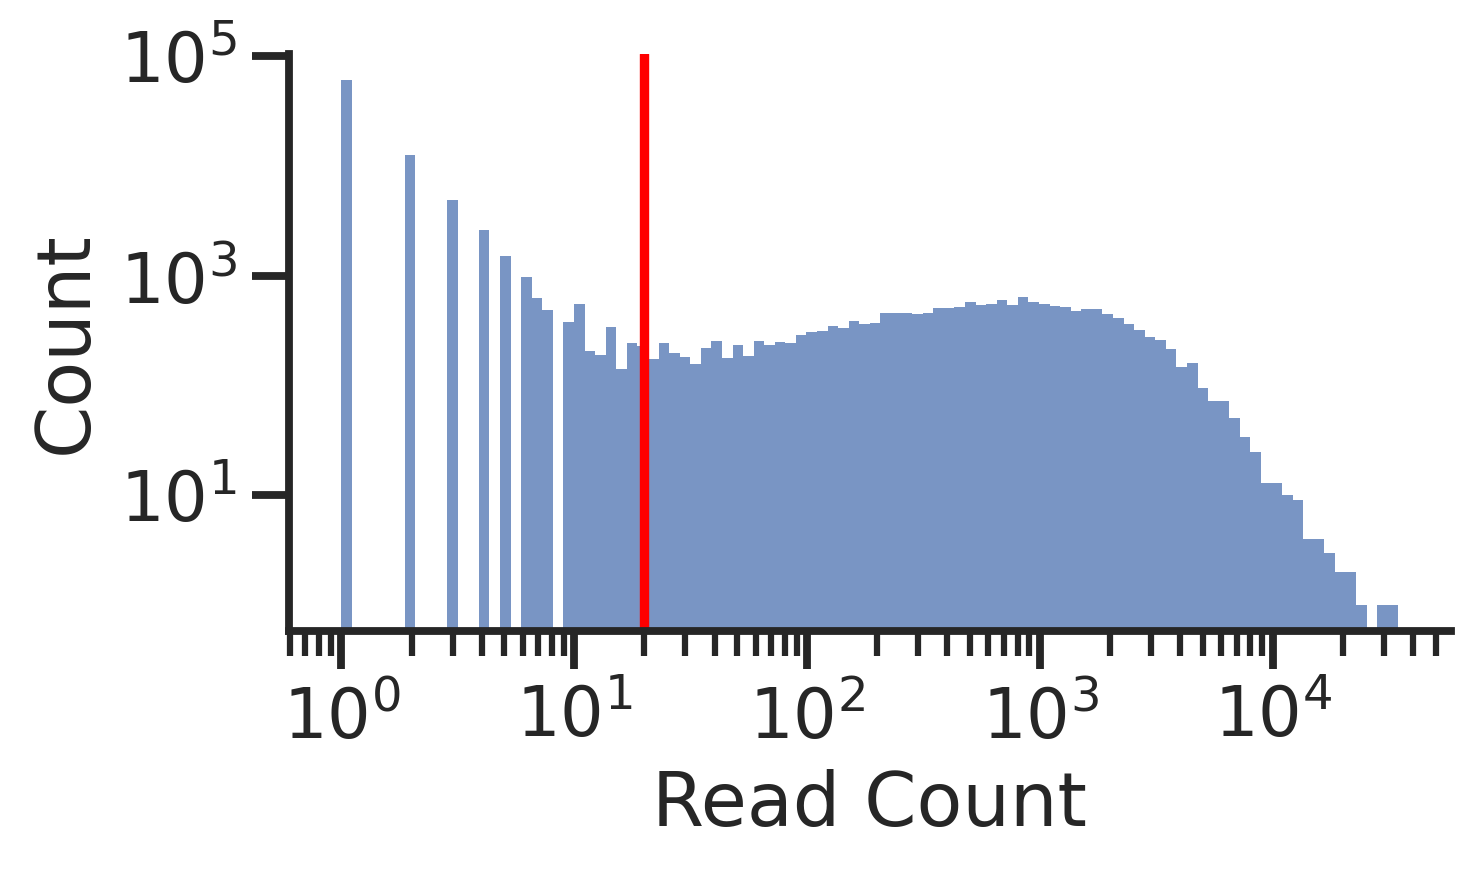

Done in 4.22 seconds.

Done.
AD_4_5_S16_L001
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_PolyT/trebl_experiment_yeast_pool_C_PolyT_AD_4_5_S16_L001
Reading 1 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/traitlets/traitlets.py(720): __set__
  /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/GCN4/../../scripts/initial_map.py(80): read_fastq
  /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/GCN4/../../scripts/preprocess.py(19): wrapper
  /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/GCN4/../../scripts/initial_map.py(181): create_map
  /tmp/ipykernel_2689413/1576636777.py(24): <module>
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3553): run_code
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3493): run_ast_nodes
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3311): run_cell_async
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3106): _run_cell
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3051): run_cell
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/ipykernel/zmqshell.py(549): run_cell
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/ipykernel/ipkernel.py(429): do_execute
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/ipykernel/kernelbase.py(767): execute_request
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/ipykernel/kernelbase.py(429): dispatch_shell
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/ipykernel/kernelbase.py(523): process_one
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/ipykernel/kernelbase.py(534): dispatch_queue
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/asyncio/events.py(80): _run
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/asyncio/base_events.py(1922): _run_once
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/asyncio/base_events.py(607): run_forever
  /global/home/users/sanjanakotha/.local/lib/python3.11/site-packages/tornado/platform/asyncio.py(205): start
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/ipykernel/kernelapp.py(701): start
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/traitlets/config/application.py(992): launch_instance
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/ipykernel_launcher.py(17): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main


In [9]:
AD_objects = [EC_AD, EC_AD_BC]

complex_AD_results = []
simple_AD_results = []

for file_path in yeast_pool_C_PolyT_AD_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0].replace("-", "_") # Need this replace part because otherwise gets weird
    print(name_only) 

    # Get the file naeme to use for output
    file_output_path = os.path.join(yeast_pool_C_PolyT_output_path, f"trebl_experiment_yeast_pool_C_PolyT_{name_only}")
    print(file_output_path)

    # Extract UMIs and barcodes from reads
    bc_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"trebl_experiment_yeast_pool_C_PolyT_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = "/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/A10_sequencing/v2/current/a10_designfile.csv",
                                       bc_objects = AD_objects,
                                       reverse_complement = True)
    bc_mapper.create_map()
    display(bc_mapper.preview_map())

    # # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=AD_objects,
                                        column_pairs = [],
                                        map_order = ['quality', 'designed', 'grouped', 'thresholded'],
                                        step_name=f"trebl_experiment_yeast_pool_C_PolyT_{name_only}", 
                                        descriptor = "",
                                        should_check_exists = False,
                                        design_check = True, reads_threshold = 20)
    refiner.refine_map_from_db()    

#### 2. RTBC

##### Submitted job with /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/GCN4/yeast_pool_C_PolyT_trebl_experiment.py

### BC Quality loss

In [8]:
tables = refiner.show_tables()
#tables

NameError: name 'refiner' is not defined

In [140]:
yeast_pool_C_polyT_AD_prefixes = []
yeast_pool_C_polyT_RPTR_prefixes = []

for table in tables:
    if "trebl_experiment_yeast_pool_C_PolyT" in table[0] and "thresholded" in table[0]:
        if "RPTR" in table[0]:
            yeast_pool_C_polyT_RPTR_prefixes.append(table[0])
        if "AD" in table[0]:
            yeast_pool_C_polyT_AD_prefixes.append(table[0])

In [144]:
len(yeast_pool_C_polyT_AD_prefixes)

21

In [143]:
len(yeast_pool_C_polyT_RPTR_prefixes)

21

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_2_0_S1_L001_AD_AD_BC_initial step1 count: 17704127
trebl_experiment_yeast_pool_C_PolyT_AD_2_10_S3_L001_AD_AD_BC_initial step1 count: 15018990
trebl_experiment_yeast_pool_C_PolyT_AD_2_15_S4_L001_AD_AD_BC_initial step1 count: 15696472


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_2_180_S6_L001_AD_AD_BC_initial step1 count: 15178180


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_2_240_S7_L001_AD_AD_BC_initial step1 count: 17113986


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_2_30_S5_L001_AD_AD_BC_initial step1 count: 14350860


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_2_5_S2_L001_AD_AD_BC_initial step1 count: 17039651


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_3_0_S8_L001_AD_AD_BC_initial step1 count: 17841709


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_3_10_S10_L001_AD_AD_BC_initial step1 count: 14961613
trebl_experiment_yeast_pool_C_PolyT_AD_3_15_S11_L001_AD_AD_BC_initial step1 count: 16196733


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_3_180_S13_L001_AD_AD_BC_initial step1 count: 17306901


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_3_240_S14_L001_AD_AD_BC_initial step1 count: 16194309


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_3_30_S12_L001_AD_AD_BC_initial step1 count: 17807903


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_3_5_S9_L001_AD_AD_BC_initial step1 count: 16195490


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_4_0_S15_L001_AD_AD_BC_initial step1 count: 15089780


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_4_10_S17_L001_AD_AD_BC_initial step1 count: 15879041


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_4_15_S18_L001_AD_AD_BC_initial step1 count: 16592519
trebl_experiment_yeast_pool_C_PolyT_AD_4_180_S20_L001_AD_AD_BC_initial step1 count: 16557045


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_4_240_S21_L001_AD_AD_BC_initial step1 count: 16943545


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_4_30_S19_L001_AD_AD_BC_initial step1 count: 16258941


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

trebl_experiment_yeast_pool_C_PolyT_AD_4_5_S16_L001_AD_AD_BC_initial step1 count: 16404581


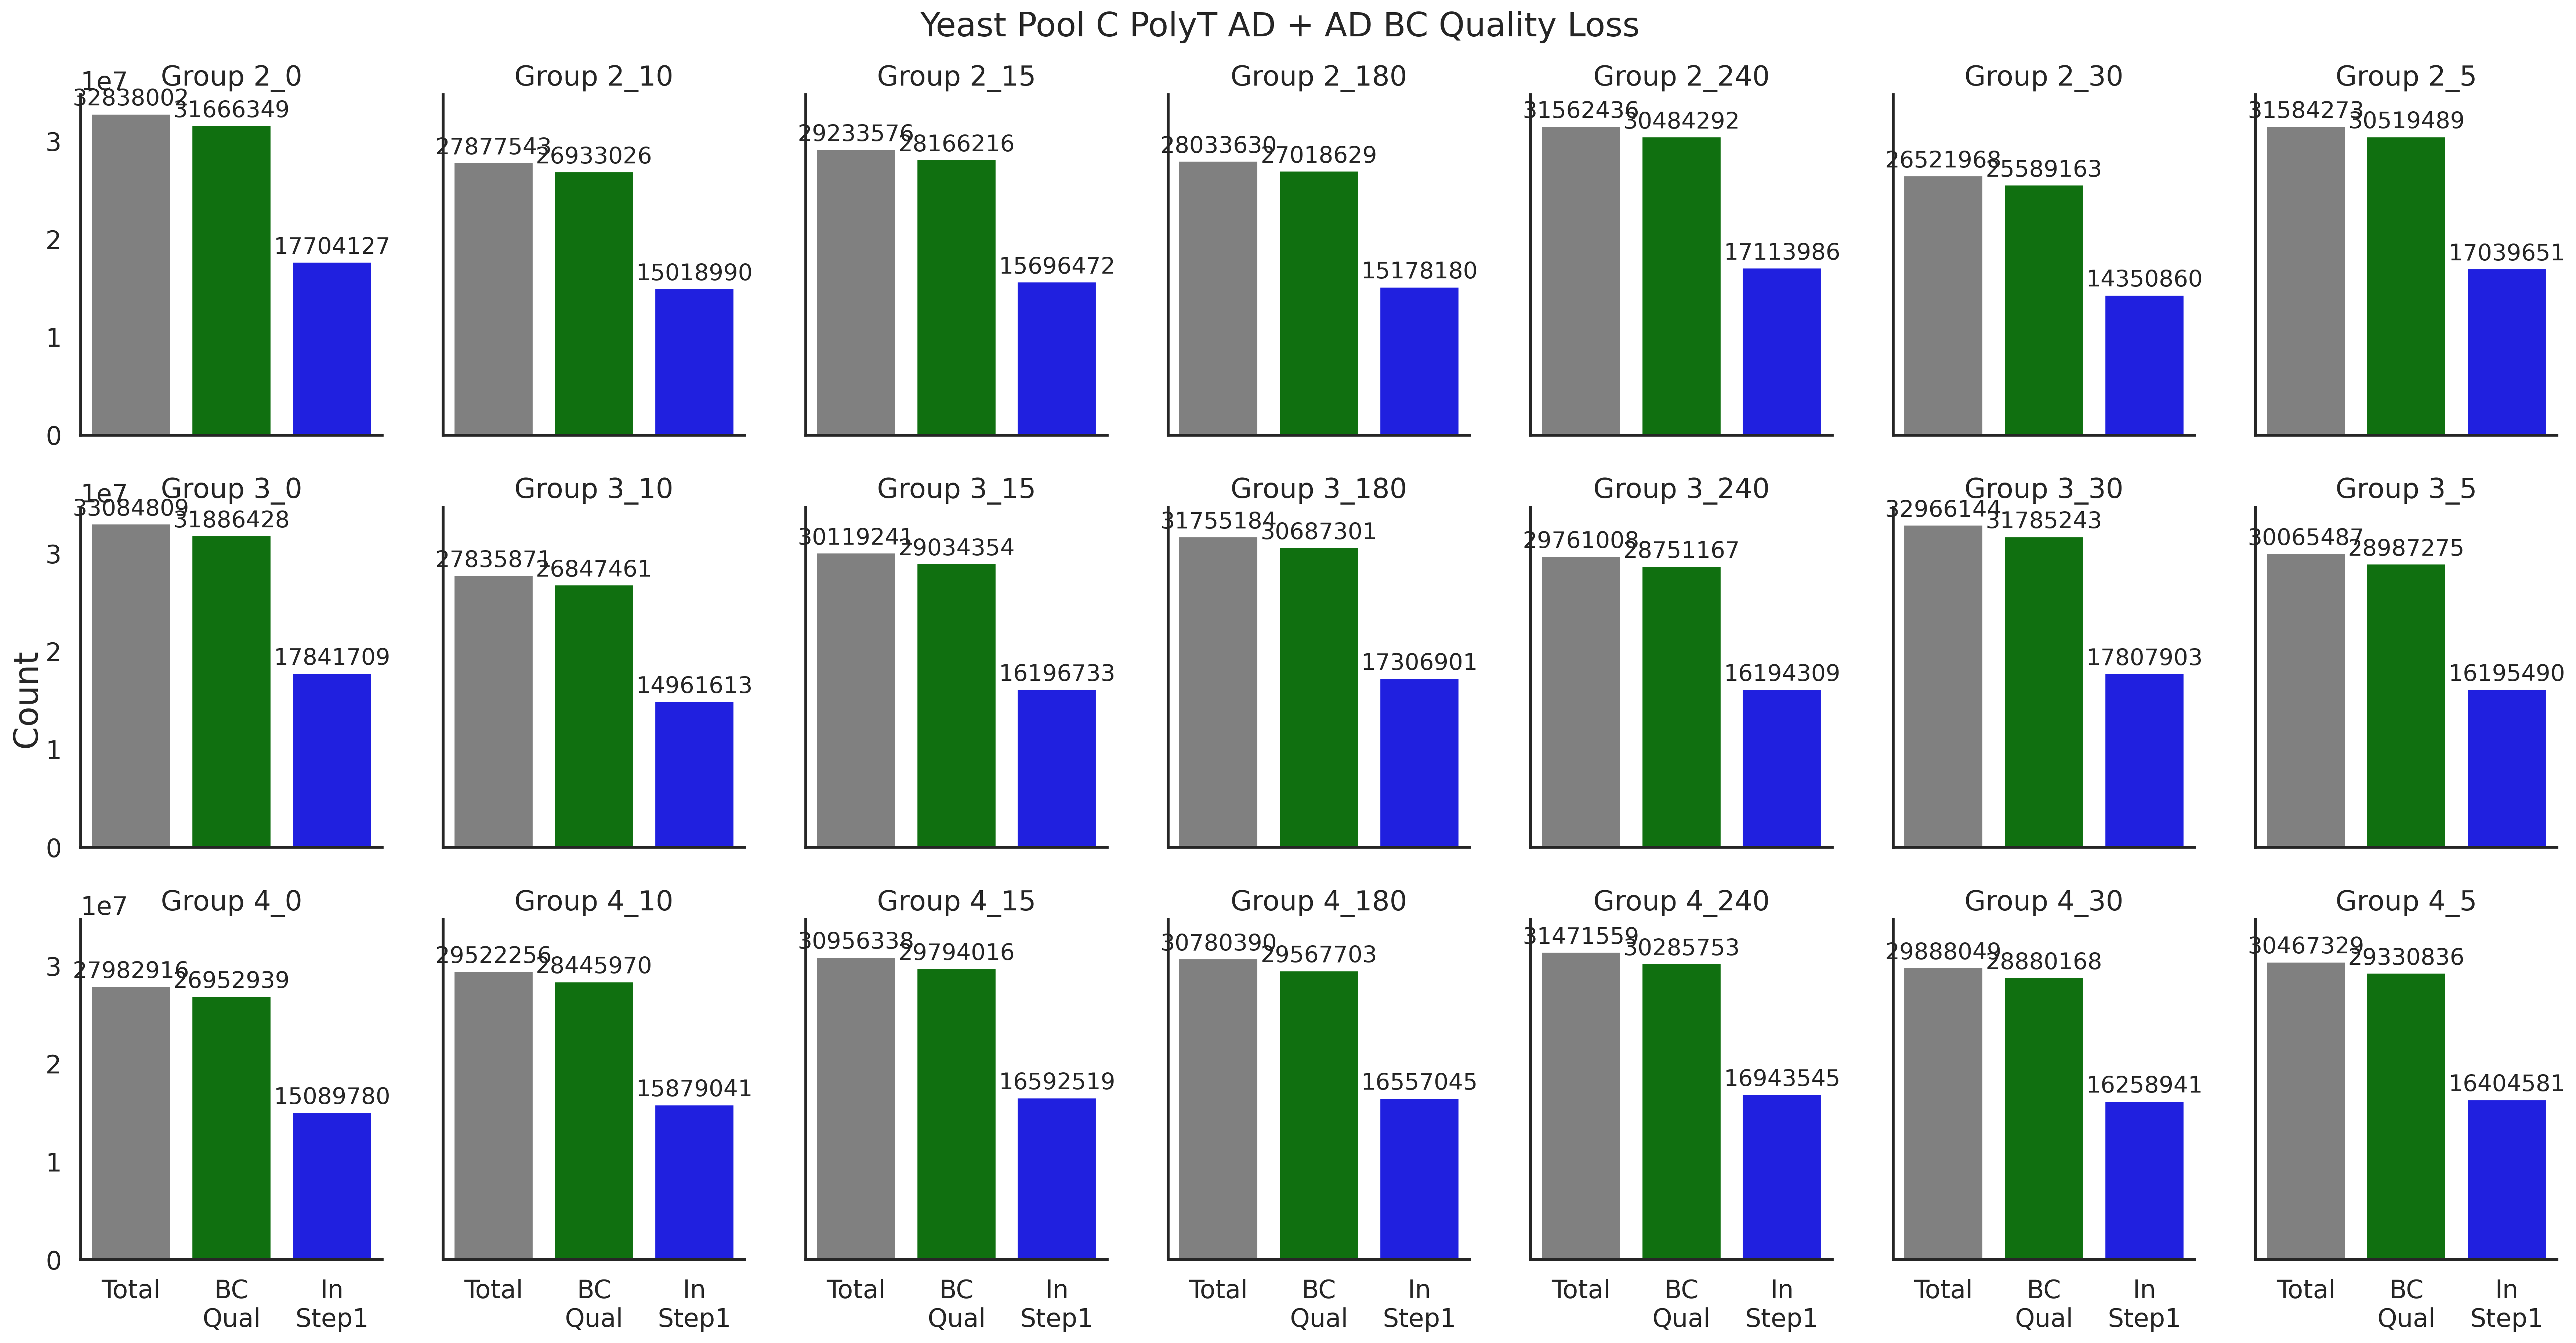

In [155]:
fig, axes = plt.subplots(3, 7, figsize=(24,12), dpi=300, sharey=True, sharex=True)
axes = axes.flatten()  # flatten to index easily 0..9 (2*5)

for i, prefix in enumerate(yeast_pool_C_polyT_AD_prefixes):
    file_name = prefix[:-12] + "_initial"  # construct your "maps" table/file name

    # Query total counts
    total_count = con.execute(f"SELECT COUNT(*) FROM {file_name}").fetchone()[0]

    # Query number of rows where both BC and AD are qualified
    both_true = con.execute(f"""
        SELECT COUNT(*) 
        FROM {file_name} 
        WHERE AD_BC_qual AND AD_qual
    """).fetchone()[0]

    # Query number of rows in Step1 map
    step1_count = con.execute(f"""
        SELECT COUNT(*) 
        FROM {file_name} AS m
        JOIN step1_AD_AD_BC_RPTR_BC_designed AS s
        ON m.AD_BC = s.AD_BC AND m.AD = s.AD
    """).fetchone()[0]

    print(f"{file_name} step1 count: {step1_count}")

    # Prepare DataFrame for plotting
    plot_counts = pd.DataFrame({
        "Category": ["Total", "BC\nQual", "In\nStep1"],
        "Count": [total_count, both_true, step1_count]
    })

    ax = axes[i]
    sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green", "blue"])
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)

    ax.set_title("Group " + str(re.search(r'(\d+_\d+)', file_name)[0]), fontsize='medium')
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.supylabel("Count")
sns.despine()
plt.tight_layout(pad = 1)
fig.suptitle("Yeast Pool C PolyT AD + AD BC Quality Loss", y = 1.02)
plt.savefig(os.path.join(yeast_pool_C_PolyT_output_path + "/figures", f"AD_AD_BC_quality_loss.png"))
plt.show()

trebl_experiment_yeast_pool_C_PolyT_RPTR_2_0_S22_L001_RPTR_BC_initial step1 count: 11724847
trebl_experiment_yeast_pool_C_PolyT_RPTR_2_10_S24_L001_RPTR_BC_initial step1 count: 15732325
trebl_experiment_yeast_pool_C_PolyT_RPTR_2_15_S25_L001_RPTR_BC_initial step1 count: 16183470
trebl_experiment_yeast_pool_C_PolyT_RPTR_2_180_S27_L001_RPTR_BC_initial step1 count: 18178332
trebl_experiment_yeast_pool_C_PolyT_RPTR_2_240_S28_L001_RPTR_BC_initial step1 count: 17865307
trebl_experiment_yeast_pool_C_PolyT_RPTR_2_30_S26_L001_RPTR_BC_initial step1 count: 16556117
trebl_experiment_yeast_pool_C_PolyT_RPTR_2_5_S23_L001_RPTR_BC_initial step1 count: 13869182
trebl_experiment_yeast_pool_C_PolyT_RPTR_3_0_S29_L001_RPTR_BC_initial step1 count: 11045549
trebl_experiment_yeast_pool_C_PolyT_RPTR_3_10_S31_L001_RPTR_BC_initial step1 count: 16024650
trebl_experiment_yeast_pool_C_PolyT_RPTR_3_15_S32_L001_RPTR_BC_initial step1 count: 18063384
trebl_experiment_yeast_pool_C_PolyT_RPTR_3_180_S34_L001_RPTR_BC_initial

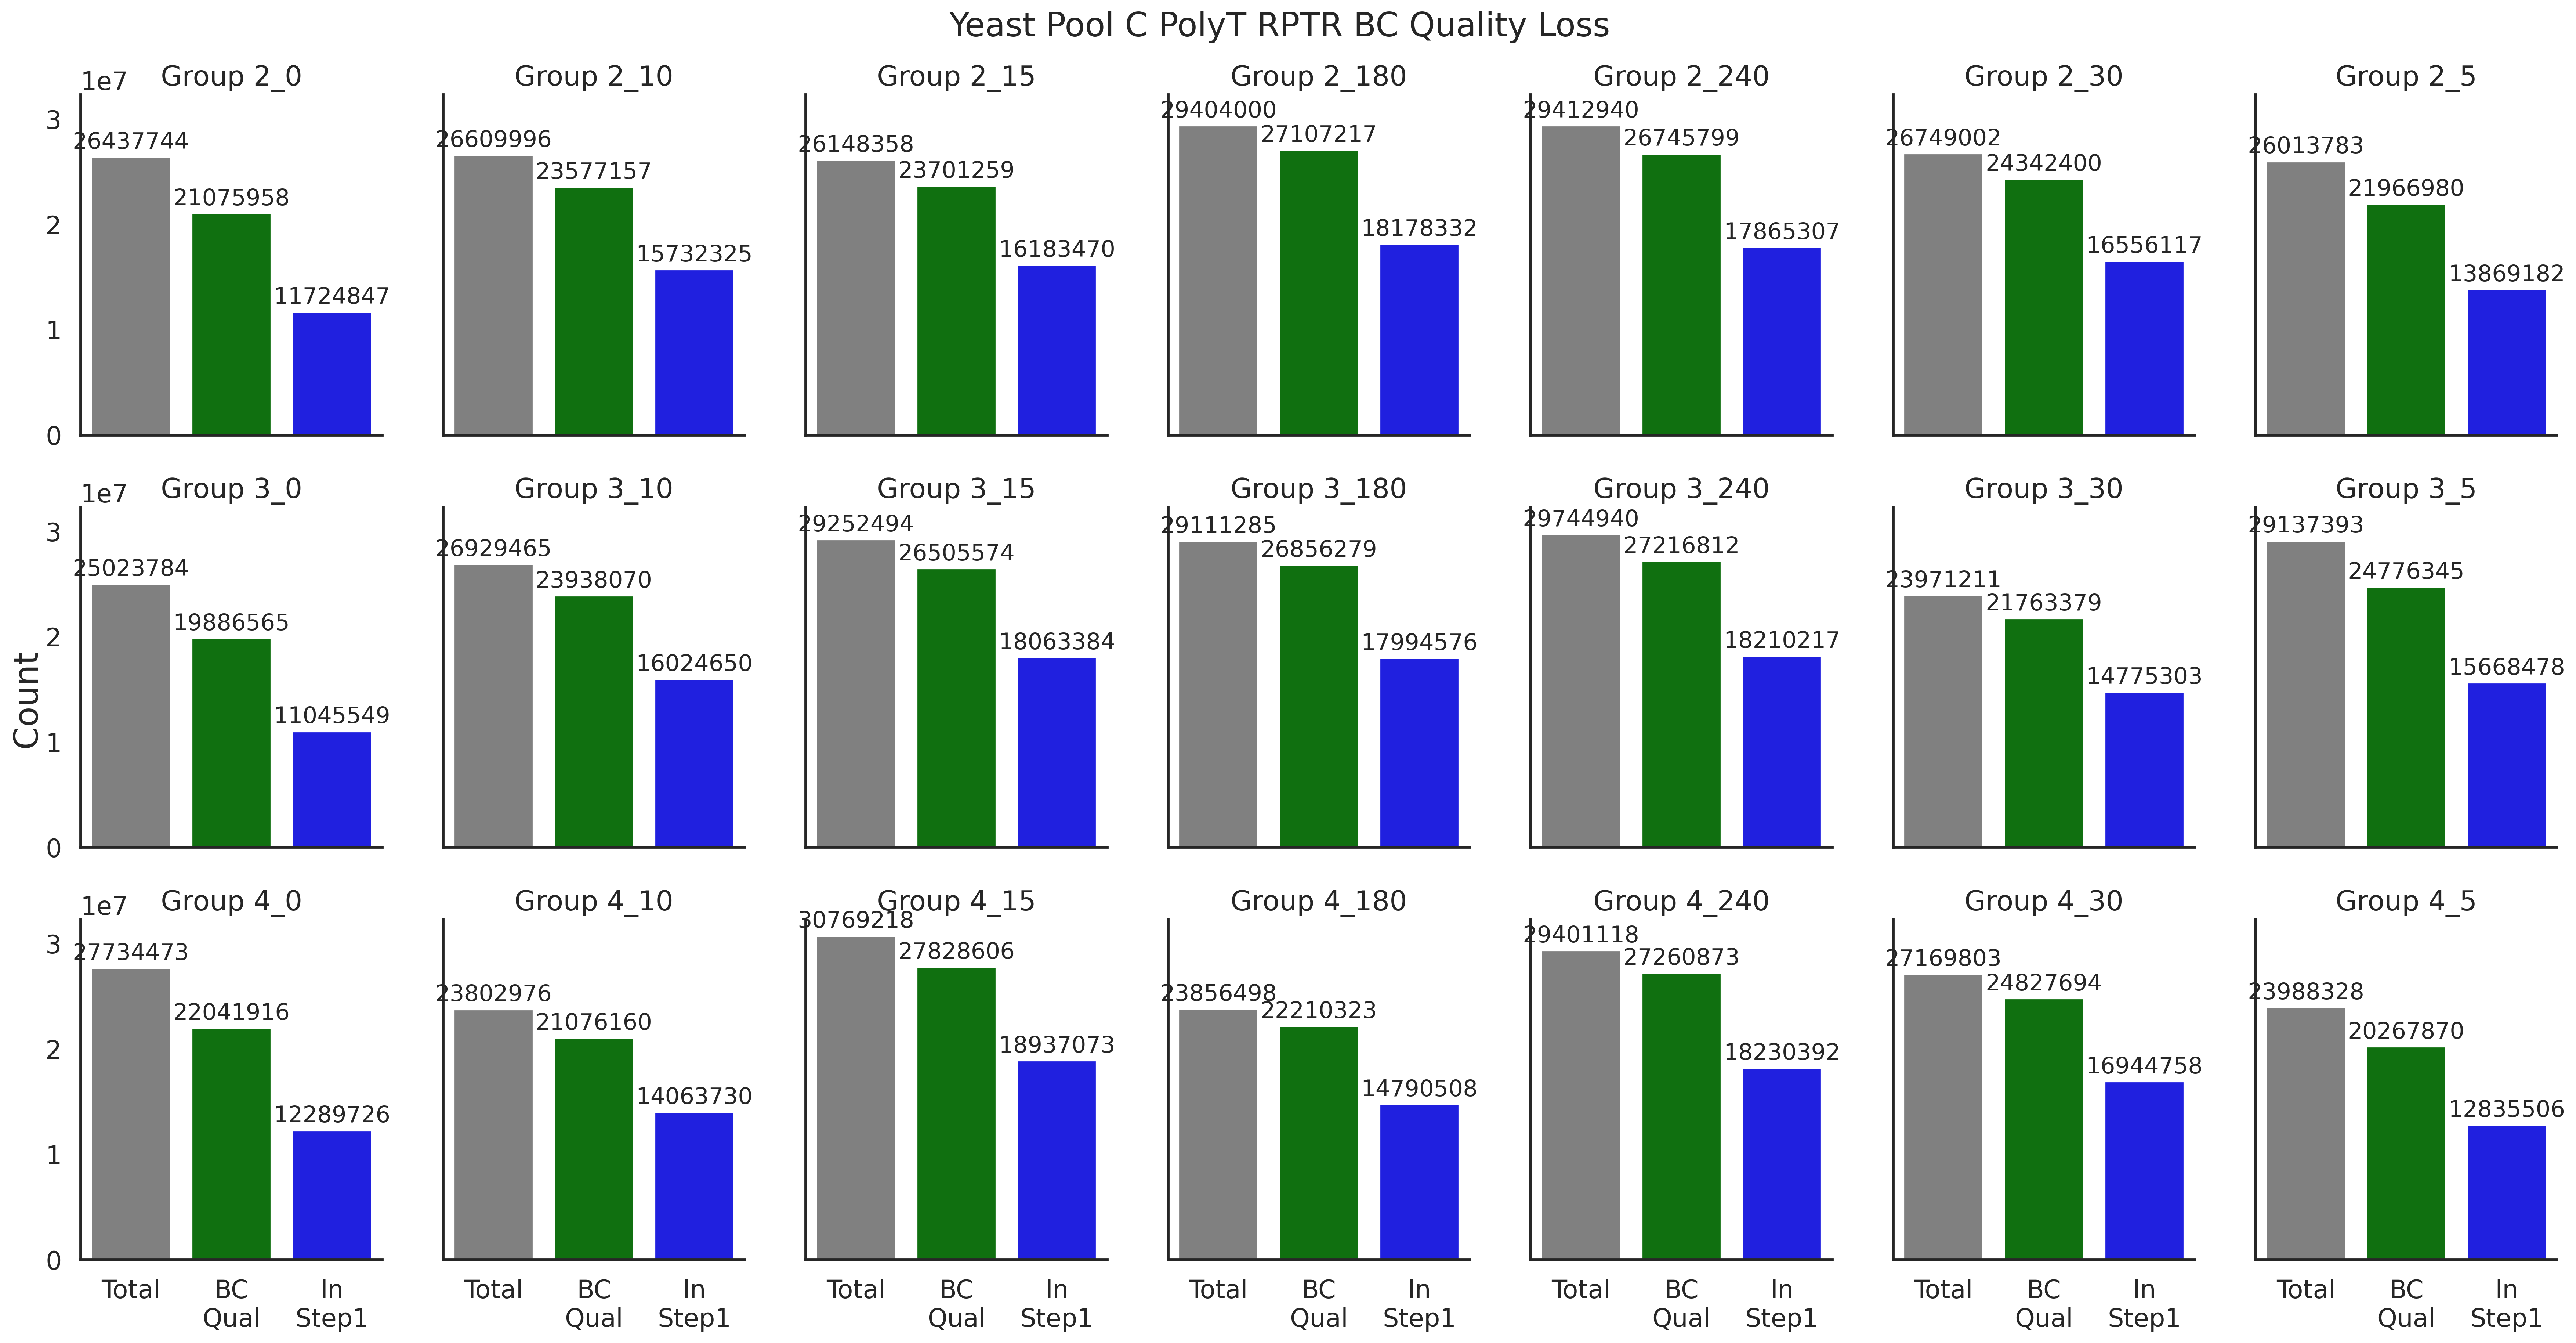

In [154]:
fig, axes = plt.subplots(3, 7, figsize=(24,12), dpi=300, sharey=True, sharex=True)
axes = axes.flatten()  # flatten to index easily 0..9 (2*5)

for i, prefix in enumerate(yeast_pool_C_polyT_RPTR_prefixes):
    file_name = prefix[:-12] + "_initial"  # construct your "maps" table/file name

    # Query total counts
    total_count = con.execute(f"SELECT COUNT(*) FROM {file_name}").fetchone()[0]

    # Query number of rows where both BC and AD are qualified
    true_count = con.execute(f"""
        SELECT COUNT(*) 
        FROM {file_name} 
        WHERE RPTR_BC_qual
    """).fetchone()[0]

    # Query number of rows in Step1 map
    step1_count = con.execute(f"""
        SELECT COUNT(*) 
        FROM {file_name} AS m
        JOIN step1_AD_AD_BC_RPTR_BC_designed AS s
        ON m.RPTR_BC = s.RPTR_BC
    """).fetchone()[0]

    print(f"{file_name} step1 count: {step1_count}")

    # Prepare DataFrame for plotting
    plot_counts = pd.DataFrame({
        "Category": ["Total", "BC\nQual", "In\nStep1"],
        "Count": [total_count, true_count, step1_count]
    })

    ax = axes[i]
    sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green", "blue"])
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)

    ax.set_title("Group " + str(re.search(r'(\d+_\d+)', file_name)[0]), fontsize='medium')
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.supylabel("Count")
sns.despine()
plt.tight_layout(pad = 1)
fig.suptitle("Yeast Pool C PolyT RPTR BC Quality Loss", y = 1.02)
plt.savefig(os.path.join(yeast_pool_C_PolyT_output_path + "/figures", f"RPTR_BC_quality_loss.png"))
plt.show()

### 2. UMI

#### 1. AD

##### Testing on one once

In [159]:
yeast_pool_C_umi_AD_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/data/sequencing/20250218_MZCCSCU_MedGenome/MZ/results/assembled/*")
yeast_pool_C_umi_output_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi" 

In [160]:
complex_AD_results = []
simple_AD_results = []

In [161]:
AD_UMI = finder.Barcode(name = "UMI",
                        preceder = "TGATTT",
                       post = "",
                       length = 12)

AD_UMI_objects = [EC_AD, EC_AD_BC, AD_UMI]

In [150]:
for file_path in [yeast_pool_C_umi_AD_seq_files[2]]:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Get the file naeme to use for output
    umi_path = os.path.join(yeast_pool_C_umi_output_path, f"trebl_experiment_yeast_pool_C_umi_{name_only}")
    print(umi_path)

    # Extract UMIs and barcodes from reads
    umi_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"trebl_experiment_yeast_pool_C_umi_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = "/global/scratch/projects/fc_mvslab/OpenProjects/EChase/TREBLEseq_ismaybethenewcibername/A10_sequencing/v2/current/a10_designfile.csv",
                                       bc_objects = AD_objects,
                                        umi_object=AD_UMI,
                                       reverse_complement = True,
                                        test_n_reads = 10000)
    umi_mapper.create_map()

    # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=AD_objects,
                                        column_pairs = [],
                                        map_order = ['quality', 'designed'],
                                        step_name=f"trebl_experiment_yeast_pool_C_umi_{name_only}", 
                                        descriptor = "",
                                        should_check_exists = False,
                                        design_check = True,
                                        output_figures_path='/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/figures',
                                        plot_histograms=True,
                                        reads_threshold = 0,
                                        umi_object = AD_UMI)
    refiner.refine_map_from_db()
    refiner.plot_loss()

    # Run both deduplications
    deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
                                                        bc_objects = AD_objects,
                                                        step_name = f"trebl_experiment_yeast_pool_C_umi_{name_only}", 
                                                        descriptor = "",
                                                        step1_map_name = None,
                                                        fastq_path = file_path,
                                                        output_path = umi_path, 
                                                       refined_map_suffix = 'designed')

    deduplicator.run_both_deduplications()

    # Collect results
    one_file_complex_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_directional_umi_counts.tsv"), sep = "\t")
    one_file_complex_results["name"] = name_only
    complex_AD_results.append(one_file_complex_results)

    one_file_simple_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_simple_umi_counts.tsv"), sep = "\t")
    one_file_simple_results["name"] = name_only
    simple_AD_results.append(one_file_simple_results)

AD_2_240
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_2_240
Reading 1 FASTQ/TXT file(s)...
Done in 0.08 seconds.

Reverse complement of sequences...
Done in 0.12 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.{1,120})
Regex for AD_BC: CGCGCC(.{1,11})
Done in 0.09 seconds.

Extracting UMI...
Regex for UMI: TGATTT(.{1,12})
Done in 0.02 seconds.

Merging with design file...
Done in 3.78 seconds.

Mapping complete.
trebl_experiment_yeast_pool_C_umi_AD_2_240_AD_AD_BC_initial
Total rows: 10031


AD  AD_qual        AD_BC  \
0  CAACAACAAGGTTCTAATATGGCTGGTACTGTTCCACATAGATTGC...     True  CCCCCACAACA   
1  TCTCCAACTGGTTCTACTAGACATTCTTCTGTTTCTGGTGTTAATT...     True  CTTGGGCGGTG   
2  AATGCTTCTGGTGAAGGTAAAGATTCTAATGCTGTTGGTATGGCTC...     True  AGGCCGAGATC   
3  GTTATGGCTGGTCCAGATTCTTTGGCTGATTTGCCATCTGGTACTA...     True  ATTTTCTTAAT   
4  CCAGAATCTACTGCTACTGATCAACCAACTGCTTCTGTTAAATCTC...     True  AGCAGATGACT   

   AD_BC_qual           UMI  UMI_qual  Designed  
0        True  GTTTGATGACTT      True         1  
1        True  TAGACGCAGANA      True         1  
2        True  GACCACCGCANA      True         1  
3        True  GCCATCTGGTAC      True         1  
4        True  GGAAATTACTGA      True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_C_umi_AD_2_240_AD_AD_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_C_umi_AD_2_240_AD_AD_BC_

Using the following step order:
1. initial
2. quality
3. designed


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_C_umi_AD_2_240_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.02 seconds.


Filtering to designed sequences...
Created table: trebl_experiment_yeast_pool_C_umi_AD_2_240_AD_AD_BC_designed — kept only Designed == 1.
Done in 0.01 seconds.

Done.
Starting simple deduplication.
Finished simple deduplication.

Starting UMI Tools directional deduplication.
Generating FASTQ with UMIs in header and barcodes as sequence...
Writing FASTQ to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_2_240/AD_2_240_umi_extracted.fastq (6252 reads)...


Writing FASTQ: 100%|██████████| 6252/6252 [00:00<00:00, 1316471.14it/s]

FASTQ complete: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_2_240/AD_2_240_umi_extracted.fastq
Done in 0.04 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: trebl_experiment_yeast_pool_C_umi_AD_2_240_AD_AD_BC_unique_barcodes
Writing FASTA to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_2_240/AD_2_240_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_2_240/AD_2_240_barcodes_index



Building a SMALL index
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_2_240/AD_2_240_barcodes_index.3.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_2_240/AD_2_240_barcodes_index.3.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_2_240/AD_2_240_barcodes_index.4.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_2_240/AD_2_240_barcodes_index.4.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_2_240/AD_2_240_barcodes_index.1.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_

Done in 1.94 seconds.

Aligning .FASTQ to reference .FA ...


6252 reads; of these:
  6252 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    6252 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_2_240/AD_2_240_umi_extracted.sorted.bam -S /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_2_240/AD_2_240_umi_deduplicated.bam
# job started at Thu Jan  8 12:07:27 2026 on n0036.savio2 -- 163cb64c-95f3-4aa7-932d-790bbb6cab41
# pid: 3747163, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method             

##### Submitting job

#### How much do complex vs simple differ?

In [162]:
complex_AD_results = []
simple_AD_results = []

In [163]:
for file_path in yeast_pool_C_umi_AD_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Get the file naeme to use for output
    umi_path = os.path.join(yeast_pool_C_umi_output_path, f"trebl_experiment_yeast_pool_C_umi_{name_only}")
    print(umi_path)

    # Collect results
    one_file_complex_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_directional_umi_counts.tsv"), sep = "\t")
    one_file_complex_results["name"] = name_only
    complex_AD_results.append(one_file_complex_results)

    one_file_simple_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_simple_umi_counts.tsv"), sep = "\t")
    one_file_simple_results["name"] = name_only
    simple_AD_results.append(one_file_simple_results)

AD_1_15
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_1_15
AD_1_240
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_1_240
AD_2_240
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_2_240
AD_2_180
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_2_180
AD_2_15
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_2_15
AD_2_5
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_2_5
AD_1_0
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_AD_1_0
AD_3_15
/gl

In [164]:
all_complex_AD_results = pd.concat(complex_AD_results)
all_complex_AD_results = all_complex_AD_results.rename(columns = {"gene" : "concat_AD_AD_BC", "count" : "complex_umi_count"})
all_complex_AD_results

concat_AD_AD_BC  complex_umi_count  \
0       GGTCAATGGTTGGCTTTGTTTCCACATCCATCTTCTATTGACTTTG...                532   
1       GAATCTCCAGAATATAATGATGGATTTGATGCTTCTCCATTTGTTG...                151   
2       TCTGCTGCATTTACTAATTTGACTTCTCCATCTATCTTTGATTCTC...                  1   
3       GCTTTGCAACAACAAAGACCAACTAGACCACAAGTTCCATTGTTCT...               2721   
4       GCTGCTAGAAGATCTAGAGCTAGGAAAGTTCAAAGAATGAATCAAT...                 67   
...                                                   ...                ...   
195139  GATGCTAATGTTGAATCTTCTACTGGTGTTGGTTCTACTGAAGTTG...                  1   
195140  CAAACTGCTAAGATGATGAATGCTGCTGATGTTGATTTGGATGACT...                  1   
195141  TCTGGTAAGAAGACTTCTGCTGCTGGTGCTGTTCAGAAACCAGCTG...                  1   
195142  ATCTTGTCTGCTAGAGTTCCATCTCCAGAATGGTTGGTTCAGAATA...                  1   
195143  CAACAATTCTATGCTTCTTCTGCTCCATCTTCTGCTTTGAATTTGA...                  1   

            name  
0        AD_1_15  
1        AD_1_15  
2        AD_1_15  
3        AD_1_15  
4        AD_1_15  
...          ...  
195139  AD_1_180  
195140  AD_1_180  
195141  AD_1_180  
195142  AD_1_180  
195143  AD_1_180  

[4239234 rows x 3 columns]

In [165]:
all_simple_AD_results = pd.concat(simple_AD_results)
all_simple_AD_results = all_simple_AD_results.rename(columns = {"count" : "simple_umi_count"})
all_simple_AD_results["concat_AD_AD_BC"] = all_simple_AD_results["AD"] + all_simple_AD_results["AD_BC"]
all_simple_AD_results = all_simple_AD_results.drop(columns = ["AD", "AD_BC"])
all_simple_AD_results

simple_umi_count      name  \
0                  11454   AD_1_15   
1                   7086   AD_1_15   
2                   7060   AD_1_15   
3                   5619   AD_1_15   
4                   5466   AD_1_15   
...                  ...       ...   
200382                 1  AD_1_180   
200383                 1  AD_1_180   
200384                 1  AD_1_180   
200385                 1  AD_1_180   
200386                 1  AD_1_180   

                                          concat_AD_AD_BC  
0       CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...  
1       TCTTCTTCATTTGGTTTGTCTGGTAATTCTTCTCAACATAGATTGT...  
2       TTTCCACCATCTTCTCCATCTATGACTACTGAAATGGTTTCTTTGC...  
3       CAAGGTGAACCAATGTTAAATTCTTCTAATGATTGGTTCTCTTTGT...  
4       AATACATTTCATTCTGCTTATTCTTCTCCAGCTGTTCCAACTTTGT...  
...                                                   ...  
200382  TCTGTTGATGATGCTTCTTCTCCACCAACTATTGATTCTCCATCTA...  
200383  ACTACTGAAAGAGTTCAAGCTGTTACTAATGGTTATATGGAATATA...  
200384  ATCTTGCCATCTAGAGGTTTGGTTTCTGCTTCTGCTCCAGTTAGAC...  
200385  TTGACTTCTCCAACTTCTTCTATGATGGCTTCTCCATTGCCAGATT...  
200386  TTGGGTAAAGATCATAGAGGTTATAATGCTCATAATTGGAAACAAT...  

[4350199 rows x 3 columns]

In [166]:
both_AD_umi_results = pd.merge(all_complex_AD_results, all_simple_AD_results, on = ["concat_AD_AD_BC", "name"])
both_AD_umi_results

concat_AD_AD_BC  complex_umi_count  \
0        GGTCAATGGTTGGCTTTGTTTCCACATCCATCTTCTATTGACTTTG...                532   
1        GAATCTCCAGAATATAATGATGGATTTGATGCTTCTCCATTTGTTG...                151   
2        TCTGCTGCATTTACTAATTTGACTTCTCCATCTATCTTTGATTCTC...                  1   
3        GCTTTGCAACAACAAAGACCAACTAGACCACAAGTTCCATTGTTCT...               2721   
4        GCTGCTAGAAGATCTAGAGCTAGGAAAGTTCAAAGAATGAATCAAT...                 67   
...                                                    ...                ...   
4239229  GATGCTAATGTTGAATCTTCTACTGGTGTTGGTTCTACTGAAGTTG...                  1   
4239230  CAAACTGCTAAGATGATGAATGCTGCTGATGTTGATTTGGATGACT...                  1   
4239231  TCTGGTAAGAAGACTTCTGCTGCTGGTGCTGTTCAGAAACCAGCTG...                  1   
4239232  ATCTTGTCTGCTAGAGTTCCATCTCCAGAATGGTTGGTTCAGAATA...                  1   
4239233  CAACAATTCTATGCTTCTTCTGCTCCATCTTCTGCTTTGAATTTGA...                  1   

             name  simple_umi_count  
0         AD_1_15               569  
1         AD_1_15               164  
2         AD_1_15                 1  
3         AD_1_15              2954  
4         AD_1_15                71  
...           ...               ...  
4239229  AD_1_180                 1  
4239230  AD_1_180                 1  
4239231  AD_1_180                 1  
4239232  AD_1_180                 1  
4239233  AD_1_180                 1  

[4239234 rows x 4 columns]

In [167]:
both_AD_umi_results["diff"] = both_AD_umi_results["simple_umi_count"] - both_AD_umi_results["complex_umi_count"]
both_AD_umi_results

concat_AD_AD_BC  complex_umi_count  \
0        GGTCAATGGTTGGCTTTGTTTCCACATCCATCTTCTATTGACTTTG...                532   
1        GAATCTCCAGAATATAATGATGGATTTGATGCTTCTCCATTTGTTG...                151   
2        TCTGCTGCATTTACTAATTTGACTTCTCCATCTATCTTTGATTCTC...                  1   
3        GCTTTGCAACAACAAAGACCAACTAGACCACAAGTTCCATTGTTCT...               2721   
4        GCTGCTAGAAGATCTAGAGCTAGGAAAGTTCAAAGAATGAATCAAT...                 67   
...                                                    ...                ...   
4239229  GATGCTAATGTTGAATCTTCTACTGGTGTTGGTTCTACTGAAGTTG...                  1   
4239230  CAAACTGCTAAGATGATGAATGCTGCTGATGTTGATTTGGATGACT...                  1   
4239231  TCTGGTAAGAAGACTTCTGCTGCTGGTGCTGTTCAGAAACCAGCTG...                  1   
4239232  ATCTTGTCTGCTAGAGTTCCATCTCCAGAATGGTTGGTTCAGAATA...                  1   
4239233  CAACAATTCTATGCTTCTTCTGCTCCATCTTCTGCTTTGAATTTGA...                  1   

             name  simple_umi_count  diff  
0         AD_1_15               569    37  
1         AD_1_15               164    13  
2         AD_1_15                 1     0  
3         AD_1_15              2954   233  
4         AD_1_15                71     4  
...           ...               ...   ...  
4239229  AD_1_180                 1     0  
4239230  AD_1_180                 1     0  
4239231  AD_1_180                 1     0  
4239232  AD_1_180                 1     0  
4239233  AD_1_180                 1     0  

[4239234 rows x 5 columns]

In [168]:
both_AD_umi_results["diff_percent"] = 100 * both_AD_umi_results["diff"] / both_AD_umi_results["simple_umi_count"]
both_AD_umi_results

concat_AD_AD_BC  complex_umi_count  \
0        GGTCAATGGTTGGCTTTGTTTCCACATCCATCTTCTATTGACTTTG...                532   
1        GAATCTCCAGAATATAATGATGGATTTGATGCTTCTCCATTTGTTG...                151   
2        TCTGCTGCATTTACTAATTTGACTTCTCCATCTATCTTTGATTCTC...                  1   
3        GCTTTGCAACAACAAAGACCAACTAGACCACAAGTTCCATTGTTCT...               2721   
4        GCTGCTAGAAGATCTAGAGCTAGGAAAGTTCAAAGAATGAATCAAT...                 67   
...                                                    ...                ...   
4239229  GATGCTAATGTTGAATCTTCTACTGGTGTTGGTTCTACTGAAGTTG...                  1   
4239230  CAAACTGCTAAGATGATGAATGCTGCTGATGTTGATTTGGATGACT...                  1   
4239231  TCTGGTAAGAAGACTTCTGCTGCTGGTGCTGTTCAGAAACCAGCTG...                  1   
4239232  ATCTTGTCTGCTAGAGTTCCATCTCCAGAATGGTTGGTTCAGAATA...                  1   
4239233  CAACAATTCTATGCTTCTTCTGCTCCATCTTCTGCTTTGAATTTGA...                  1   

             name  simple_umi_count  diff  diff_percent  
0         AD_1_15               569    37      6.502636  
1         AD_1_15               164    13      7.926829  
2         AD_1_15                 1     0      0.000000  
3         AD_1_15              2954   233      7.887610  
4         AD_1_15                71     4      5.633803  
...           ...               ...   ...           ...  
4239229  AD_1_180                 1     0      0.000000  
4239230  AD_1_180                 1     0      0.000000  
4239231  AD_1_180                 1     0      0.000000  
4239232  AD_1_180                 1     0      0.000000  
4239233  AD_1_180                 1     0      0.000000  

[4239234 rows x 6 columns]

In [169]:
both_AD_umi_results.sort_values(by = 'diff_percent')

concat_AD_AD_BC  complex_umi_count  \
1895677  CAACCAAGACCAAGAGACTTCTCTGCTCCAGTTCCATCTTCTACTG...                 18   
2155510  CAACCAAGACCAAGAGACTTCTCTGCTCCAGTTCCATCTTCTACTG...                 18   
3281063  AATGCATTTCAAGCTGGTGCTCCAATTGCTCCAGAAGCTCCACAAT...                 15   
3818557  CAACCAAGACCAAGAGACTTCTCTGCTCCAGTTCCATCTTCTACTG...                 14   
2334625  AATGCATTTCAAGCTGGTGCTCCAATTGCTCCAGAAGCTCCACAAT...                 13   
...                                                    ...                ...   
3260407  CCATATTTGTCTGCTCCATCTTCTACTGCTTTGACTGCTTTGACTT...                  1   
329367   CAACCAGCTCCAACTCATTGTCCAGCTCCAGCTCAAACTGTTACTA...                  1   
3718598  CAATTGCATCCAACTCATCATAGAAGAATGATGTCTACTCCAAATA...                  1   
2131576  CAATTGCATCCAACTCATCATAGAAGAATGATGTCTACTCCAAATA...                  1   
2590870  CAATTGCATCCAACTCATCATAGAAGAATGATGTCTACTCCAAATA...                  1   

             name  simple_umi_count  diff  diff_percent  
1895677    AD_3_0                 1   -17  -1700.000000  
2155510   AD_1_10                 1   -17  -1700.000000  
3281063    AD_2_0                 1   -14  -1400.000000  
3818557    AD_1_5                 1   -13  -1300.000000  
2334625   AD_1_30                 1   -12  -1200.000000  
...           ...               ...   ...           ...  
3260407    AD_2_0                23    22     95.652174  
329367   AD_1_240                25    24     96.000000  
3718598    AD_1_5                26    25     96.153846  
2131576   AD_1_10                26    25     96.153846  
2590870   AD_3_30                31    30     96.774194  

[4239234 rows x 6 columns]

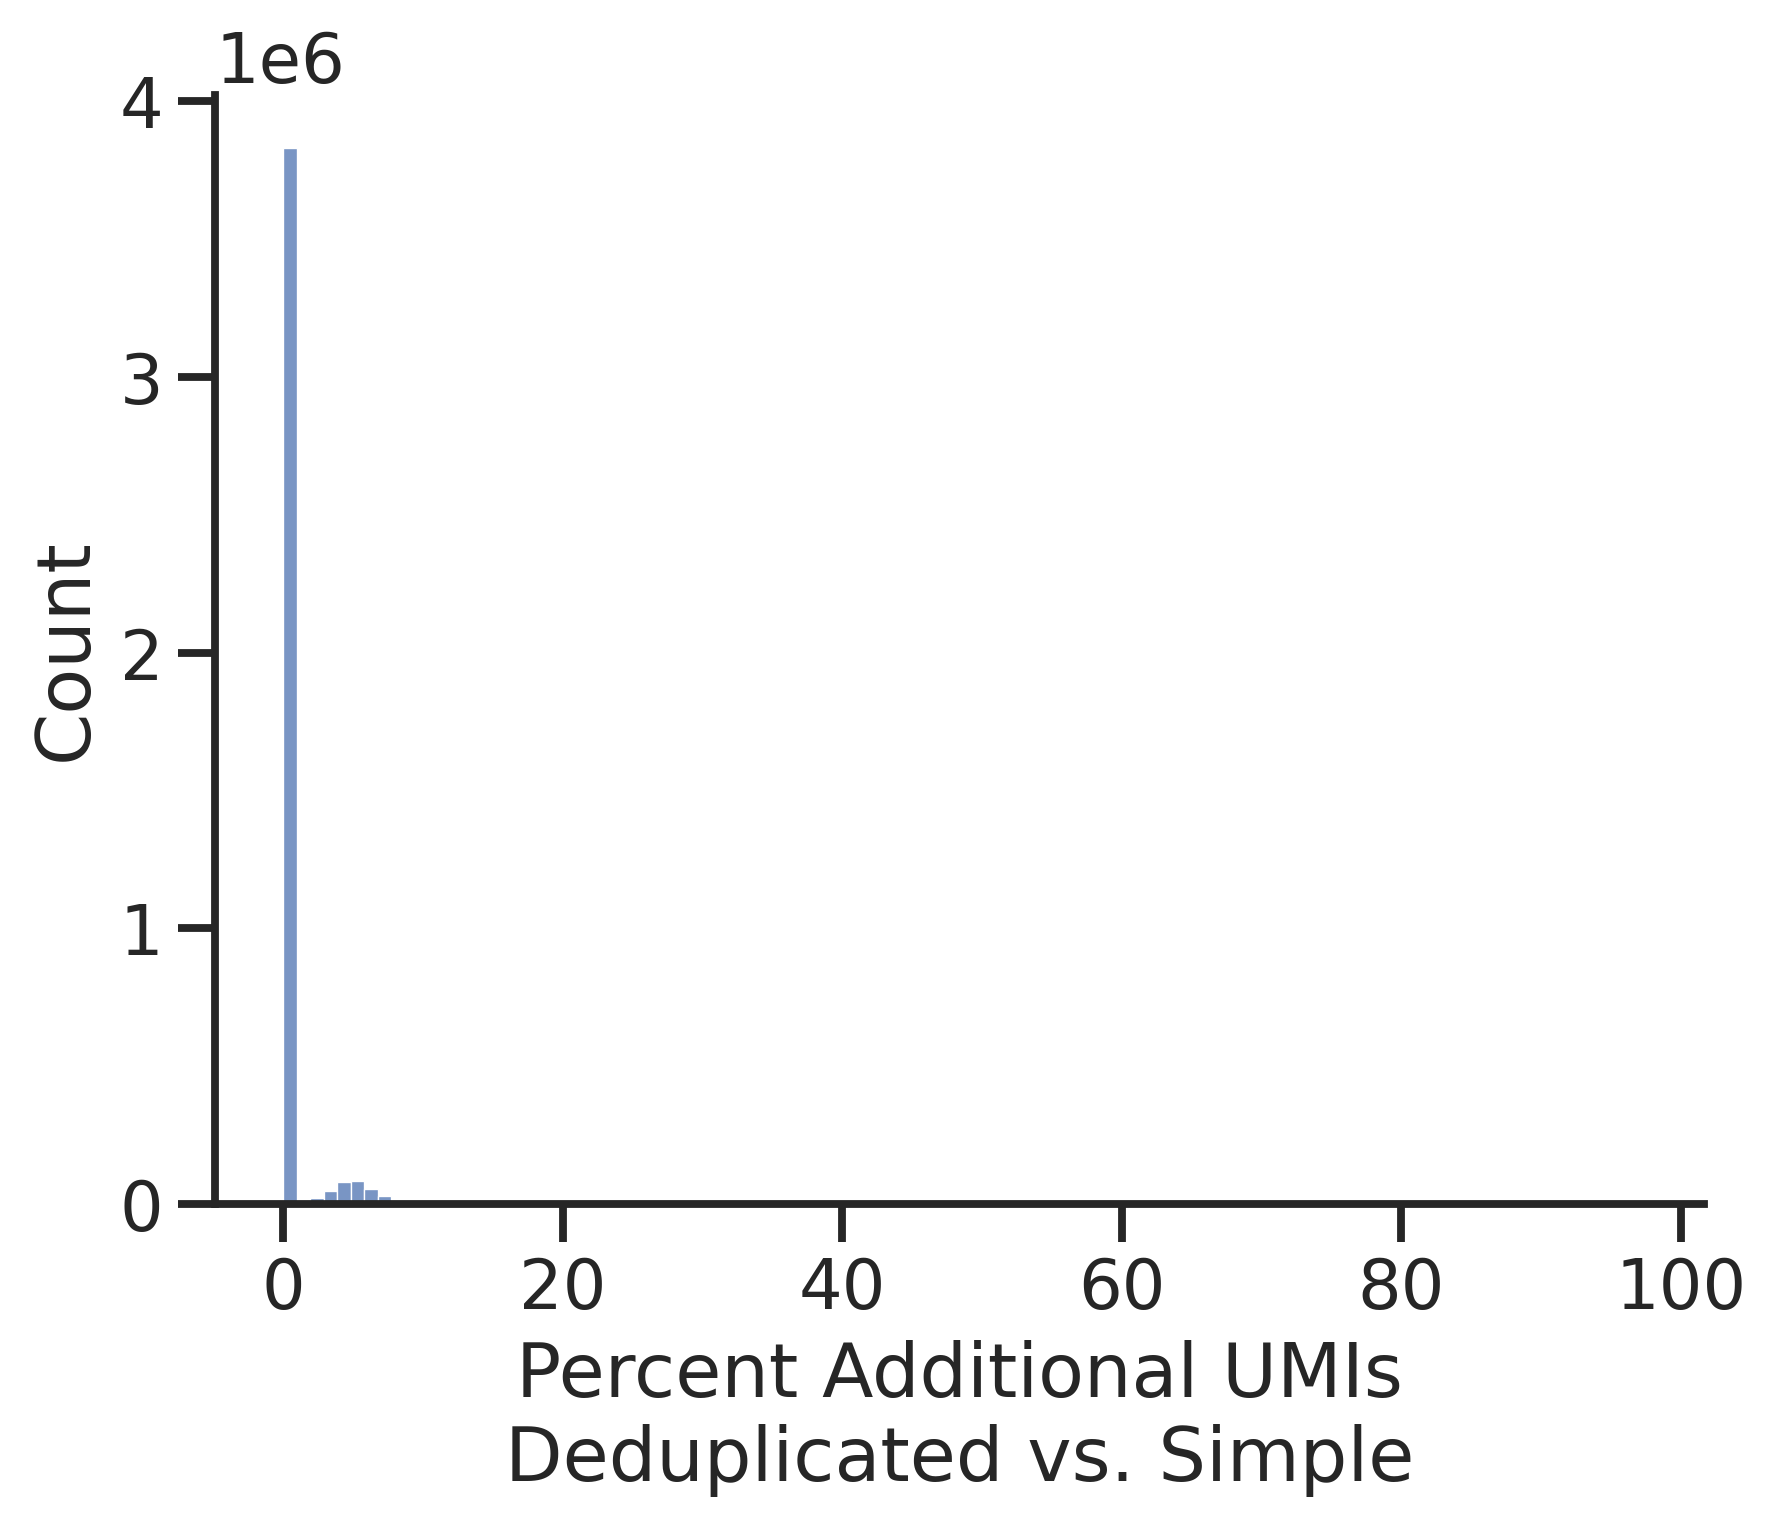

In [181]:
plt.figure(dpi = 300)
sns.set_style('ticks')
sns.histplot(both_AD_umi_results[both_AD_umi_results["diff_percent"] >= 0]["diff_percent"], bins = 100)
plt.xlabel("Percent Additional UMIs\nDeduplicated vs. Simple")
sns.despine()

In [37]:
both_AD_umi_results.sort_values(by = 'diff', ascending = False)

concat_AD_AD_BC  complex_umi_count  \
290012   CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...              21840   
3423431  CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...              16873   
4044103  CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...              18749   
702975   CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...              16547   
2221141  CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...              17292   
...                                                    ...                ...   
3818557  CAACCAAGACCAAGAGACTTCTCTGCTCCAGTTCCATCTTCTACTG...                 14   
3281063  AATGCATTTCAAGCTGGTGCTCCAATTGCTCCAGAAGCTCCACAAT...                 15   
3207771  CAACCAAGACCAAGAGACTTCTCTGCTCCAGTTCCATCTTCTACTG...                 18   
1895677  CAACCAAGACCAAGAGACTTCTCTGCTCCAGTTCCATCTTCTACTG...                 18   
2155510  CAACCAAGACCAAGAGACTTCTCTGCTCCAGTTCCATCTTCTACTG...                 18   

             name  simple_umi_count  diff  
290012   AD_1_240             23741  1901  
3423431  AD_3_240             18485  1612  
4044103  AD_1_180             20309  1560  
702975   AD_2_180             18040  1493  
2221141   AD_1_30             18784  1492  
...           ...               ...   ...  
3818557    AD_1_5                 1   -13  
3281063    AD_2_0                 1   -14  
3207771    AD_2_0                 3   -15  
1895677    AD_3_0                 1   -17  
2155510   AD_1_10                 1   -17  

[4239234 rows x 5 columns]

<Axes: xlabel='simple_umi_count', ylabel='diff'>

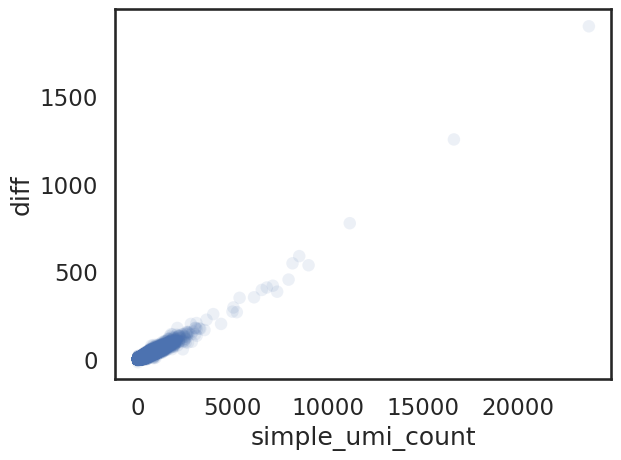

In [34]:
sns.scatterplot(data = both_AD_umi_results.sample(100000), 
                x = "simple_umi_count", 
                y = "diff", edgecolor = 'none', alpha = 0.1)


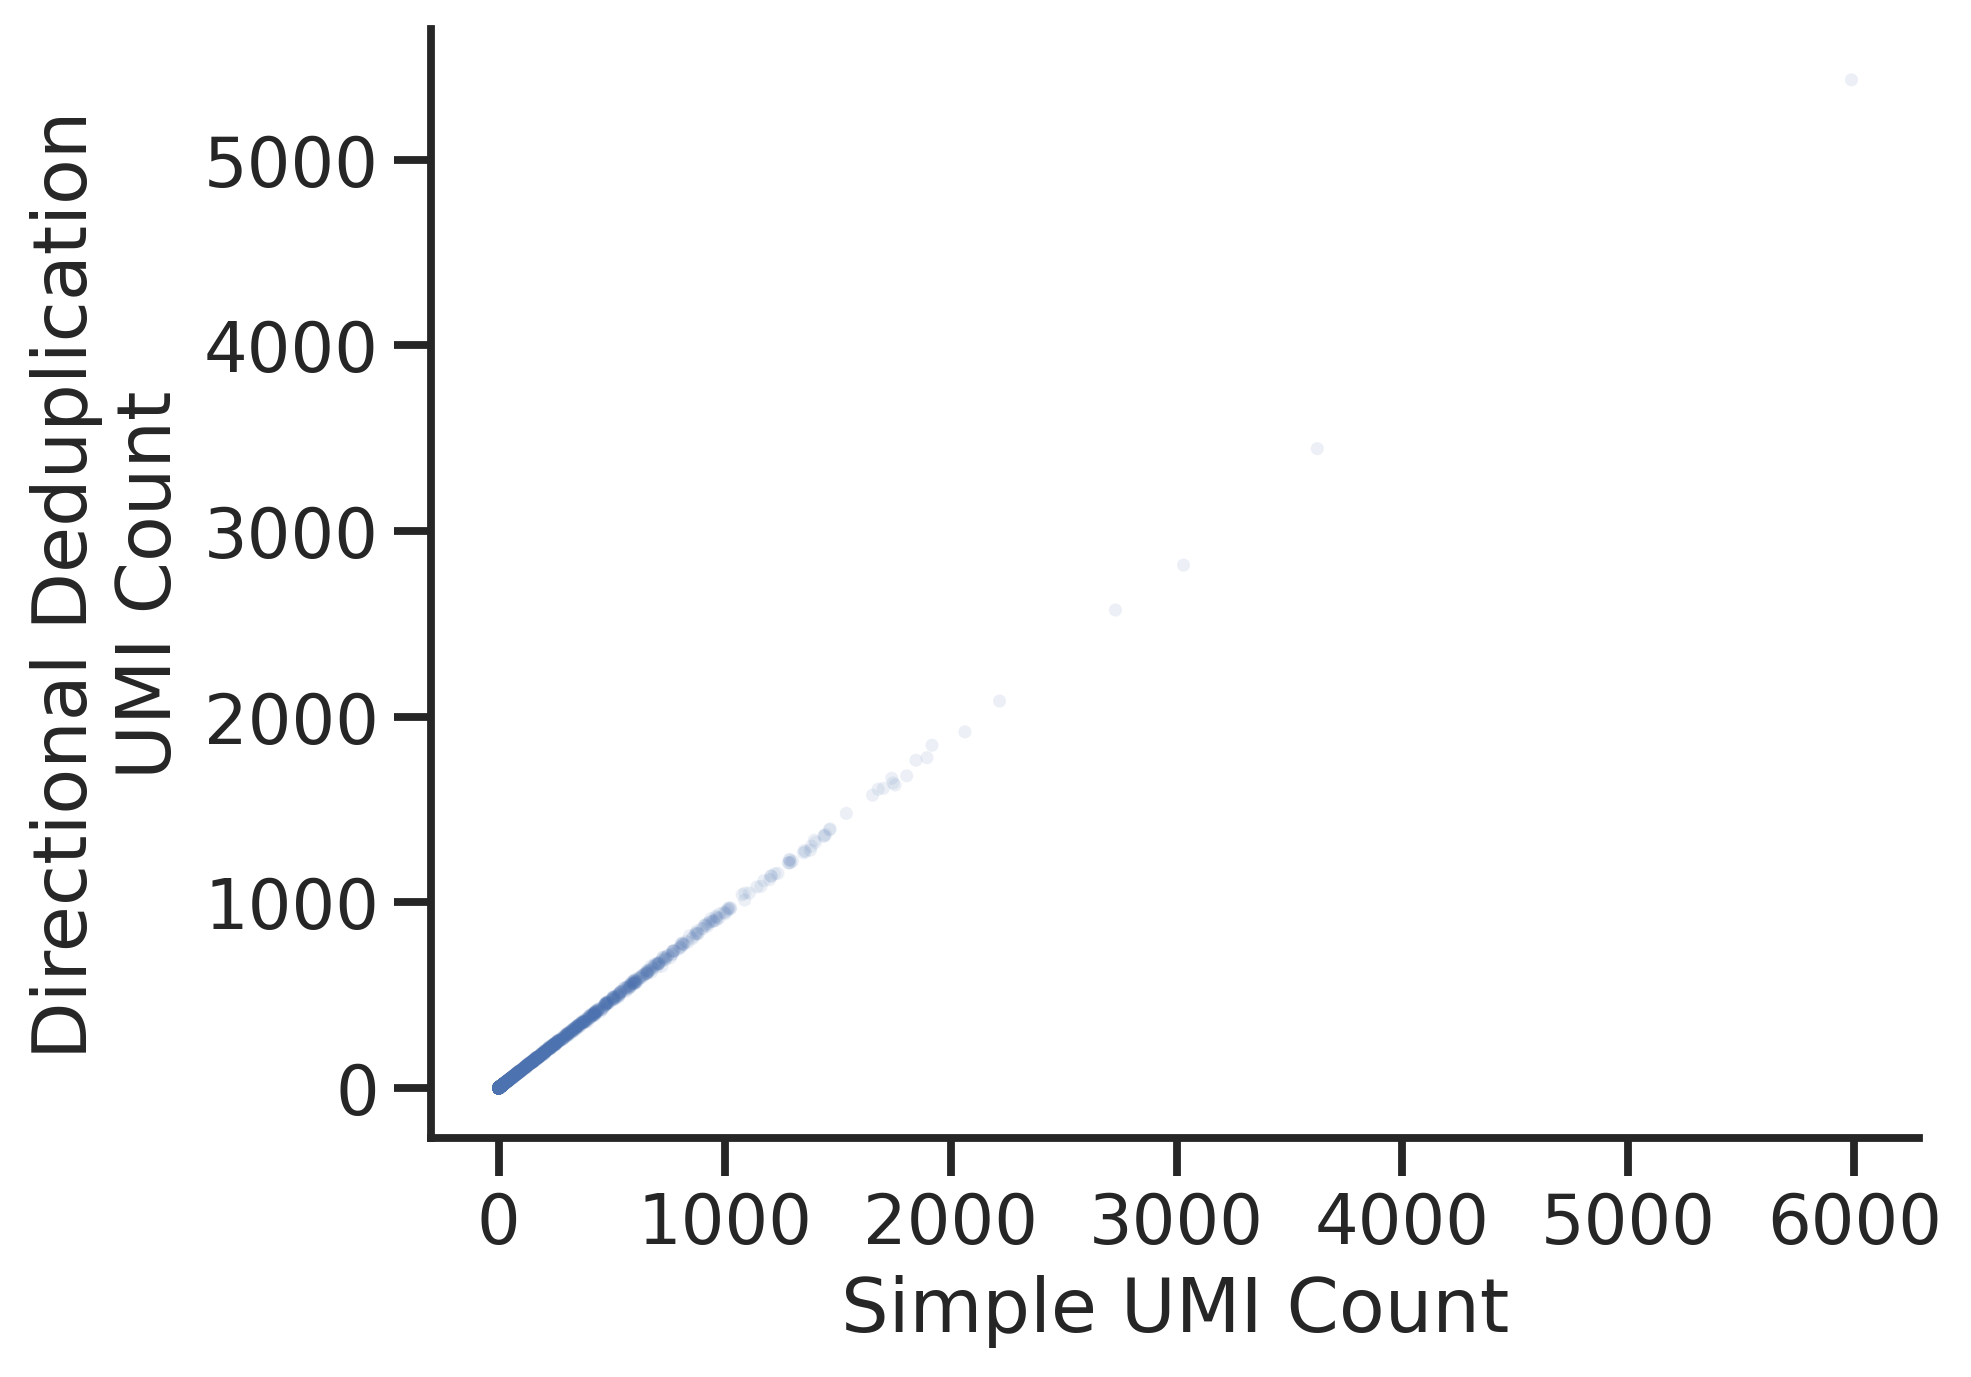

In [184]:
plt.figure(dpi = 300)
ax = sns.scatterplot(data = both_AD_umi_results.sample(10000), 
                x = "simple_umi_count", 
                y = "complex_umi_count",
               edgecolor = 'none',
               alpha = 0.1, s= 10)
# Add y = x line
# max_val = max(both_AD_umi_results["simple_umi_count"].max(),
#               both_AD_umi_results["complex_umi_count"].max())
# plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')

plt.xlabel("Simple UMI Count")
plt.ylabel("Directional Deduplication\nUMI Count") 
sns.despine()

#### 2. RTBC

##### First, running fastp to filter reads since single end for RPTR

In [12]:
# umi_deduplicate.run_fastp(input_dir="/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2025/20250226_TREBL_MAZ06/MZ_EC_TREBL/", 
#                           output_dir="/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4_pool_C_UMI_RPTR_fastp/", 
#                           script_path="/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/savio_jobs/fastp.sh")

Submitted batch job 30835547
Submitted SLURM array job for 21 files using /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/savio_jobs/fastp.sh.


In [36]:
# What files am i missing?
input_paths = glob.glob("/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2025/20250226_TREBL_MAZ06/MZ_EC_TREBL/*")
input_paths = [_.split("/")[-1].split(".")[0] for _ in input_paths]
input_paths = set(input_paths)
input_paths

{'RPTR_1_0_S1_R1_001',
 'RPTR_1_10_S3_R1_001',
 'RPTR_1_15_S4_R1_001',
 'RPTR_1_180_S6_R1_001',
 'RPTR_1_240_S7_R1_001',
 'RPTR_1_30_S5_R1_001',
 'RPTR_1_5_S2_R1_001',
 'RPTR_2_0_S8_R1_001',
 'RPTR_2_10_S10_R1_001',
 'RPTR_2_15_S11_R1_001',
 'RPTR_2_180_S13_R1_001',
 'RPTR_2_240_S14_R1_001',
 'RPTR_2_30_S12_R1_001',
 'RPTR_2_5_S9_R1_001',
 'RPTR_3_0_S15_R1_001',
 'RPTR_3_10_S17_R1_001',
 'RPTR_3_15_S18_R1_001',
 'RPTR_3_180_S20_R1_001',
 'RPTR_3_240_S21_R1_001',
 'RPTR_3_30_S19_R1_001',
 'RPTR_3_5_S16_R1_001'}

In [37]:
output_paths = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4_pool_C_UMI_RPTR_fastp/*")
output_paths = [_.split("/")[-1].split(".")[0][:-6] for _ in output_paths]
output_paths = set(output_paths)
output_paths

{'',
 'RPTR_1_0_S1_R1_001',
 'RPTR_1_10_S3_R1_001',
 'RPTR_1_15_S4_R1_001',
 'RPTR_1_180_S6_R1_001',
 'RPTR_1_240_S7_R1_001',
 'RPTR_1_30_S5_R1_001',
 'RPTR_1_5_S2_R1_001',
 'RPTR_2_0_S8_R1_001',
 'RPTR_2_10_S10_R1_001',
 'RPTR_2_15_S11_R1_001',
 'RPTR_2_180_S13_R1_001',
 'RPTR_2_240_S14_R1_001',
 'RPTR_2_30_S12_R1_001',
 'RPTR_2_5_S9_R1_001',
 'RPTR_3_0_S15_R1_001',
 'RPTR_3_10_S17_R1_001',
 'RPTR_3_180_S20_R1_001',
 'RPTR_3_240_S21_R1_001',
 'RPTR_3_30_S19_R1_001',
 'RPTR_3_5_S16_R1_001'}

In [38]:
input_paths - output_paths

{'RPTR_3_15_S18_R1_001'}

Needed to run these separately, didnt run for some reason:

fastp -i /global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2025/20250226_TREBL_MAZ06/MZ_EC_TREBL/RPTR_1_0_S1_R1_001.fastq.gz -o /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4_pool_C_UMI_RPTR_fastp/RPTR_1_0_S1_R1_001_fastp.fastq.gz -w 32 --disable_adapter_trimming --json /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4_pool_C_UMI_RPTR_fastp/logs/RPTR_1_0_S1_R1_001_fastp_report.json --html /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4_pool_C_UMI_RPTR_fastp/logs/RPTR_1_0_S1_R1_001_fastp_report.html &> /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4_pool_C_UMI_RPTR_fastp/logs/RPTR_1_0_S1_R1_001_fastp_report.out

fastp -i /global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2025/20250226_TREBL_MAZ06/MZ_EC_TREBL/RPTR_1_240_S7_R1_001.fastq.gz -o /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4_pool_C_UMI_RPTR_fastp/RPTR_1_240_S7_R1_001_fastp.fastq.gz -w 32 --disable_adapter_trimming --json /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4_pool_C_UMI_RPTR_fastp/logs/RPTR_1_240_S7_R1_001_fastp_report.json --html /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4_pool_C_UMI_RPTR_fastp/logs/RPTR_1_240_S7_R1_001_fastp_report.html &> /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4_pool_C_UMI_RPTR_fastp/logs/RPTR_1_240_S7_R1_001_fastp_report.out

fastp -i /global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2025/20250226_TREBL_MAZ06/MZ_EC_TREBL/RPTR_3_15_S18_R1_001.fastq.gz -o /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4_pool_C_UMI_RPTR_fastp/RPTR_3_15_S18_R1_001_fastp.fastq.gz -w 32 --disable_adapter_trimming --json /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4_pool_C_UMI_RPTR_fastp/logs/RPTR_3_15_S18_R1_001_fastp_report.json --html /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4_pool_C_UMI_RPTR_fastp/logs/RPTR_3_15_S18_R1_001_fastp_report.html &> /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4_pool_C_UMI_RPTR_fastp/logs/RPTR_3_15_S18_R1_001_fastp_report.out

In [5]:
df = umi_deduplicate.fastp_summary_df("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4_pool_C_UMI_RPTR_fastp/")
df

100%|██████████| 21/21 [00:00<00:00, 182.09it/s]


sample  reads_passed  reads_filtered  total_reads  \
0    RPTR_1_180_S6_R1_001     572160122          541994    572702116   
1   RPTR_2_180_S13_R1_001     569453352          459844    569913196   
2   RPTR_3_240_S21_R1_001     567081737          595001    567676738   
3    RPTR_2_15_S11_R1_001     561633039          393934    562026973   
4   RPTR_2_240_S14_R1_001     542966314          778708    543745022   
5    RPTR_2_30_S12_R1_001     540497756          320694    540818450   
6     RPTR_1_30_S5_R1_001     529157819         1706682    530864501   
7    RPTR_1_240_S7_R1_001     526517092         1010043    527527135   
8    RPTR_3_15_S18_R1_001     500017524          570140    500587664   
9    RPTR_3_10_S17_R1_001     499135901          353583    499489484   
10    RPTR_1_15_S4_R1_001     478804434          405473    479209907   
11    RPTR_1_10_S3_R1_001     463156980          613417    463770397   
12  RPTR_3_180_S20_R1_001     455215087          373701    455588788   
13   RPTR_2_10_S10_R1_001     439421446          319097    439740543   
14   RPTR_3_30_S19_R1_001     424271797          412738    424684535   
15    RPTR_3_5_S16_R1_001     295084038          242987    295327025   
16     RPTR_1_5_S2_R1_001     294858099          252219    295110318   
17     RPTR_2_5_S9_R1_001     280296939          630939    280927878   
18     RPTR_2_0_S8_R1_001     277422935          248982    277671917   
19     RPTR_1_0_S1_R1_001     223246309          284380    223530689   
20    RPTR_3_0_S15_R1_001     196428177          265262    196693439   

    filtered_percent  
0           0.094638  
1           0.080687  
2           0.104813  
3           0.070092  
4           0.143212  
5           0.059298  
6           0.321491  
7           0.191467  
8           0.113894  
9           0.070789  
10          0.084613  
11          0.132267  
12          0.082026  
13          0.072565  
14          0.097187  
15          0.082277  
16          0.085466  
17          0.224591  
18          0.089668  
19          0.127222  
20          0.134861

In [6]:
df["sample_shortened"] = df["sample"].str[5:].str[:-7]
df["sample_num"] = df["sample_shortened"].str.split("_").str[-1].str[1:].astype(int)
df = df.sort_values(by = 'sample_num', ascending = False)

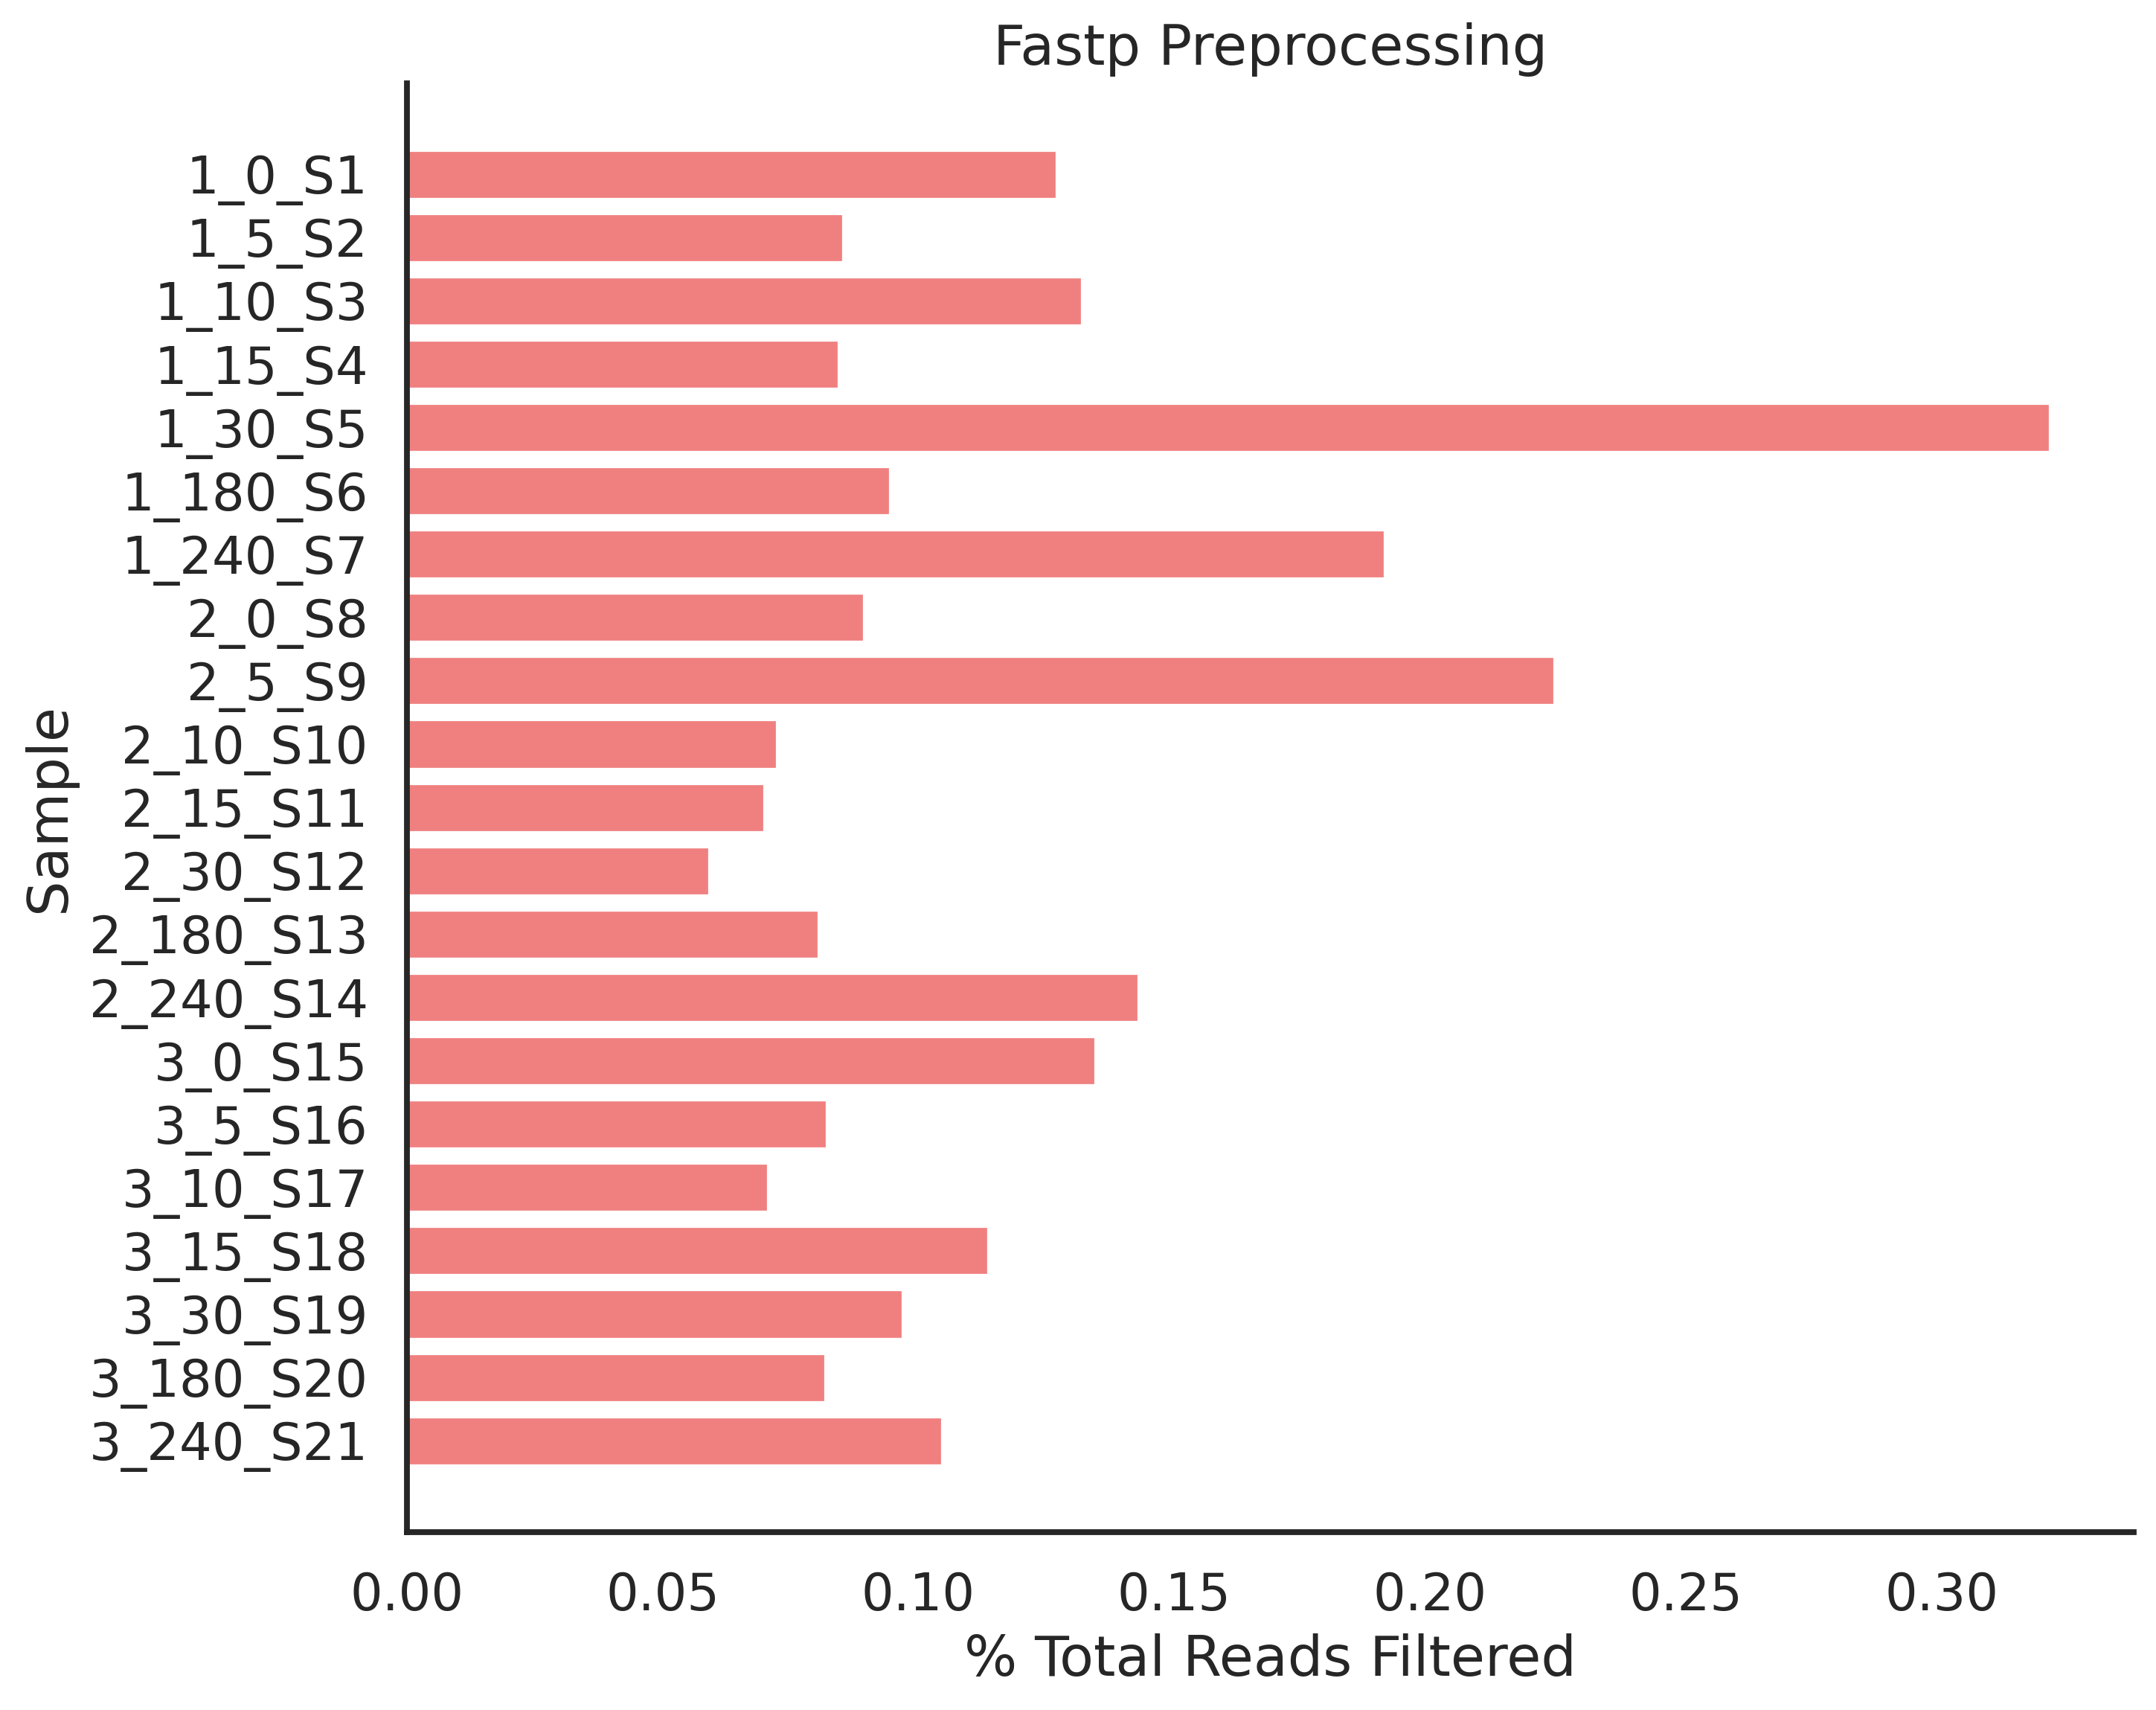

In [7]:
# Fastp preprocessing removes at most around 0.3% of reads
sns.set_context('talk')

plt.figure(figsize=(10,8), dpi=300)
plt.barh(df["sample_shortened"], df["filtered_percent"], color="lightcoral") 
plt.xlabel("% Total Reads Filtered") 
plt.ylabel("Sample") 
plt.title("Fastp Preprocessing")
plt.tight_layout()
sns.despine()
plt.show()

##### Now, UMI analysis

In [12]:
yeast_pool_C_umi_RT_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/GCN4_pool_C_UMI_RPTR_fastp/*")

In [9]:
complex_RT_results = []
simple_RT_results = []

In [10]:
RT_UMI = finder.Barcode(name = "UMI",
                        preceder = "TGTCAC",
                       post = "",
                       length = 12)

RPTR_3_30_S19_R1_001_fastp
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp
Reading 1 FASTQ/TXT file(s)...
Done in 0.18 seconds.

Reverse complement of sequences...
Done in 0.01 seconds.

Extracting 1 barcodes...
Regex for RPTR_BC: CTCGAG(.{1,14})
Done in 0.01 seconds.

Extracting UMI...
Regex for UMI: TGTCAC(.{1,12})
Done in 0.01 seconds.

Done in 0.01 seconds.

Mapping complete.
trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp_RPTR_BC_initial
Total rows: 100


RPTR_BC  RPTR_BC_qual           UMI  UMI_qual  Designed
0  TATTGTCAATTAGT          True   TGCTATACANC     False         1
1  TTCAGCGAATCAAT          True  TATTATTGGGAT      True         1
2  TAGTCGCGCGATAA          True  CGCCAGTATATA      True         1
3  CCCCTGGCCTCGCC          True  AGCAATGGCTAC      True         1
4  CTATTTCGGTCGAC          True  AATGCGAACATC      True         1

Base prefix (stable across descriptors): trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp_RPTR_BC_
Full prefix for this instance: trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp_RPTR_BC_

Using the following step order:
1. initial
2. quality


Filtering to high-quality reads...
Created table: trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.00 seconds.

Done.
Saved loss summary table as 'trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp_RPTR_BC_loss_summary'
Done in 0.02 seconds.

Starting simple deduplication.
Finished simple deduplication.

Starting UMI Tools directional deduplication.
Generating FASTQ with UMIs in header and barcodes as sequence...
Writing FASTQ to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp/RPTR_3_30_S19_R1_001_fastp_umi_extracted.fastq (96 rea

Writing FASTQ: 100%|██████████| 96/96 [00:00<00:00, 689474.63it/s]

FASTQ complete: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp/RPTR_3_30_S19_R1_001_fastp_umi_extracted.fastq
Done in 0.01 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp_RPTR_BC_unique_barcodes
Writing FASTA to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp/RPTR_3_30_S19_R1_001_fastp_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp/RPTR_3_30_S19_R1_001_fastp_barcodes_index



Building a SMALL index
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp/RPTR_3_30_S19_R1_001_fastp_barcodes_index.3.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp/RPTR_3_30_S19_R1_001_fastp_barcodes_index.3.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp/RPTR_3_30_S19_R1_001_fastp_barcodes_index.4.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp/RPTR_3_30_S19_R1_001_fastp_barcodes_index.4.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_RPTR_3_30_

Done in 2.42 seconds.

Aligning .FASTQ to reference .FA ...


96 reads; of these:
  96 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    96 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...
Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp/RPTR_3_30_S19_R1_001_fastp_umi_extracted.sorted.bam -S /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/trebl_experiment_yeast_pool_C_umi_RPTR_3_30_S19_R1_001_fastp/RPTR_3_30_S19_R1_001_fastp_umi_deduplicated.bam
# job started at Sat Jan 10 08:57:13 2026 on n0290.savio2 -- c34a5314-34dd-4c08-9ab0-b3e43bc9318e
# pid: 2630122, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom     

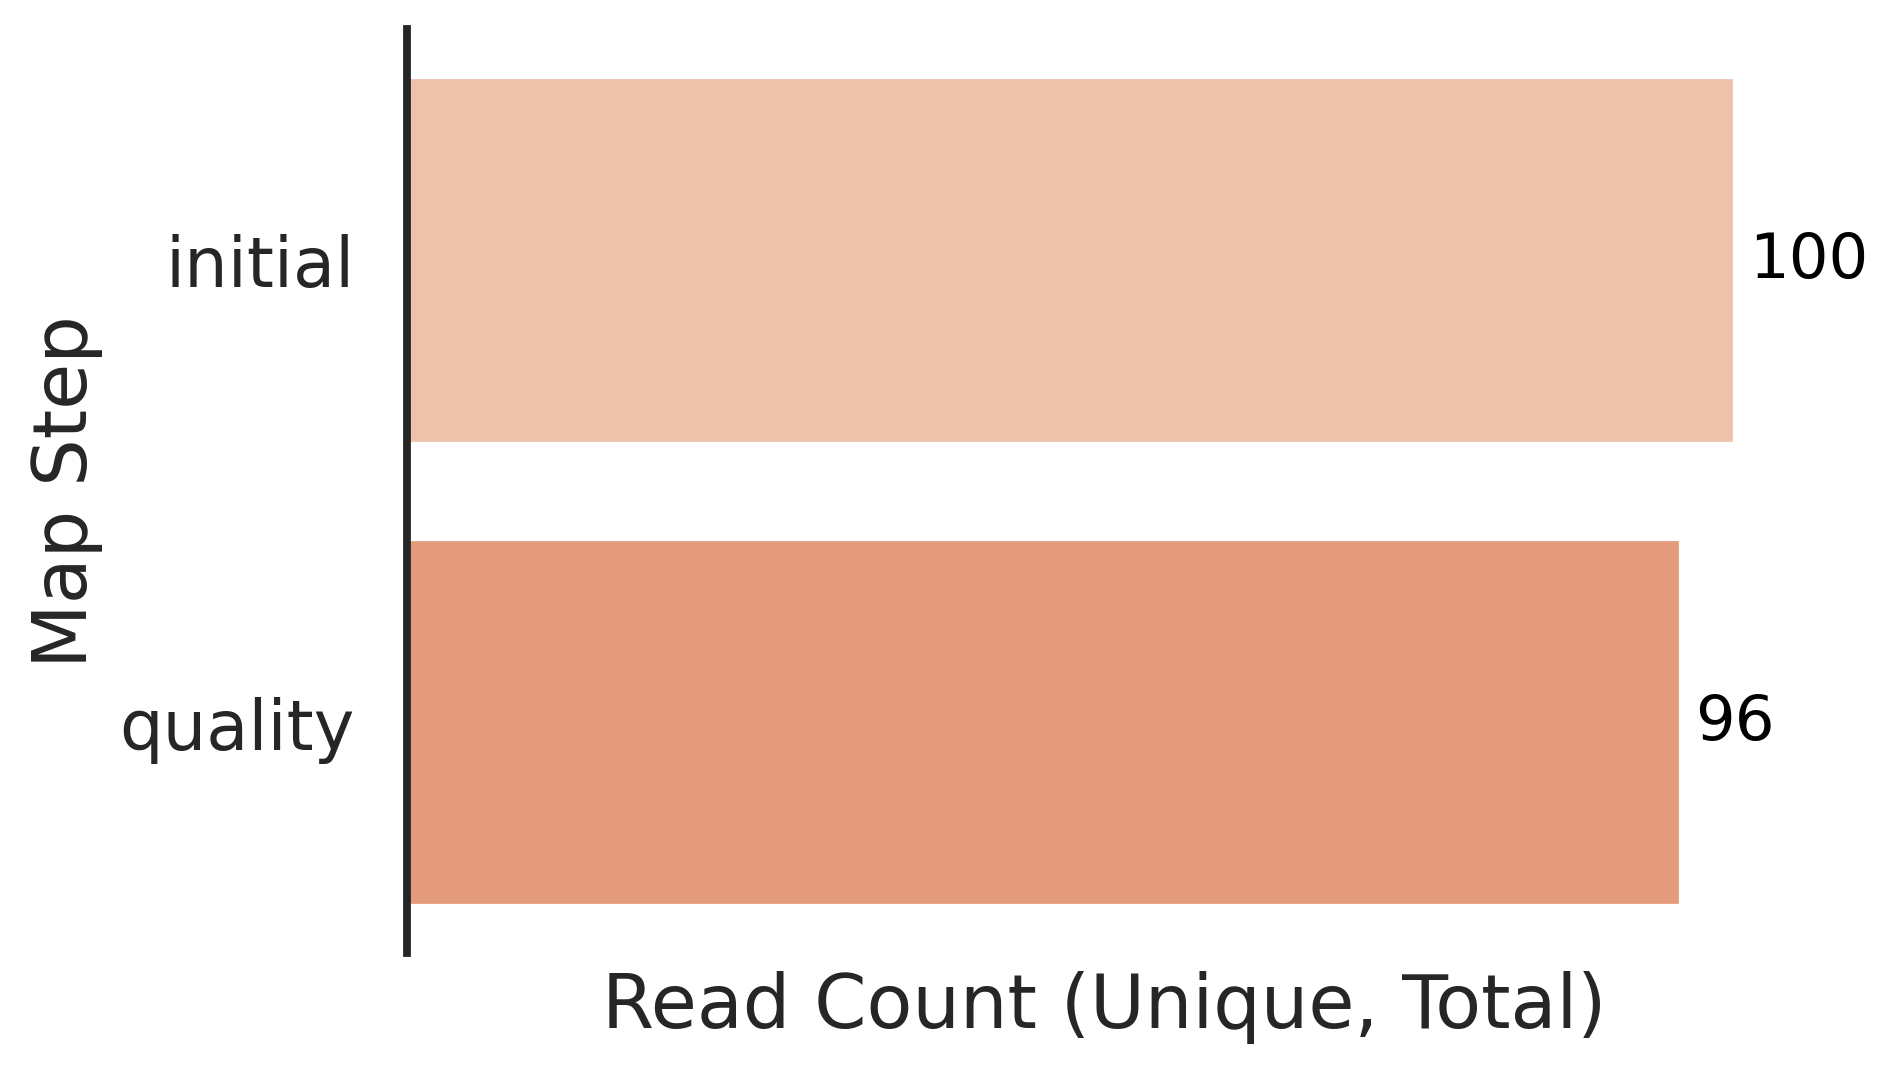

In [23]:
for file_path in [yeast_pool_C_umi_RT_seq_files[2]]:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Get the file naeme to use for output
    umi_path = os.path.join(yeast_pool_C_umi_output_path, f"trebl_experiment_yeast_pool_C_umi_{name_only}")
    print(umi_path)

    # Extract UMIs and barcodes from reRTs
    umi_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"trebl_experiment_yeast_pool_C_umi_{name_only}", 
                                       seq_file = file_path,
                                       bc_objects = [EC_RPTR_BC],
                                        umi_object=RT_UMI,
                                       reverse_complement = True,
                                        test_n_reads = 100)
    umi_mapper.create_map()
    display(umi_mapper.preview_map())

    # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=[EC_RPTR_BC],
                                        column_pairs = [],
                                        map_order = ['quality'],
                                        step_name=f"trebl_experiment_yeast_pool_C_umi_{name_only}", 
                                        descriptor = "",
                                        should_check_exists = False,
                                        design_check = False,
                                        output_figures_path='/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/GCN4/yeast_pool_C_umi/figures',
                                        plot_histograms=True,
                                        reads_threshold = 0,
                                        umi_object = RT_UMI)
    refiner.refine_map_from_db()
    refiner.plot_loss()

    # Run both deduplications
    deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
                                                        bc_objects = [EC_RPTR_BC],
                                                        step_name = f"trebl_experiment_yeast_pool_C_umi_{name_only}", 
                                                        descriptor = "",
                                                        step1_map_name = None,
                                                        fastq_path = file_path,
                                                        output_path = umi_path, 
                                                       refined_map_suffix = 'quality')

    deduplicator.run_both_deduplications()

    # Collect results
    one_file_complex_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_directional_umi_counts.tsv"), sep = "\t")
    one_file_complex_results["name"] = name_only
    complex_RT_results.append(one_file_complex_results)

    one_file_simple_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_simple_umi_counts.tsv"), sep = "\t")
    one_file_simple_results["name"] = name_only
    simple_RT_results.append(one_file_simple_results)

### BC quality loss

In [14]:
tables = refiner.show_tables()

yeast_pool_C_umi_AD_prefixes = []
yeast_pool_C_umi_RPTR_prefixes = []

for table in tables:
    if "trebl_experiment_yeast_pool_C_umi" in table[0] and "initial" in table[0]:
        if "AD" in table[0]:
            if "UMI" not in table[0]:
                yeast_pool_C_umi_AD_prefixes.append(table[0])

In [15]:
len(yeast_pool_C_umi_AD_prefixes)

21

In [17]:
con = duckdb.connect(db_path)

In [19]:
import re

In [1]:
fig, axes = plt.subplots(3, 7, figsize=(24,12), dpi=300, sharey=True, sharex=True)
axes = axes.flatten()  # flatten to index easily 0..9 (2*5)

for i, prefix in enumerate(yeast_pool_C_umi_AD_prefixes):
    file_name = prefix#[:-12] + "_initial"  # construct your "maps" table/file name

    # Query total counts
    total_count = con.execute(f"SELECT COUNT(*) FROM {file_name}").fetchone()[0]

    # Query number of rows where both BC and AD are qualified
    both_true = con.execute(f"""
        SELECT COUNT(*) 
        FROM {file_name} 
        WHERE AD_BC_qual AND AD_qual
    """).fetchone()[0]

    # Query number of rows in Step1 map
    step1_count = con.execute(f"""
        SELECT COUNT(*) 
        FROM {file_name} AS m
        JOIN step1_AD_AD_BC_RPTR_BC_designed AS s
        ON m.AD_BC = s.AD_BC AND m.AD = s.AD
    """).fetchone()[0]

    print(f"{file_name} step1 count: {step1_count}")

    # Prepare DataFrame for plotting
    plot_counts = pd.DataFrame({
        "Category": ["Total", "BC\nQual", "In\nStep1"],
        "Count": [total_count, both_true, step1_count]
    })

    ax = axes[i]
    sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green", "blue"])
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)

    ax.set_title("Group " + str(re.search(r'(\d+_\d+)', file_name)[0]), fontsize='medium')
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.supylabel("Count")
sns.despine()
plt.tight_layout(pad = 1)
fig.suptitle("Yeast Pool C UMI AD + AD BC Quality Loss", y = 1.02)
plt.savefig(os.path.join(yeast_pool_C_umi_output_path + "/figures", f"AD_AD_BC_quality_loss.png"))
plt.show()

NameError: name 'plt' is not defined